In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold 
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, roc_auc_score, recall_score, f1_score, silhouette_score, rand_score, adjusted_rand_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from art.attacks.evasion import HopSkipJump, FastGradientMethod, ProjectedGradientDescent, DeepFool
from art.evaluations.security_curve import SecurityCurve
from art.defences.trainer import AdversarialTrainer
from art.estimators.classification import KerasClassifier as ARTKerasClassifier
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 1 Data Exploration and Preprocessing

In [4]:
columns = ["existing_account", "month_duration", "credit_history",
                        "purpose", "credit_amount", "saving_bonds",
                        "employment_status", "installment_rate", "status_sex",
                        "debts_status", "resident_since", "property",
                        "age", "installment_plans", "housing_status",
                        "credit_number", "job", "people_liability",
                        "telephone", "foreign", "result"]

numerical_attributes = ["month_duration", "credit_amount", "installment_rate", "resident_since", "age",
                                     "credit_number", "people_liability"]

In [5]:
def one_hot_encoding(df):
    df_numerical = df.copy()
    dummy_columns = ["credit_history", "purpose", "status_sex",
                     "debts_status", "property", "installment_plans",
                     "housing_status", "foreign", "existing_account",
                     "saving_bonds", "telephone", "job", "employment_status"]
    df_numerical = pd.get_dummies(df_numerical, columns=dummy_columns, drop_first=False)
    df_numerical_hot = df_numerical.replace([True, False], [1, 0])
    df_numerical_hot['result'] = df_numerical_hot['result'].replace([2, 1], [1, 0])
    return df_numerical_hot

def normalization(df):
    numerical_columns = numerical_attributes
    scaler = MinMaxScaler()
    df_copy = df.copy()
    df_normalized = scaler.fit_transform(df_copy)
    return df_normalized

def split_data(X,y,test_size=0.2):
    X_train_validation, X_test, y_train_validation, y_test = train_test_split(X,y,stratify=y,test_size=test_size,random_state=13)
    return X_train_validation, y_train_validation, X_test, y_test

## 1.1 Dataset Acquisition

In [6]:
df = pd.read_csv("../Dataset/german.data", sep=" ", header=None, names=columns)

In [14]:
df

existing_account  month_duration credit_history purpose  credit_amount  \
0                A11               6            A34     A43           1169   
1                A12              48            A32     A43           5951   
2                A14              12            A34     A46           2096   
3                A11              42            A32     A42           7882   
4                A11              24            A33     A40           4870   
..               ...             ...            ...     ...            ...   
995              A14              12            A32     A42           1736   
996              A11              30            A32     A41           3857   
997              A14              12            A32     A43            804   
998              A11              45            A32     A43           1845   
999              A12              45            A34     A41           4576   

    saving_bonds employment_status  installment_rate status_sex debts_status  \
0            A65               A75                 4        A93         A101   
1            A61               A73                 2        A92         A101   
2            A61               A74                 2        A93         A101   
3            A61               A74                 2        A93         A103   
4            A61               A73                 3        A93         A101   
..           ...               ...               ...        ...          ...   
995          A61               A74                 3        A92         A101   
996          A61               A73                 4        A91         A101   
997          A61               A75                 4        A93         A101   
998          A61               A73                 4        A93         A101   
999          A62               A71                 3        A93         A101   

     ...  property age  installment_plans housing_status credit_number   job  \
0    ...      A121  67               A143           A152             2  A173   
1    ...      A121  22               A143           A152             1  A173   
2    ...      A121  49               A143           A152             1  A172   
3    ...      A122  45               A143           A153             1  A173   
4    ...      A124  53               A143           A153             2  A173   
..   ...       ...  ..                ...            ...           ...   ...   
995  ...      A121  31               A143           A152             1  A172   
996  ...      A122  40               A143           A152             1  A174   
997  ...      A123  38               A143           A152             1  A173   
998  ...      A124  23               A143           A153             1  A173   
999  ...      A123  27               A143           A152             1  A173   

    people_liability  telephone foreign result  
0                  1       A192    A201      1  
1                  1       A191    A201      2  
2                  2       A191    A201      1  
3                  2       A191    A201      1  
4                  2       A191    A201      2  
..               ...        ...     ...    ...  
995                1       A191    A201      1  
996                1       A192    A201      1  
997                1       A191    A201      1  
998                1       A192    A201      2  
999                1       A191    A201      1  

[1000 rows x 21 columns]

## 1.2 Preprocessing

We perform only the one_hot_encoding here, while the data normalization for the supervised learning is inserted in the pipeline used in the nested cross-validation for each model in order to avoid data leakage from the training to the validation set in each different fold-split. Regarding the unsupervised learning the data will be normalized before processing it.


In [7]:
df_one_hot_encoded = one_hot_encoding(df)
X_train_validation, y_train_validation, X_test, y_test = split_data(X=df_one_hot_encoded.drop(columns="result"), y=df_one_hot_encoded["result"])
X_train_validation_normalized = pd.DataFrame(normalization(X_train_validation), columns=X_train_validation.columns) #this one will be used for fitting the models ixn point 4, since we already performed cross-validation.
X_test = pd.DataFrame(normalization(X_test), columns=X_test.columns)
df_one_hot_encoded

month_duration  credit_amount  installment_rate  resident_since  age  \
0                 6           1169                 4               4   67   
1                48           5951                 2               2   22   
2                12           2096                 2               3   49   
3                42           7882                 2               4   45   
4                24           4870                 3               4   53   
..              ...            ...               ...             ...  ...   
995              12           1736                 3               4   31   
996              30           3857                 4               4   40   
997              12            804                 4               4   38   
998              45           1845                 4               4   23   
999              45           4576                 3               4   27   

     credit_number  people_liability  result  credit_history_A30  \
0                2                 1       0                   0   
1                1                 1       1                   0   
2                1                 2       0                   0   
3                1                 2       0                   0   
4                2                 2       1                   0   
..             ...               ...     ...                 ...   
995              1                 1       0                   0   
996              1                 1       0                   0   
997              1                 1       0                   0   
998              1                 1       1                   0   
999              1                 1       0                   0   

     credit_history_A31  ...  telephone_A192  job_A171  job_A172  job_A173  \
0                     0  ...               1         0         0         1   
1                     0  ...               0         0         0         1   
2                     0  ...               0         0         1         0   
3                     0  ...               0         0         0         1   
4                     0  ...               0         0         0         1   
..                  ...  ...             ...       ...       ...       ...   
995                   0  ...               0         0         1         0   
996                   0  ...               1         0         0         0   
997                   0  ...               0         0         0         1   
998                   0  ...               1         0         0         1   
999                   0  ...               0         0         0         1   

     job_A174  employment_status_A71  employment_status_A72  \
0           0                      0                      0   
1           0                      0                      0   
2           0                      0                      0   
3           0                      0                      0   
4           0                      0                      0   
..        ...                    ...                    ...   
995         0                      0                      0   
996         1                      0                      0   
997         0                      0                      0   
998         0                      0                      0   
999         0                      1                      0   

     employment_status_A73  employment_status_A74  employment_status_A75  
0                        0                      0                      1  
1                        1                      0                      0  
2                        0                      1                      0  
3                        0                      1                      0  
4                        1                      0                      0  
..                     ...                    ...                    ...  
995                      0                  

In [16]:
X_train_validation

month_duration  credit_amount  installment_rate  resident_since  age  \
255              60           7418                 1               1   27   
673               6           2080                 1               2   24   
120              21           1835                 3               2   25   
141              36           4795                 4               1   30   
350               9           1236                 1               4   23   
..              ...            ...               ...             ...  ...   
587              12           1289                 4               1   21   
341              21           3599                 1               4   26   
638              12           1493                 4               3   34   
109              14           1410                 1               2   35   
810               8            907                 3               2   26   

     credit_number  people_liability  credit_history_A30  credit_history_A31  \
255              1                 1                   0                   0   
673              1                 1                   0                   0   
120              2                 1                   0                   0   
141              1                 1                   0                   0   
350              1                 1                   0                   0   
..             ...               ...                 ...                 ...   
587              1                 1                   0                   0   
341              1                 1                   0                   0   
638              1                 2                   0                   0   
109              1                 1                   0                   0   
810              1                 1                   0                   0   

     credit_history_A32  ...  telephone_A192  job_A171  job_A172  job_A173  \
255                   0  ...               0         0         1         0   
673                   0  ...               0         0         0         1   
120                   1  ...               1         0         0         1   
141                   1  ...               1         0         0         0   
350                   1  ...               1         0         0         1   
..                  ...  ...             ...       ...       ...       ...   
587                   1  ...               0         0         1         0   
341                   1  ...               0         0         1         0   
638                   1  ...               0         0         0         1   
109                   1  ...               1         0         0         1   
810                   1  ...               1         0         0         1   

     job_A174  employment_status_A71  employment_status_A72  \
255         0                      0                      0   
673         0                      0                      0   
120         0                      0                      0   
141         1                      0                      1   
350         0                      0                      1   
..        ...                    ...                    ...   
587         0                      0                      0   
341         0                      0                      0   
638         0                      0                      1   
109         0                      0                      0   
810         0                      0                      1   

     employment_status_A73  employment_status_A74  employment_status_A75  
255                      1                      0                      0  
673                      1                      0                      0  
120                      1                      0                      0  
141                      0                      0                      0  
350                      0                      0 

In [17]:
X_train_validation_normalized

month_duration  credit_amount  installment_rate  resident_since  \
0          1.000000       0.394410          0.000000        0.000000   
1          0.035714       0.100693          0.000000        0.333333   
2          0.303571       0.087213          0.666667        0.333333   
3          0.571429       0.250083          1.000000        0.000000   
4          0.089286       0.054253          0.000000        1.000000   
..              ...            ...               ...             ...   
795        0.142857       0.057170          1.000000        0.000000   
796        0.303571       0.184274          0.000000        1.000000   
797        0.142857       0.068394          1.000000        0.666667   
798        0.178571       0.063827          0.000000        0.333333   
799        0.071429       0.036151          0.666667        0.333333   

          age  credit_number  people_liability  credit_history_A30  \
0    0.142857       0.000000               0.0                 0.0   
1    0.089286       0.000000               0.0                 0.0   
2    0.107143       0.333333               0.0                 0.0   
3    0.196429       0.000000               0.0                 0.0   
4    0.071429       0.000000               0.0                 0.0   
..        ...            ...               ...                 ...   
795  0.035714       0.000000               0.0                 0.0   
796  0.125000       0.000000               0.0                 0.0   
797  0.267857       0.000000               1.0                 0.0   
798  0.285714       0.000000               0.0                 0.0   
799  0.125000       0.000000               0.0                 0.0   

     credit_history_A31  credit_history_A32  ...  telephone_A192  job_A171  \
0                   0.0                 0.0  ...             0.0       0.0   
1                   0.0                 0.0  ...             0.0       0.0   
2                   0.0                 1.0  ...             1.0       0.0   
3                   0.0                 1.0  ...             1.0       0.0   
4                   0.0                 1.0  ...             1.0       0.0   
..                  ...                 ...  ...             ...       ...   
795                 0.0                 1.0  ...             0.0       0.0   
796                 0.0                 1.0  ...             0.0       0.0   
797                 0.0                 1.0  ...             0.0       0.0   
798                 0.0                 1.0  ...             1.0       0.0   
799                 0.0                 1.0  ...             1.0       0.0   

     job_A172  job_A173  job_A174  employment_status_A71  \
0         1.0       0.0       0.0                    0.0   
1         0.0       1.0       0.0                    0.0   
2         0.0       1.0       0.0                    0.0   
3         0.0       0.0       1.0                    0.0   
4         0.0       1.0       0.0                    0.0   
..        ...       ...       ...                    ...   
795       1.0       0.0       0.0                    0.0   
796       1.0       0.0       0.0                    0.0   
797       0.0       1.0       0.0                    0.0   
798       0.0       1.0       0.0                    0.0   
799       0.0       1.0       0.0                    0.0   

     employment_status_A72  employment_status_A73  employment_status_A74  \
0                      0.0                    1.0                    0.0   
1                      0.0                    1.0                    0.0   
2                      0.0                    1.0                    0.0   
3                      1.0                    0.0                    0.0   
4                      1.0                    0.0                    0.0   
..                     ...                    ...                    ...   
795                    0.0                    1.0                    0.0   
796                    0.0       

In [20]:
X_test

month_duration  credit_amount  installment_rate  resident_since  \
0          0.029412       0.044467          1.000000        0.000000   
1          0.647059       0.296752          0.333333        0.666667   
2          0.117647       0.102288          0.333333        0.666667   
3          0.382353       0.167887          0.333333        1.000000   
4          0.647059       0.757503          0.333333        0.333333   
..              ...            ...               ...             ...   
195        0.470588       0.256369          1.000000        0.333333   
196        0.029412       0.080897          0.000000        0.333333   
197        0.294118       0.099825          1.000000        0.333333   
198        0.294118       0.093797          1.000000        1.000000   
199        0.205882       0.444416          1.000000        1.000000   

          age  credit_number  people_liability  credit_history_A30  \
0    0.312500            0.0               0.0                 1.0   
1    0.208333            0.0               0.0                 0.0   
2    0.604167            0.0               1.0                 0.0   
3    0.229167            0.0               0.0                 0.0   
4    0.583333            0.0               0.0                 1.0   
..        ...            ...               ...                 ...   
195  0.229167            0.0               0.0                 0.0   
196  0.020833            0.0               0.0                 0.0   
197  0.270833            0.5               0.0                 0.0   
198  0.458333            0.5               0.0                 0.0   
199  0.416667            0.5               0.0                 0.0   

     credit_history_A31  credit_history_A32  ...  telephone_A192  job_A171  \
0                   0.0                 0.0  ...             0.0       0.0   
1                   0.0                 0.0  ...             1.0       0.0   
2                   0.0                 0.0  ...             0.0       0.0   
3                   0.0                 1.0  ...             0.0       0.0   
4                   0.0                 0.0  ...             1.0       0.0   
..                  ...                 ...  ...             ...       ...   
195                 0.0                 1.0  ...             0.0       0.0   
196                 0.0                 1.0  ...             0.0       0.0   
197                 0.0                 0.0  ...             1.0       0.0   
198                 0.0                 0.0  ...             1.0       0.0   
199                 0.0                 0.0  ...             1.0       0.0   

     job_A172  job_A173  job_A174  employment_status_A71  \
0         0.0       1.0       0.0                    0.0   
1         0.0       0.0       1.0                    0.0   
2         1.0       0.0       0.0                    0.0   
3         1.0       0.0       0.0                    0.0   
4         0.0       0.0       1.0                    0.0   
..        ...       ...       ...                    ...   
195       0.0       1.0       0.0                    0.0   
196       0.0       1.0       0.0                    0.0   
197       0.0       1.0       0.0                    0.0   
198       0.0       1.0       0.0                    0.0   
199       0.0       0.0       1.0                    1.0   

     employment_status_A72  employment_status_A73  employment_status_A74  \
0                      0.0                    1.0                    0.0   
1                      0.0                    1.0                    0.0   
2                      0.0                    0.0                    1.0   
3                      1.0                    0.0                    0.0   
4                      0.0                    1.0                    0.0   
..                     ...                    ...                    ...   
195                    0.0                    0.0                    0.0   
196                    0.0       

## 1.3 EDA

In [21]:
numerical_attributes = ["month_duration", "credit_amount", "installment_rate", "resident_since", "age","credit_number", "people_liability"]
#rudimental encoding, just for easier plotting
df_encode = df.copy()
for column in df.select_dtypes(include=['object']).columns:
    df_encode[column] = df[column].astype('category').cat.codes + 1
display(df_encode)


existing_account  month_duration  credit_history  purpose  credit_amount  \
0                   1               6               5        5           1169   
1                   2              48               3        5           5951   
2                   4              12               5        8           2096   
3                   1              42               3        4           7882   
4                   1              24               4        1           4870   
..                ...             ...             ...      ...            ...   
995                 4              12               3        4           1736   
996                 1              30               3        2           3857   
997                 4              12               3        5            804   
998                 1              45               3        5           1845   
999                 2              45               5        2           4576   

     saving_bonds  employment_status  installment_rate  status_sex  \
0               5                  5                 4           3   
1               1                  3                 2           2   
2               1                  4                 2           3   
3               1                  4                 2           3   
4               1                  3                 3           3   
..            ...                ...               ...         ...   
995             1                  4                 3           2   
996             1                  3                 4           1   
997             1                  5                 4           3   
998             1                  3                 4           3   
999             2                  1                 3           3   

     debts_status  ...  property  age  installment_plans  housing_status  \
0               1  ...         1   67                  3               2   
1               1  ...         1   22                  3               2   
2               1  ...         1   49                  3               2   
3               3  ...         2   45                  3               3   
4               1  ...         4   53                  3               3   
..            ...  ...       ...  ...                ...             ...   
995             1  ...         1   31                  3               2   
996             1  ...         2   40                  3               2   
997             1  ...         3   38                  3               2   
998             1  ...         4   23                  3               3   
999             1  ...         3   27                  3               2   

     credit_number  job  people_liability  telephone  foreign  result  
0                2    3                 1          2        1       1  
1                1    3                 1          1        1       2  
2                1    2                 2          1        1       1  
3                1    3                 2          1        1       1  
4                2    3                 2          1        1       2  
..             ...  ...               ...        ...      ...     ...  
995              1    2                 1          1        1       1  
996              1    4                 1          2        1       1  
997              1    3                 1          1        1       1  
998              1    3                 1          2        1       2  
999              1    3                 1          1        1       1  

[1000 rows x 21 columns]

### General Dataset Statistics

In [22]:
df.describe()

month_duration  credit_amount  installment_rate  resident_since  \
count     1000.000000    1000.000000       1000.000000     1000.000000   
mean        20.903000    3271.258000          2.973000        2.845000   
std         12.058814    2822.736876          1.118715        1.103718   
min          4.000000     250.000000          1.000000        1.000000   
25%         12.000000    1365.500000          2.000000        2.000000   
50%         18.000000    2319.500000          3.000000        3.000000   
75%         24.000000    3972.250000          4.000000        4.000000   
max         72.000000   18424.000000          4.000000        4.000000   

               age  credit_number  people_liability       result  
count  1000.000000    1000.000000       1000.000000  1000.000000  
mean     35.546000       1.407000          1.155000     1.300000  
std      11.375469       0.577654          0.362086     0.458487  
min      19.000000       1.000000          1.000000     1.000000  
25%      27.000000       1.000000          1.000000     1.000000  
50%      33.000000       1.000000          1.000000     1.000000  
75%      42.000000       2.000000          1.000000     2.000000  
max      75.000000       4.000000          2.000000     2.000000

#### General Eligible Statistics

In [23]:
eligible = df[df["result"] == 1].drop(columns=["result"])
eligible.describe()

month_duration  credit_amount  installment_rate  resident_since  \
count      700.000000     700.000000        700.000000      700.000000   
mean        19.207143    2985.457143          2.920000        2.842857   
std         11.079564    2401.472278          1.128078        1.108373   
min          4.000000     250.000000          1.000000        1.000000   
25%         12.000000    1375.500000          2.000000        2.000000   
50%         18.000000    2244.000000          3.000000        3.000000   
75%         24.000000    3634.750000          4.000000        4.000000   
max         60.000000   15857.000000          4.000000        4.000000   

              age  credit_number  people_liability  
count  700.000000     700.000000        700.000000  
mean    36.224286       1.424286          1.155714  
std     11.381145       0.584721          0.362844  
min     19.000000       1.000000          1.000000  
25%     27.000000       1.000000          1.000000  
50%     34.000000       1.000000          1.000000  
75%     42.250000       2.000000          1.000000  
max     75.000000       4.000000          2.000000

#### General Non-Eligible Statistics

In [24]:

not_eligible = df[df["result"] == 2].drop(columns=["result"])
not_eligible.describe()

month_duration  credit_amount  installment_rate  resident_since  \
count      300.000000     300.000000        300.000000      300.000000   
mean        24.860000    3938.126667          3.096667        2.850000   
std         13.282639    3535.818955          1.088395        1.094605   
min          6.000000     433.000000          1.000000        1.000000   
25%         12.000000    1352.500000          2.000000        2.000000   
50%         24.000000    2574.500000          4.000000        3.000000   
75%         36.000000    5141.500000          4.000000        4.000000   
max         72.000000   18424.000000          4.000000        4.000000   

              age  credit_number  people_liability  
count  300.000000     300.000000        300.000000  
mean    33.963333       1.366667          1.153333  
std     11.222379       0.559702          0.360911  
min     19.000000       1.000000          1.000000  
25%     25.000000       1.000000          1.000000  
50%     31.000000       1.000000          1.000000  
75%     40.000000       2.000000          1.000000  
max     74.000000       4.000000          2.000000

We can note that the features "month_duration" and "credit_amount" are generally higher in the Non-Eligible entries in respect to the Eligible ones. In respect to the latter the 25% and 50% cuts are similar, while the situation drastically changes for the 75% cut.

### Target Distribution


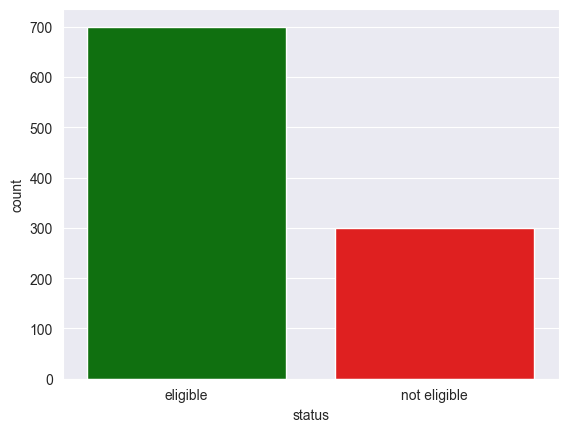

In [10]:
eligible["status"] = "eligible"
not_eligible["status"] = "not eligible"
combined_df = pd.concat([eligible,not_eligible])
sns.countplot(data=combined_df, x="status",palette={"eligible": "green", "not eligible": "red"},hue="status",legend=False)
eligible.drop(columns="status")
not_eligible.drop(columns="status")
plt.show()

Unbalanced Dataset: 70% of the entries are low risk loans, while the remaining are high risk loans. To deal with it we will stratify our training and test sets based on the "result" column for the Clustering. Similarly, we will implement stratified k-fold crossvalidation for the Supervised Learning.

### Correlation Matrixes


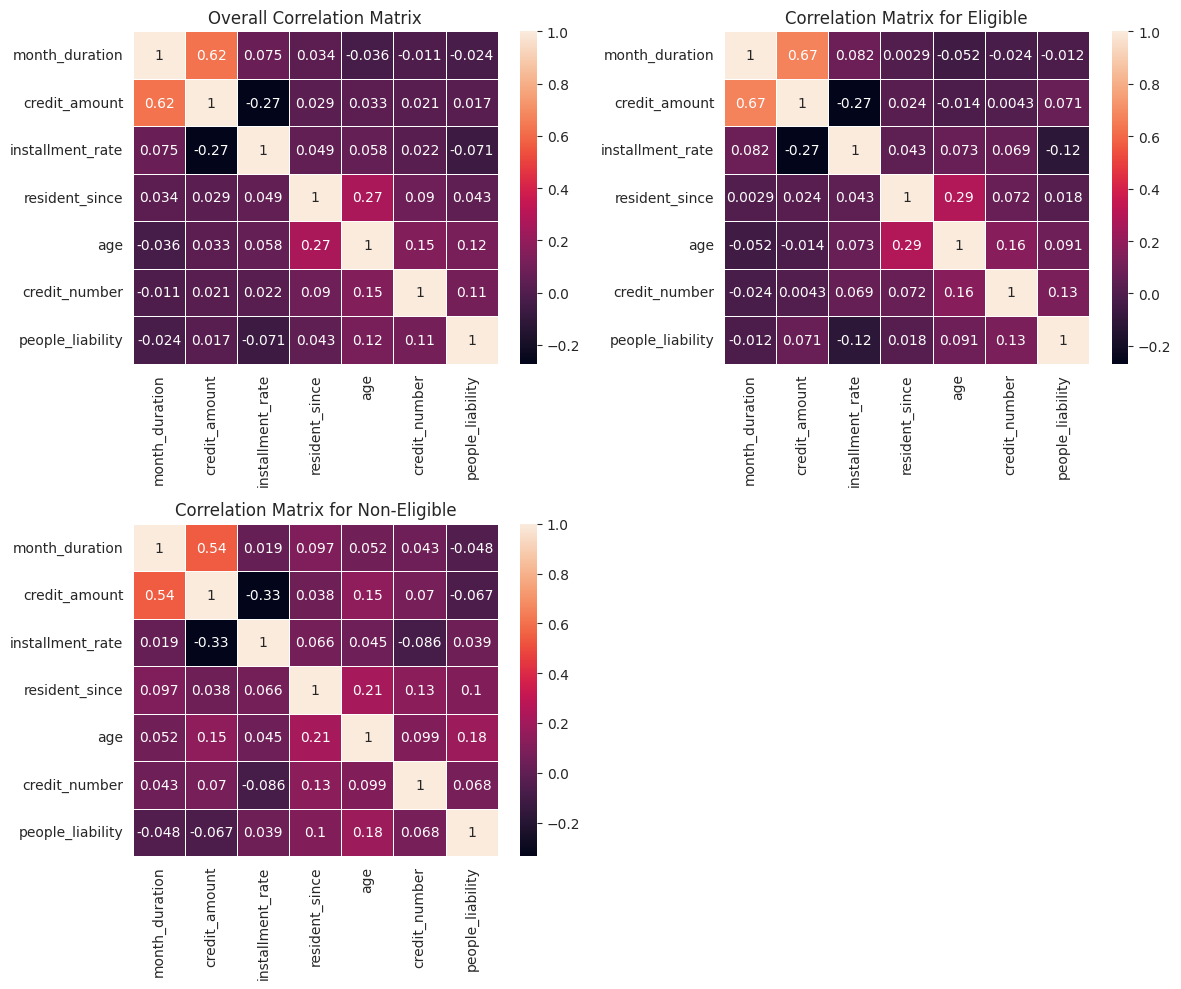

In [25]:
corr = df[numerical_attributes].corr()
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

ax1 = sns.heatmap(corr, annot=True, linewidth=0.5, xticklabels=numerical_attributes, ax=axes[0, 0])
ax1.set_yticklabels(labels=numerical_attributes, rotation=0)
ax1.set_title("Overall Correlation Matrix")

eligible = df[df["result"] == 1]
corr_eligible = eligible[numerical_attributes].corr()
ax2 = sns.heatmap(corr_eligible, annot=True, linewidth=0.5, xticklabels=numerical_attributes, ax=axes[0, 1])
ax2.set_yticklabels(labels=numerical_attributes, rotation=0)
ax2.set_title("Correlation Matrix for Eligible")

not_eligible = df[df["result"] == 2]
corr_not_eligible = not_eligible[numerical_attributes].corr()
ax3 = sns.heatmap(corr_not_eligible, annot=True, linewidth=0.5, xticklabels=numerical_attributes, ax=axes[1, 0])
ax3.set_yticklabels(labels=numerical_attributes, rotation=0)
ax3.set_title("Correlation Matrix for Non-Eligible")

fig.delaxes(axes[1, 1])

plt.tight_layout()
plt.show()

From the correlation matrix of the numerical attributes we can note that credit_amount and month_duration are the most correlated features. In addition no great differences are found between the correlation matrixes of Eligible and Non-Eligible entries.

### Age

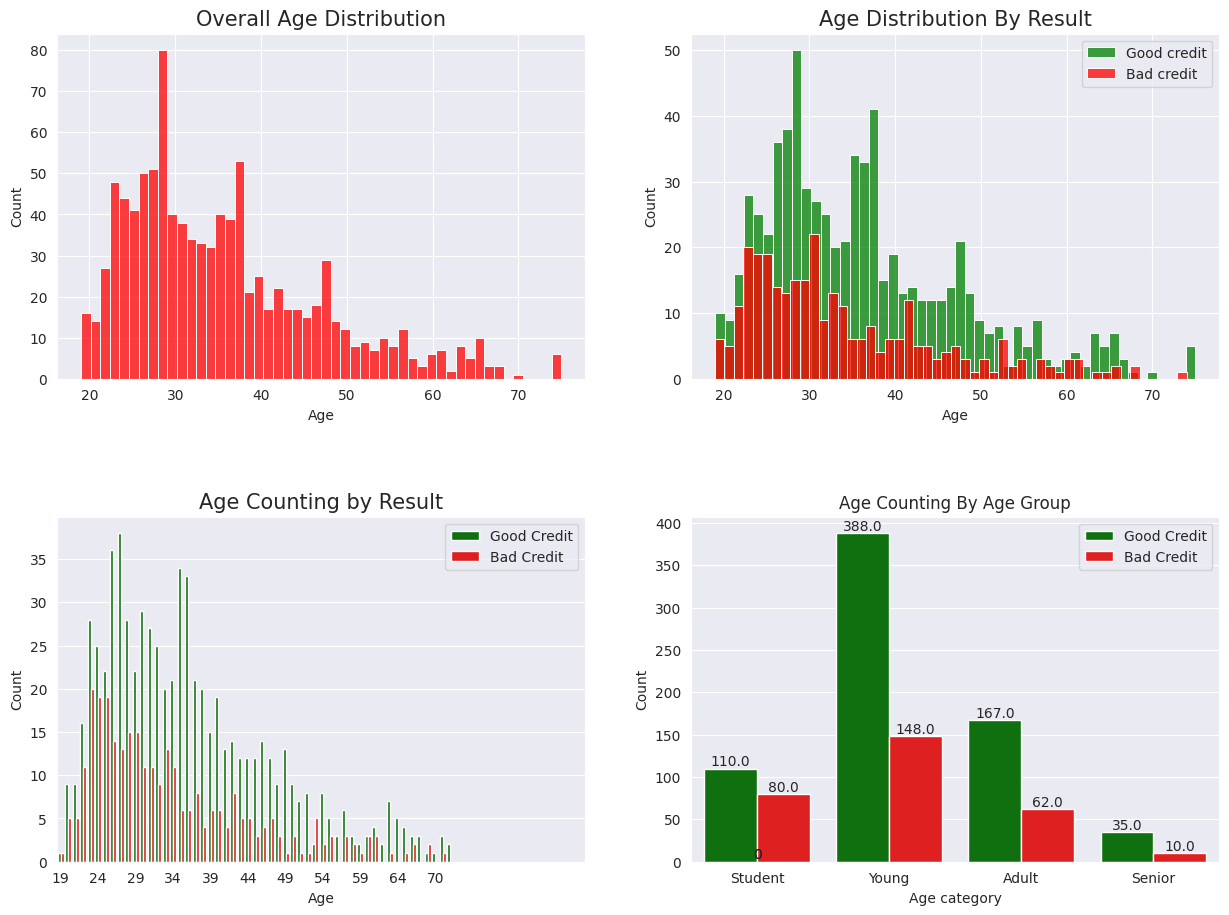

% Ratio Student Category: 58%
% Ratio Young Category: 72%
% Ratio Adult Category: 73%
% Ratio Senior Category: 78%


In [26]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.4, top=0.8)
interval = (18, 25, 40, 60, 120)
cats = ['Student', 'Young', 'Adult', 'Senior']
df["age_cat"] = pd.cut(df.age, interval, labels=cats)

g0 = sns.histplot(df["age"], color="Red", bins=50, ax=axes[0, 0])
g0.set_title("Overall Age Distribution", fontsize=15)
g0.set_xlabel("Age")
g0.set_ylabel("Count")

df_good = df[df["result"] == 1]
df_bad = df[df["result"] == 2]
custom_palette = ["green", "red"]
g1 = sns.histplot(df_good["age"], ax=axes[0, 1], color="green", bins=50, label='Good credit')
sns.histplot(df_bad["age"], ax=axes[0, 1], color='red', bins=50, label='Bad credit')
axes[0, 1].legend()
g1.set_title("Age Distribution By Result", fontsize=15)
g1.set_xlabel("Age")
g1.set_ylabel("Count")

g2 = sns.countplot(x="age", data=df, ax=axes[1, 0], palette=custom_palette, hue="result")

g2.set_xticks(range(0, df["age"].max(), 5))
g2.set_title("Age Counting by Result", fontsize=15)
g2.set_xlabel("Age")
g2.set_ylabel("Count")
g2.legend(labels=["Good Credit", "Bad Credit"])

g3 = sns.countplot(x="age_cat", data=df, ax=axes[1, 1], palette=custom_palette, hue='result')

list_height = []
for bar in g3.patches:
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    list_height.append(y)
    axes[1, 1].annotate(f'{y}', (x, y), ha='center', va='bottom')

g3.legend(labels=["Good Credit", "Bad Credit"])
g3.set_title("Age Counting By Age Group")
g3.set_xlabel("Age category")
g3.set_ylabel("Count")


plt.show()

for i in range(4):
    ratio = list_height[i] / (list_height[i] + list_height[i + 4]) * 100
    print(f"% Ratio {cats[i]} Category: {round(ratio)}%")


In the last plot by feature engineering all the dataset entries into 4 different groups: Student, Young, Adult and Senior based on their age, we delve into studying if the age group could matter in the outcome of the credit.
As the ratios show it seems that in Student group, aged from 18 to 25, it's more likely to encounter a bad credit in respect to the 70 / 30 general split of the dataset. On the other hand, for the Senior category (age greater equal than 60) a positive outcome is more probable. Additionally, the ratio seems increasing with the increasing of the age group. Therefore a question arouses:

- Could it be that older people by possessing more money or having a more stable, senior job in comparison than students are more likely to be good creditors? Or also the fact that some of them may already possess housing...

To reply to this question we will delve into studying if the age is moderated by other variables such as existing_account, saving_bonds, job, housing_status

### Duration


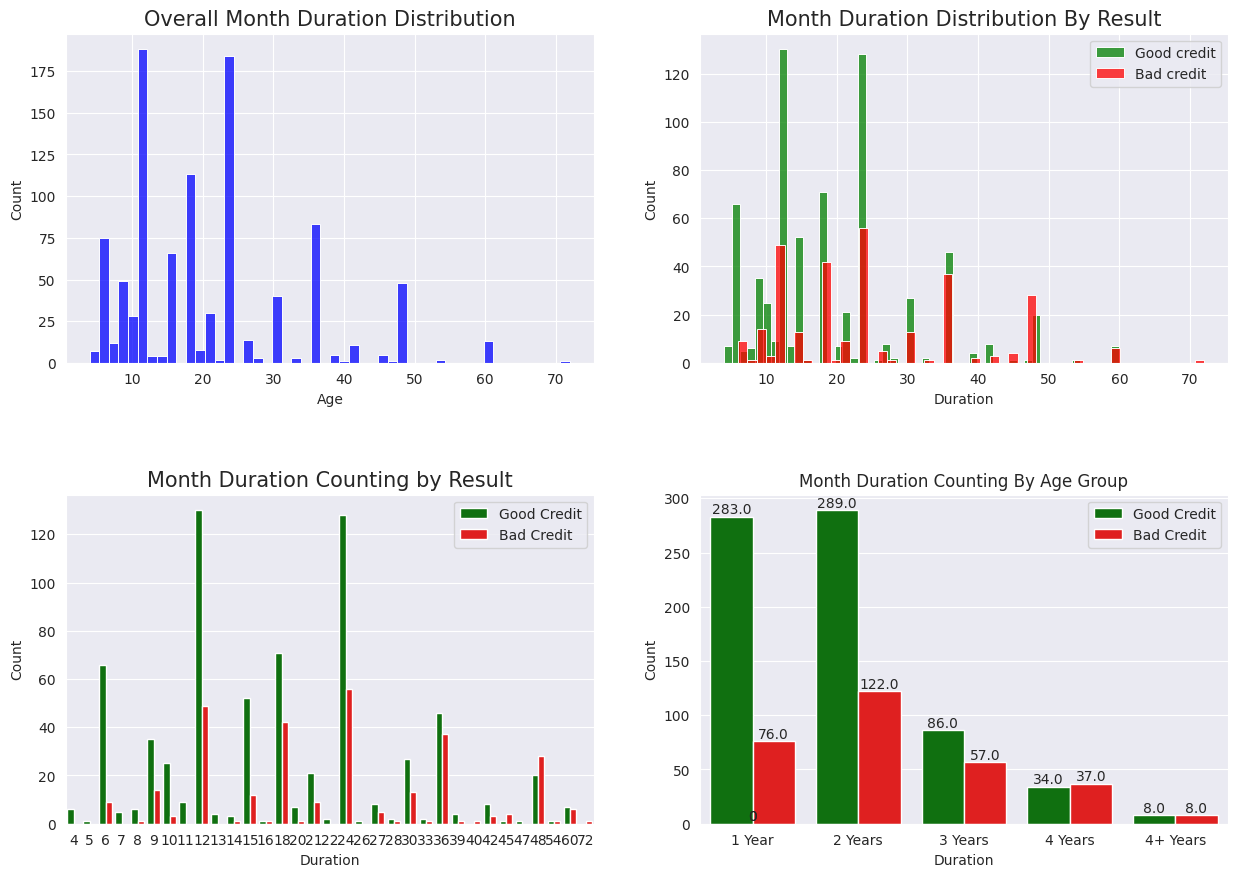

% Ratio 1 Year Category: 79%
% Ratio 2 Years Category: 70%
% Ratio 3 Years Category: 60%
% Ratio 4 Years Category: 48%
% Ratio 4+ Years Category: 50%


In [27]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
plt.subplots_adjust(hspace=0.4, top=0.9)
interval = (0,12, 24, 36, 48, 100)
cats = ['1 Year', '2 Years', '3 Years', '4 Years','4+ Years']
df["duration_cat"] = pd.cut(df.month_duration, interval, labels=cats)

sns.histplot(df["month_duration"], color="Blue", bins=50, ax=axes[0, 0])
axes[0, 0].set_title("Overall Month Duration Distribution", fontsize=15)
axes[0, 0].set_xlabel("Age")
axes[0, 0].set_ylabel("Count")

sns.histplot(df_good["month_duration"], color="green", bins=50, label='Good credit', ax=axes[0, 1])
sns.histplot(df_bad["month_duration"], color='red', bins=50, label='Bad credit', ax=axes[0, 1])
axes[0, 1].legend()
axes[0, 1].set_title("Month Duration Distribution By Result", fontsize=15)
axes[0, 1].set_xlabel("Duration")
axes[0, 1].set_ylabel("Count")

custom_palette = ["green", "red"]
sns.countplot(x="month_duration", data=df, ax=axes[1, 0], palette=custom_palette, hue="result")
axes[1, 0].set_title("Month Duration Counting by Result", fontsize=15)
axes[1, 0].set_xlabel("Duration")
axes[1, 0].set_ylabel("Count")
axes[1, 0].legend(labels=["Good Credit", "Bad Credit"])

sns.countplot(x="duration_cat", data=df, ax=axes[1, 1], palette=custom_palette, hue='result')

list_height = []
for bar in axes[1, 1].patches:
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    list_height.append(y)
    axes[1, 1].annotate(f'{y}', (x, y), ha='center', va='bottom')

axes[1, 1].legend(labels=["Good Credit", "Bad Credit"])
axes[1, 1].set_title("Month Duration Counting By Age Group")
axes[1, 1].set_xlabel("Duration")
axes[1, 1].set_ylabel("Count")

plt.show()

for i in range(5):
    ratio = list_height[i] / (list_height[i] + list_height[i + 5]) * 100
    print(f"% Ratio {cats[i]} Category: {round(ratio)}%")


It's interesting to note how the longer the loan duration is the more likely it could be a non-eligible loan.

### Credit Amount

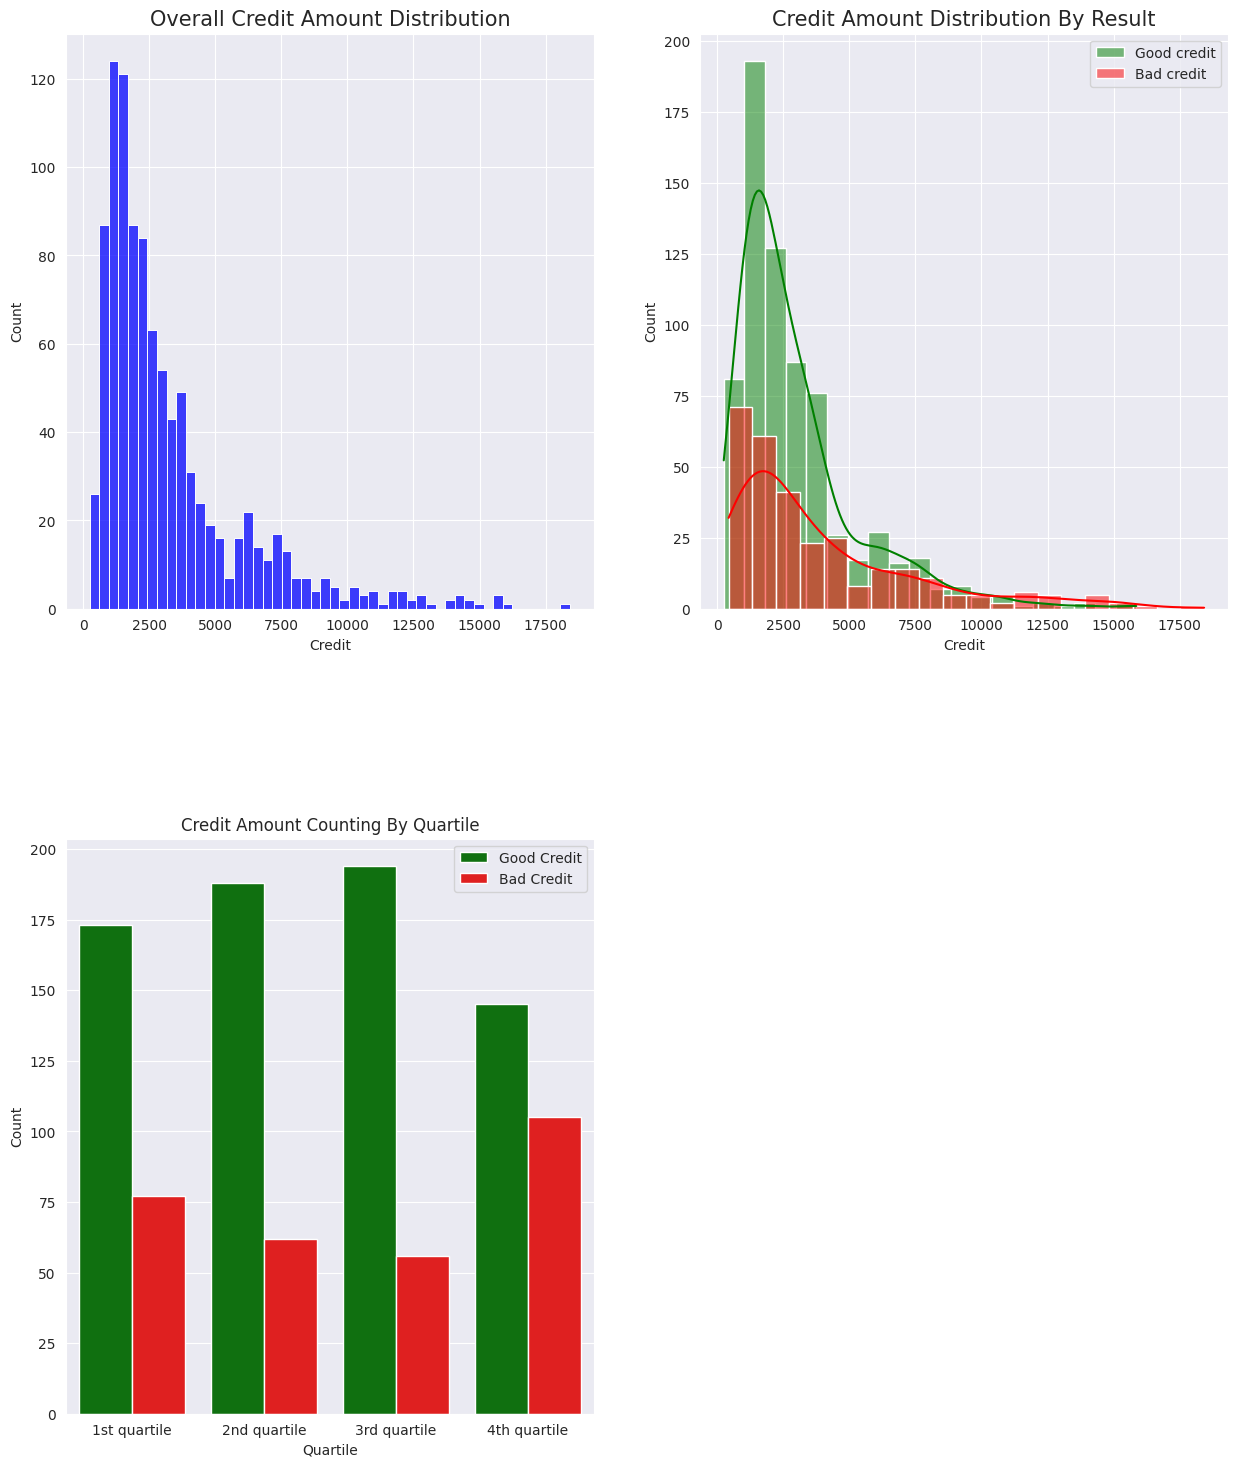

% Ratio 1st quartile Category: 69%
% Ratio 2nd quartile Category: 75%
% Ratio 3rd quartile Category: 78%
% Ratio 4th quartile Category: 58%


In [28]:

interval = (0, 1365.5, 2319.5, 3972.25, 20000)
cats = ['1st quartile', '2nd quartile', '3rd quartile', '4th quartile']
df["amount_cat"] = pd.cut(df.credit_amount, interval, labels=cats)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 20))
plt.subplots_adjust(hspace=0.4, top=0.8)

sns.histplot(df["credit_amount"], color="Blue", bins=50, ax=axes[0, 0])
axes[0, 0].set_title("Overall Credit Amount Distribution", fontsize=15)
axes[0, 0].set_xlabel("Credit")
axes[0, 0].set_ylabel("Count")

sns.histplot(df_good["credit_amount"], color="green", bins=20, label='Good credit', kde=True, ax=axes[0, 1])
sns.histplot(df_bad["credit_amount"], color='red', bins=20, label='Bad credit', kde=True, ax=axes[0, 1])
axes[0, 1].legend()
axes[0, 1].set_title("Credit Amount Distribution By Result", fontsize=15)
axes[0, 1].set_xlabel("Credit")
axes[0, 1].set_ylabel("Count")

custom_palette = ["green", "red"]
sns.countplot(x="amount_cat", data=df, ax=axes[1, 0], palette=custom_palette, hue='result')
axes[1, 0].legend(labels=["Good Credit", "Bad Credit"])
axes[1, 0].set_title("Credit Amount Counting By Quartile")
axes[1, 0].set_xlabel("Quartile")
axes[1, 0].set_ylabel("Count")

axes[1, 1].axis('off')
list_height = []
for bar in axes[1, 0].patches:
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    list_height.append(y)
plt.show()

res = []
for i in range(4):
    res = list_height[i] / (list_height[i] + list_height[i + 4]) * 100
    print(f"% Ratio {cats[i]} Category: {round(res)}%")


### Installment Rate

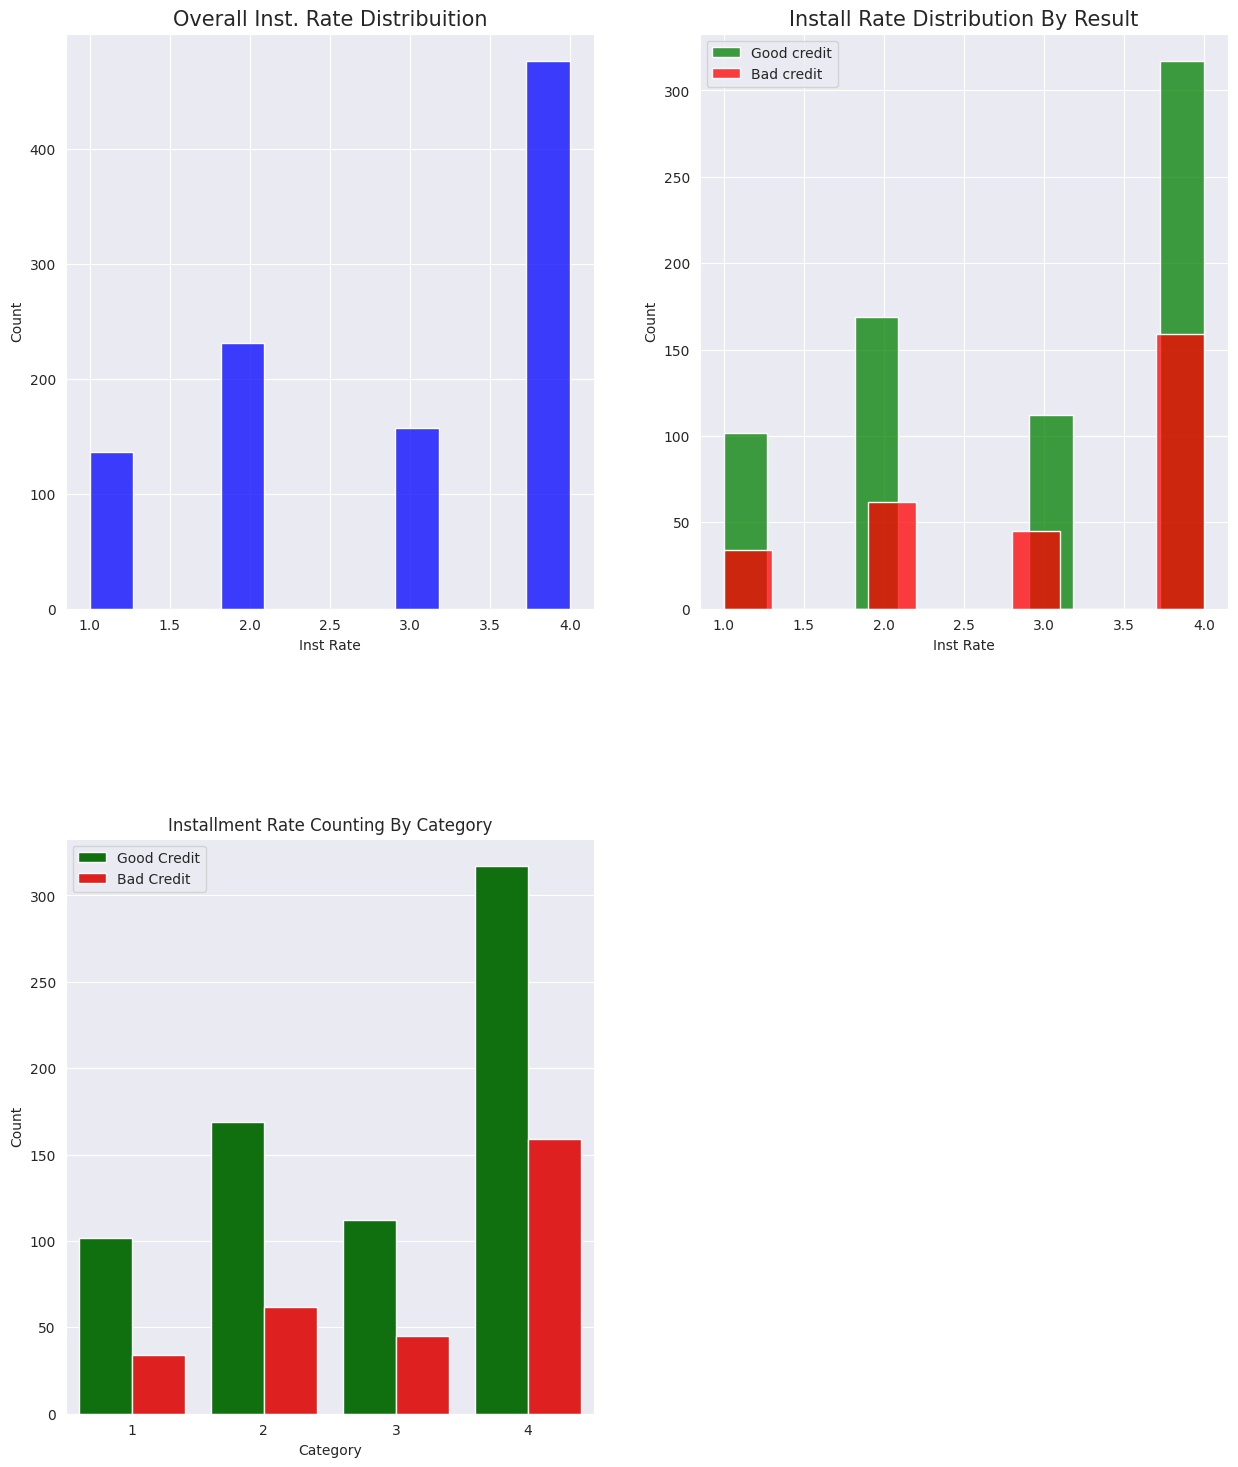

% Ratio 1 Category: 75%
% Ratio 2 Category: 73%
% Ratio 3 Category: 71%
% Ratio 4 Category: 67%


In [29]:

interval = (0, 1, 2, 3, 4)
cats = ['1', '2', '3', '4']
df["rate_cat"] = pd.cut(df.installment_rate, interval, labels=cats)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 20))
plt.subplots_adjust(hspace=0.4, top=0.8)

sns.histplot(df["installment_rate"], color="Blue", ax=axes[0, 0])
axes[0, 0].set_title("Overall Inst. Rate Distribuition", fontsize=15)
axes[0, 0].set_xlabel("Inst Rate")
axes[0, 0].set_ylabel("Count")

sns.histplot(df_good["installment_rate"], color="green", label='Good credit', ax=axes[0, 1])
sns.histplot(df_bad["installment_rate"], color='red', label='Bad credit', ax=axes[0, 1])
axes[0, 1].legend()
axes[0, 1].set_title("Install Rate Distribution By Result", fontsize=15)
axes[0, 1].set_xlabel("Inst Rate")
axes[0, 1].set_ylabel("Count")

custom_palette = ["green", "red"]
sns.countplot(x="rate_cat", data=df, ax=axes[1, 0], palette=custom_palette, hue='result')
axes[1, 0].legend(labels=["Good Credit", "Bad Credit"])
axes[1, 0].set_title("Installment Rate Counting By Category")
axes[1, 0].set_xlabel("Category")
axes[1, 0].set_ylabel("Count")

axes[1, 1].axis('off')
list_height = []
for bar in axes[1, 0].patches:
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    list_height.append(y)
plt.show()

res = []
for i in range(4):
    res = list_height[i] / (list_height[i] + list_height[i + 4]) * 100
    print(f"% Ratio {cats[i]} Category: {round(res)}%")


# Credit Number

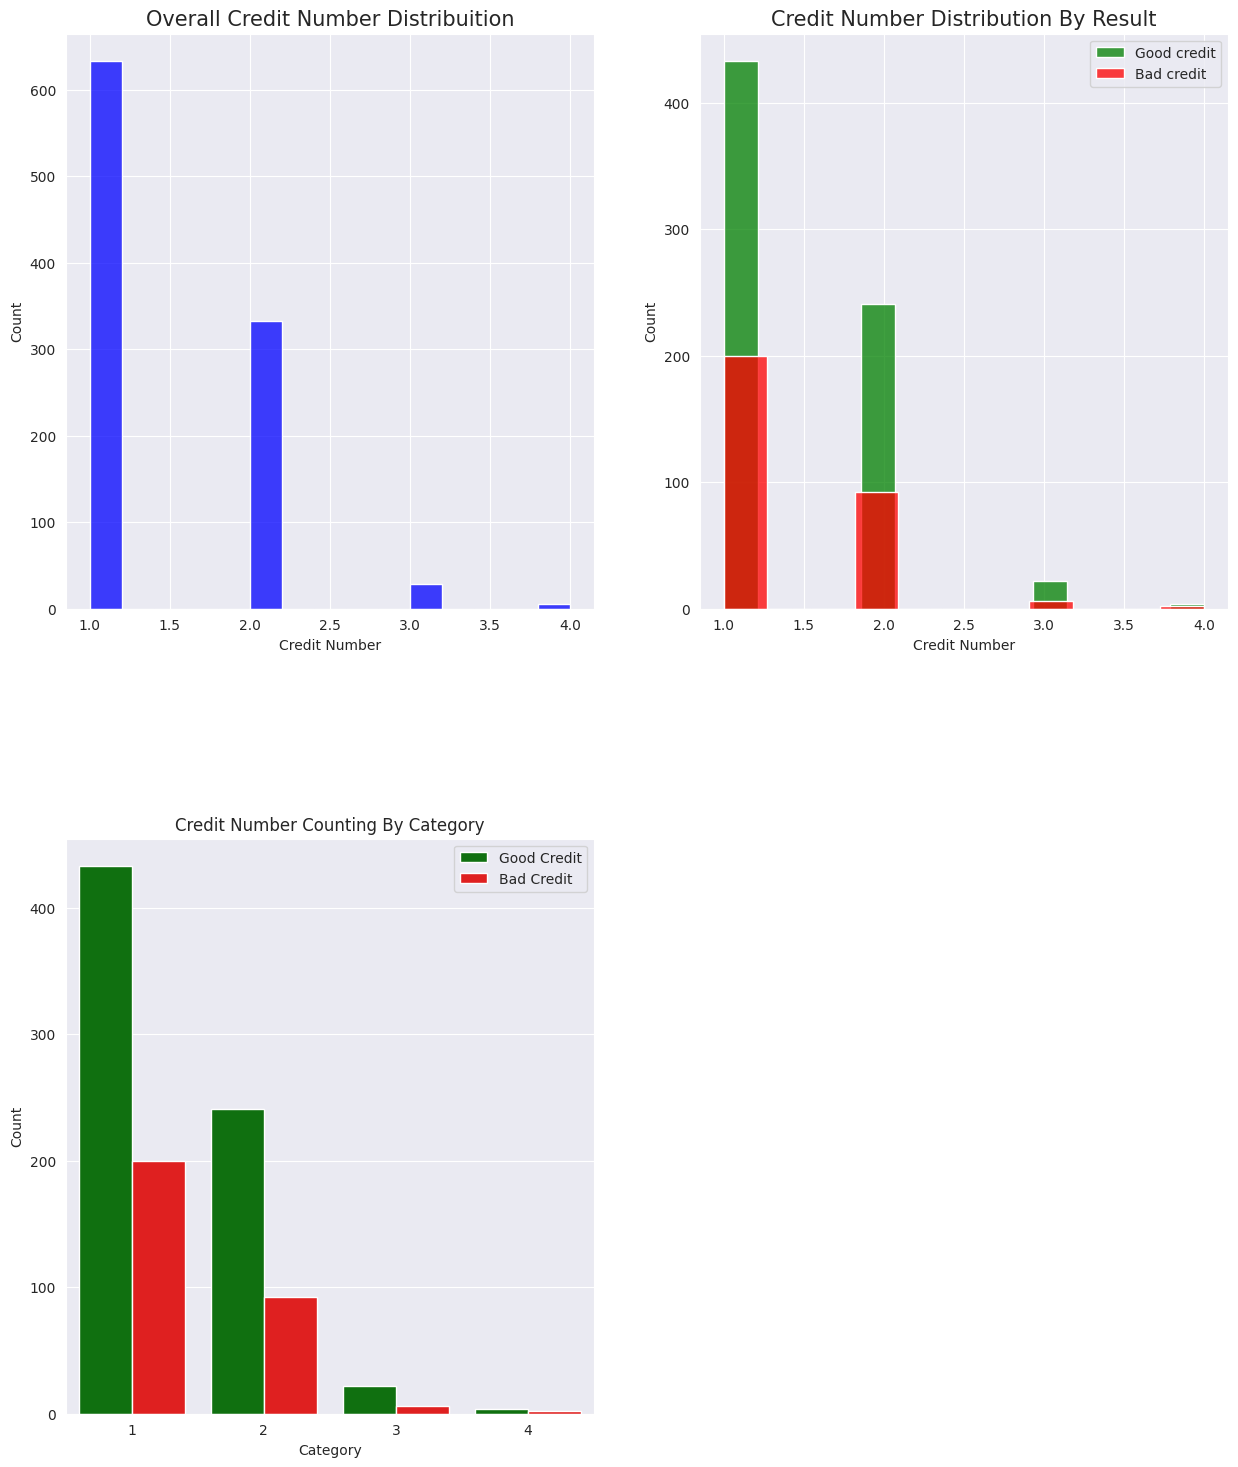

% Ratio 1 Category: 68%
% Ratio 2 Category: 72%
% Ratio 3 Category: 79%
% Ratio 4 Category: 67%


In [30]:

interval = (0, 1, 2, 3, 4)
cats = ['1', '2', '3', '4']
df["crnum_cat"] = pd.cut(df.credit_number, interval, labels=cats)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 20))
plt.subplots_adjust(hspace=0.4, top=0.8)

sns.histplot(df["credit_number"], color="Blue", ax=axes[0, 0])
axes[0, 0].set_title("Overall Credit Number Distribuition", fontsize=15)
axes[0, 0].set_xlabel("Credit Number")
axes[0, 0].set_ylabel("Count")

sns.histplot(df_good["credit_number"], color="green", label='Good credit', ax=axes[0, 1])
sns.histplot(df_bad["credit_number"], color='red', label='Bad credit', ax=axes[0, 1])
axes[0, 1].legend()
axes[0, 1].set_title("Credit Number Distribution By Result", fontsize=15)
axes[0, 1].set_xlabel("Credit Number")
axes[0, 1].set_ylabel("Count")

custom_palette = ["green", "red"]
sns.countplot(x="crnum_cat", data=df, ax=axes[1, 0], palette=custom_palette, hue='result')
axes[1, 0].legend(labels=["Good Credit", "Bad Credit"])
axes[1, 0].set_title("Credit Number Counting By Category")
axes[1, 0].set_xlabel("Category")
axes[1, 0].set_ylabel("Count")
axes[1, 1].axis('off')

plt.show()
list_height = []
for bar in axes[1, 0].patches:
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    list_height.append(y)
res = []
for i in range(4):
    res = list_height[i] / (list_height[i] + list_height[i + 4]) * 100
    print(f"% Ratio {cats[i]} Category: {round(res)}%")


### Count Savings
Here we delve also into considering if the variables Count Savings and Age are modulated between each other. Same goes for the Count Savings and Credit Amount variables.

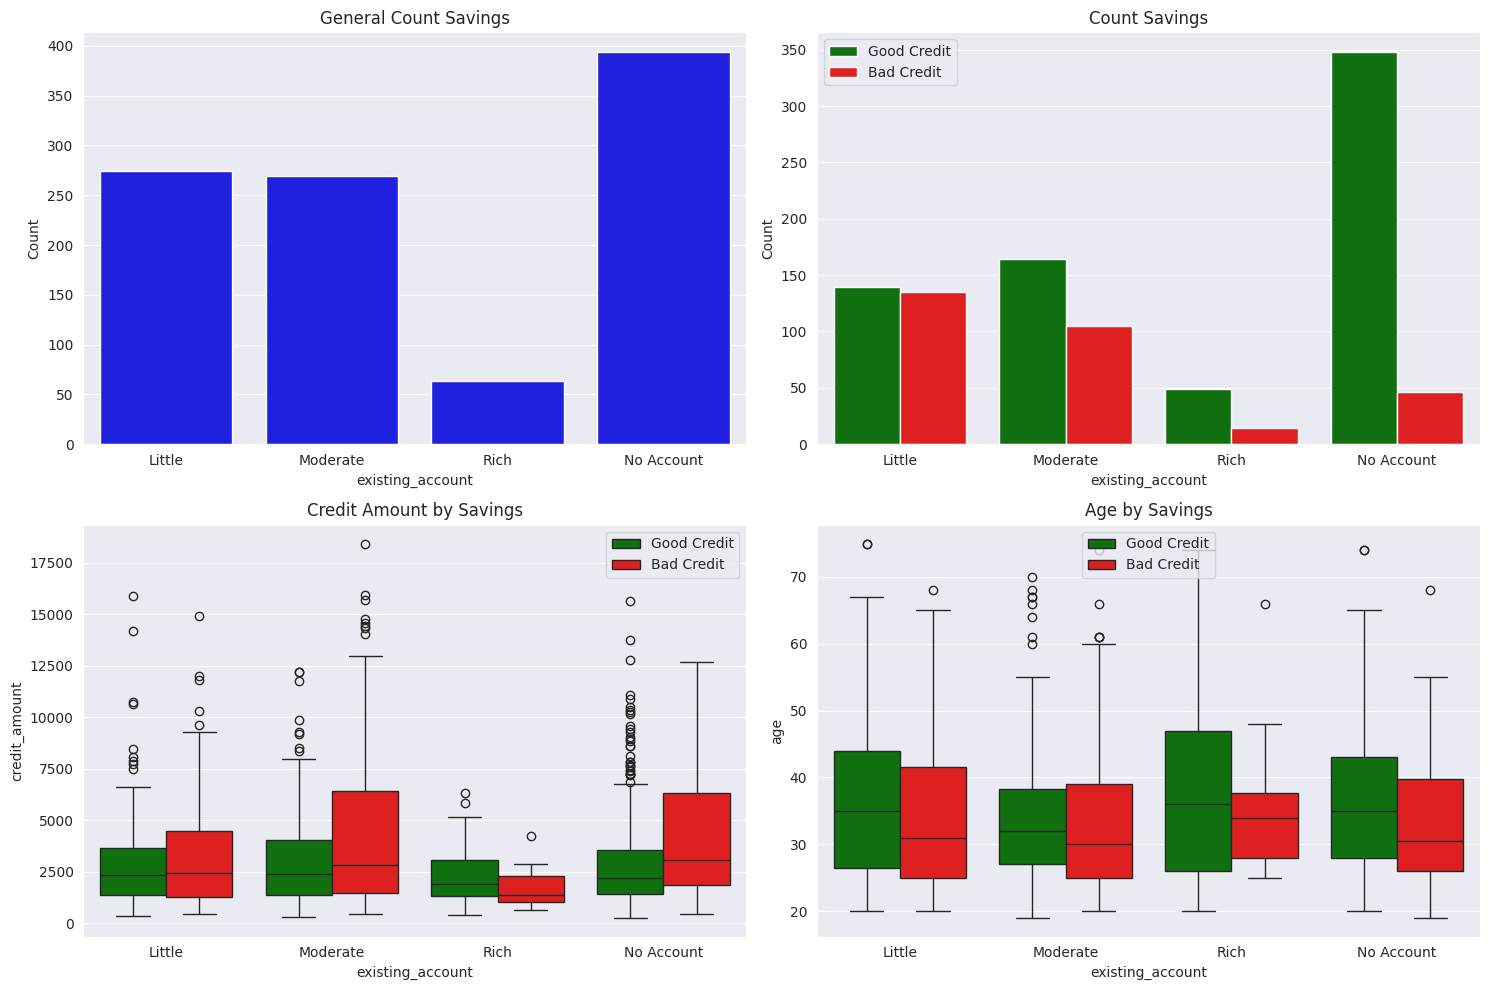

In [31]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
custom_palette = ["green","red"]

ticks = ["Little", "Moderate", "Rich", "No Account"]
sns.countplot(x="existing_account", data=df_encode, color="blue", ax=axes[0, 0])
axes[0, 0].set_ylabel("Count")
axes[0, 0].set_xticks([0, 1, 2, 3])
axes[0, 0].set_xticklabels(ticks)
axes[0, 0].set_title('General Count Savings')

sns.countplot(x="existing_account", data=df_encode, palette=custom_palette,hue="result",  ax=axes[0, 1])
axes[0, 1].set_ylabel("Count")
axes[0, 1].legend(labels=["Good Credit", "Bad Credit"])
axes[0, 1].set_xticks([0, 1, 2, 3])
axes[0, 1].set_xticklabels(ticks)
axes[0, 1].set_title('Count Savings')

sns.boxplot(x="existing_account", y="credit_amount", data=df_encode, palette=custom_palette, hue="result", ax=axes[1, 0])
legend = axes[1, 0].legend()
legend.get_texts()[0].set_text('Good Credit')
legend.get_texts()[1].set_text('Bad Credit')
axes[1, 0].set_xticks([0, 1, 2, 3])
axes[1, 0].set_xticklabels(ticks)
axes[1, 0].set_title('Credit Amount by Savings')

sns.boxplot(x="existing_account", y="age", data=df_encode, palette=custom_palette, hue="result", ax=axes[1, 1])
legend = axes[1, 1].legend(loc = "upper center")
legend.get_texts()[0].set_text('Good Credit')
legend.get_texts()[1].set_text('Bad Credit')
axes[1, 1].set_xticks([0, 1, 2, 3])
axes[1, 1].set_xticklabels(ticks)
axes[1, 1].set_title('Age by Savings')


plt.tight_layout()
plt.show()


### Saving Bonds
Here we also delve also into considering if the variables Saving Bonds and Age are modulated between each other. Same goes for the Saving Bonds and Credit Amount variables.

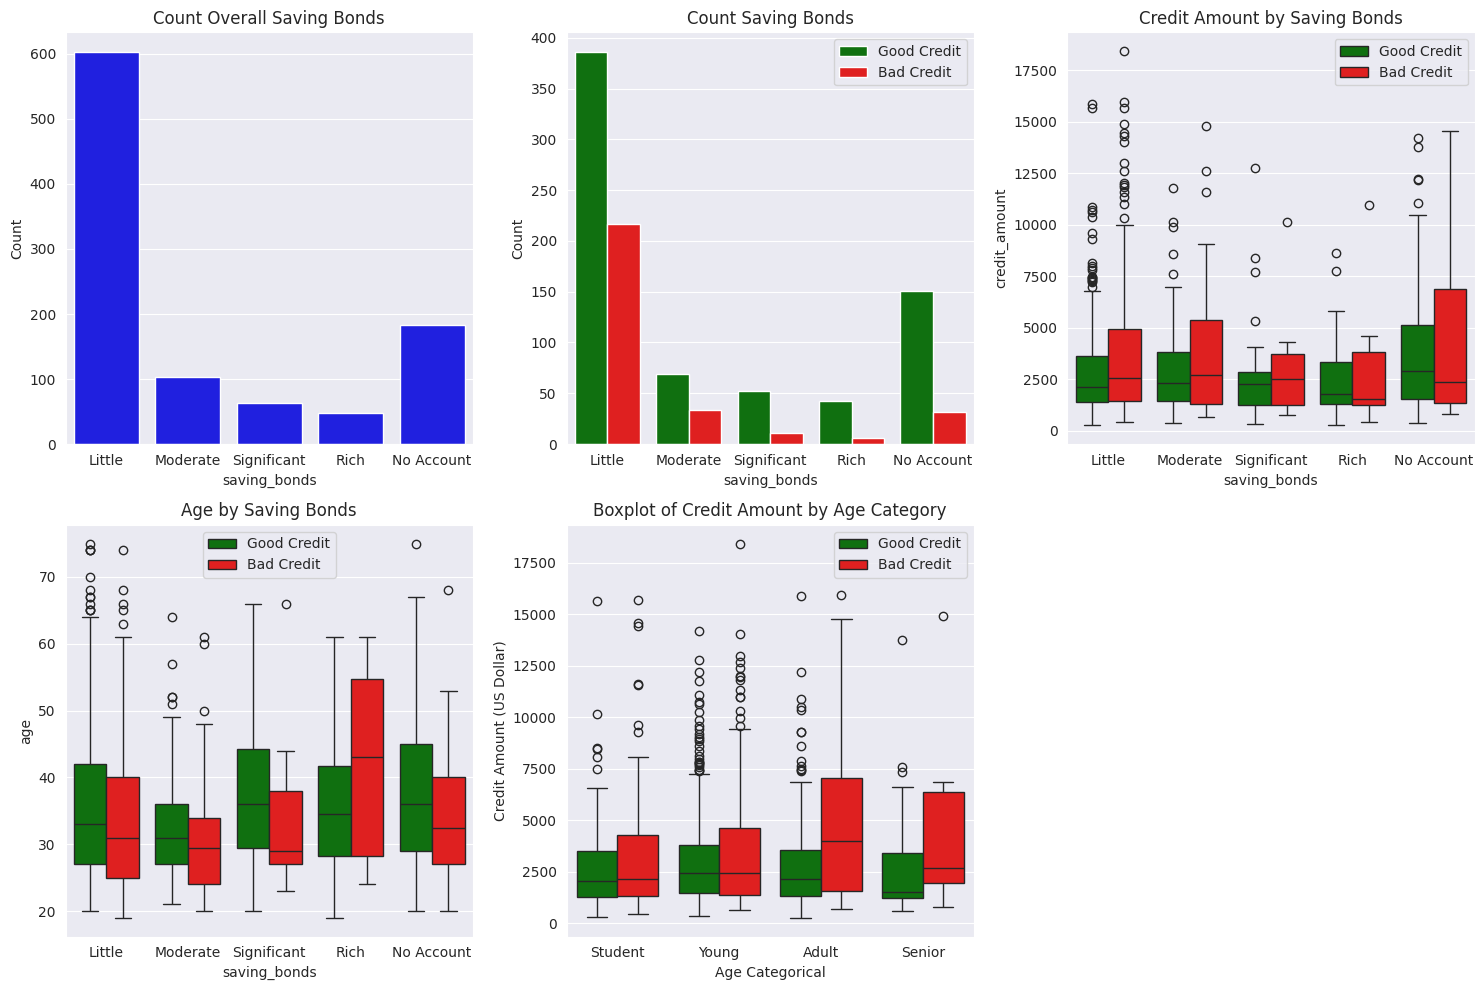

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

ticks = ["Little", "Moderate", "Significant", "Rich", "No Account"]
sns.countplot(x="saving_bonds", data=df_encode,color = "blue", ax=axes[0, 0])
axes[0, 0].set_ylabel("Count")
axes[0, 0].set_xticks([0, 1, 2, 3, 4])
axes[0, 0].set_xticklabels(ticks)
axes[0, 0].set_title('Count Overall Saving Bonds')

sns.countplot(x="saving_bonds", data=df_encode, hue="result", palette=custom_palette, ax=axes[0, 1])
axes[0, 1].set_ylabel("Count")
axes[0, 1].legend(labels=["Good Credit","Bad Credit"])
axes[0, 1].set_xticks([0, 1, 2, 3, 4])
axes[0, 1].set_xticklabels(ticks)
axes[0, 1].set_title('Count Saving Bonds')

sns.boxplot(x="saving_bonds", y="credit_amount", data=df_encode, hue="result", palette=custom_palette, ax=axes[0, 2])
lgd1 = axes[0, 2].legend()
lgd1.get_texts()[0].set_text('Good Credit')
lgd1.get_texts()[1].set_text('Bad Credit')
axes[0, 2].set_xticks([0, 1, 2, 3, 4])
axes[0, 2].set_xticklabels(ticks)
axes[0, 2].set_title('Credit Amount by Saving Bonds')

sns.boxplot(x="saving_bonds", y="age", data=df_encode, hue="result", palette=custom_palette, ax=axes[1, 0])
lgd2 = axes[1, 0].legend()
lgd2.get_texts()[0].set_text('Good Credit')
lgd2.get_texts()[1].set_text('Bad Credit')
axes[1, 0].set_xticks([0, 1, 2, 3, 4])
axes[1, 0].set_xticklabels(ticks)
axes[1, 0].set_title('Age by Saving Bonds')

sns.boxplot(x="age_cat", y="credit_amount", hue="result", data=df, palette=custom_palette, ax=axes[1, 1])
lgd3 = axes[1, 1].legend()
lgd3.get_texts()[0].set_text('Good Credit')
lgd3.get_texts()[1].set_text('Bad Credit')
axes[1, 1].set_xlabel('Age Categorical')
axes[1, 1].set_ylabel('Credit Amount (US Dollar)')
axes[1, 1].set_title('Boxplot of Credit Amount by Age Category')

axes[1, 2].axis('off')

plt.tight_layout()
plt.show()


We can note how good credits seem to have similar credit amount distribution across all age classes, while bad credits have a different distribution in the Adult and Senior classes related to Student and Young classes. This means that the bank is generally more willing to offer higher credit amounts to older people.

### Job
Here we also delve also into considering if the variables Job and Age are modulated between each other. Same goes for the Job and Credit Amount variables.

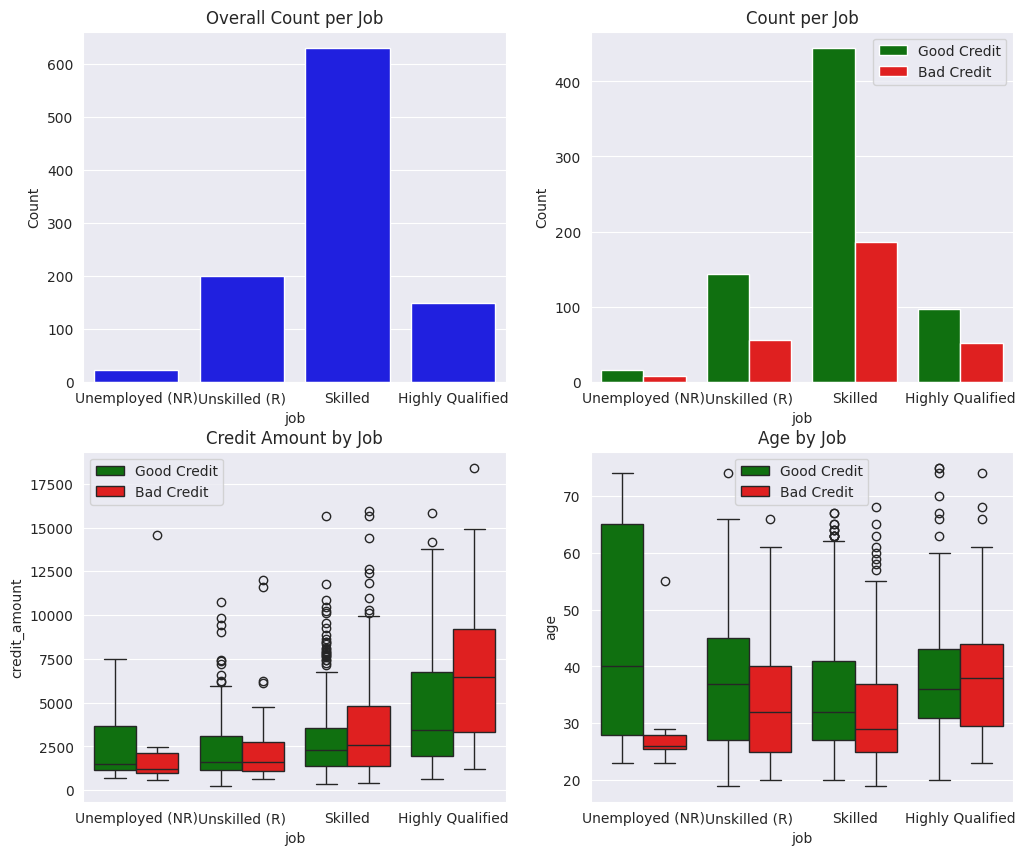

In [36]:

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

ticks = ["Unemployed (NR)", "Unskilled (R)", "Skilled", "Highly Qualified"]
sns.countplot(x="job", data=df_encode,color="blue", ax=axes[0, 0])
axes[0, 0].set_ylabel("Count")
axes[0, 0].set_xticks([0, 1, 2, 3])
axes[0, 0].set_xticklabels(ticks)
axes[0, 0].set_title('Overall Count per Job')

sns.countplot(x="job", data=df_encode, hue="result", palette=custom_palette, ax=axes[0, 1])
axes[0, 1].set_ylabel("Count")
axes[0, 1].set_xticks([0, 1, 2, 3])
axes[0, 1].set_xticklabels(ticks)
axes[0, 1].set_title('Count per Job')
axes[0,1].legend(["Good Credit","Bad Credit"])
sns.boxplot(x="job", y="credit_amount", data=df_encode, palette={1: "green", 2: "red"}, hue="result", ax=axes[1, 0])
l = axes[1, 0].legend()
l.get_texts()[0].set_text('Good Credit')
l.get_texts()[1].set_text('Bad Credit')
axes[1, 0].set_xticks([0, 1, 2, 3])
axes[1, 0].set_xticklabels(ticks)
axes[1, 0].set_title('Credit Amount by Job')

sns.boxplot(x="job", y="age", data=df_encode, palette={1: "green", 2: "red"}, hue="result", ax=axes[1, 1])
l = axes[1, 1].legend()
l.get_texts()[0].set_text('Good Credit')
l.get_texts()[1].set_text('Bad Credit')
axes[1, 1].set_xticks([0, 1, 2, 3])
axes[1, 1].set_xticklabels(ticks)
axes[1, 1].set_title('Age by Job')

plt.show()

### Employment Status
Here we delve also into considering if the variables Employment Status and Age are modulated between each other. Same goes for the Employment Status and Credit Amount variables.

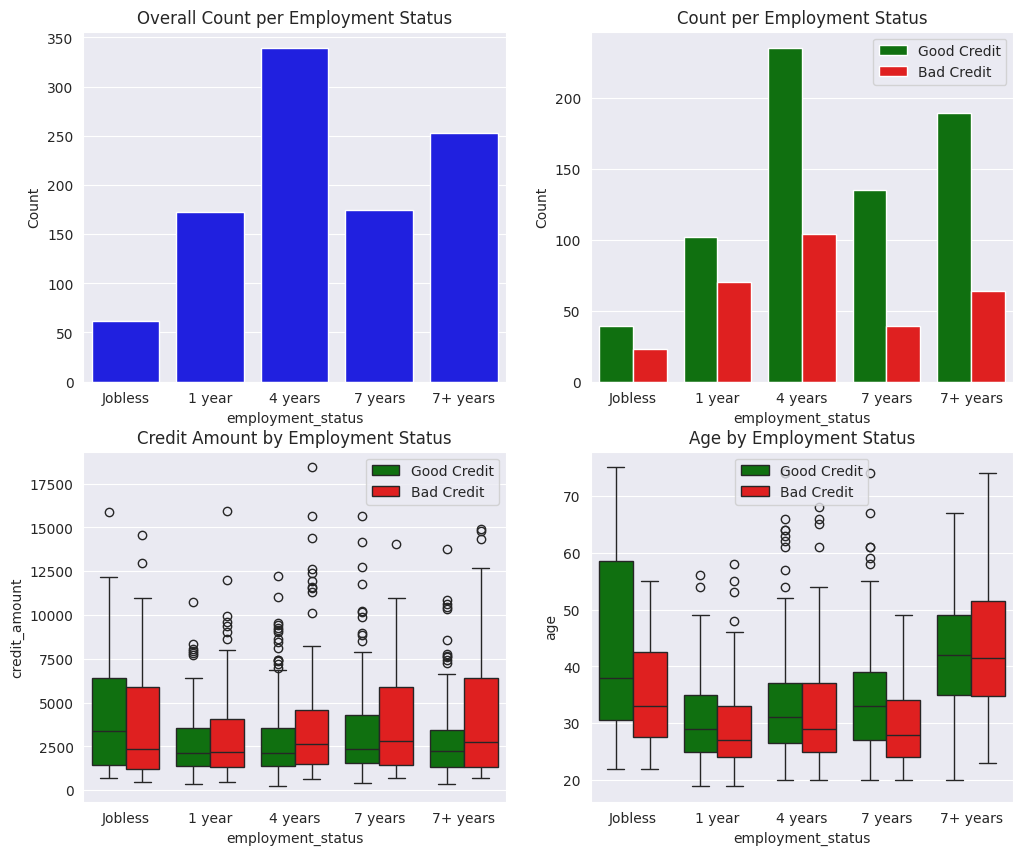

In [35]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

ticks = ["Jobless", "1 year", "4 years", "7 years", "7+ years"]
sns.countplot(x="employment_status", data=df_encode, color="blue", ax=axes[0, 0])
axes[0, 0].set_ylabel("Count")
axes[0, 0].set_xticks([0, 1, 2, 3, 4])
axes[0, 0].set_xticklabels(ticks)
axes[0, 0].set_title('Overall Count per Employment Status')

sns.countplot(x="employment_status", data=df_encode, hue="result", palette=custom_palette, ax=axes[0, 1])
axes[0, 1].set_ylabel("Count")
axes[0, 1].set_xticks([0, 1, 2, 3, 4])
axes[0, 1].set_xticklabels(ticks)
axes[0, 1].set_title('Count per Employment Status')
axes[0, 1].legend(labels=["Good Credit", "Bad Credit"])

sns.boxplot(x="employment_status", y="credit_amount", data=df_encode, hue="result", palette=custom_palette, ax=axes[1, 0])
axes[1, 0].set_xticks([0, 1, 2, 3, 4])
axes[1, 0].set_xticklabels(ticks)
axes[1, 0].set_title('Credit Amount by Employment Status')
l = axes[1, 0].legend()
l.get_texts()[0].set_text('Good Credit')
l.get_texts()[1].set_text('Bad Credit')

sns.boxplot(x="employment_status", y="age", data=df_encode, hue="result", palette=custom_palette, ax=axes[1, 1])
axes[1, 1].set_xticks([0, 1, 2, 3, 4])
axes[1, 1].set_xticklabels(ticks)
axes[1, 1].set_title('Age by Employment Status')
ll = axes[1, 1].legend()
ll.get_texts()[0].set_text('Good Credit')
ll.get_texts()[1].set_text('Bad Credit')


plt.show()


### Credit History
Here we delve also into considering if the variables Credit History and Age are modulated between each other. Same goes for the Credit History and Credit Amount variables.

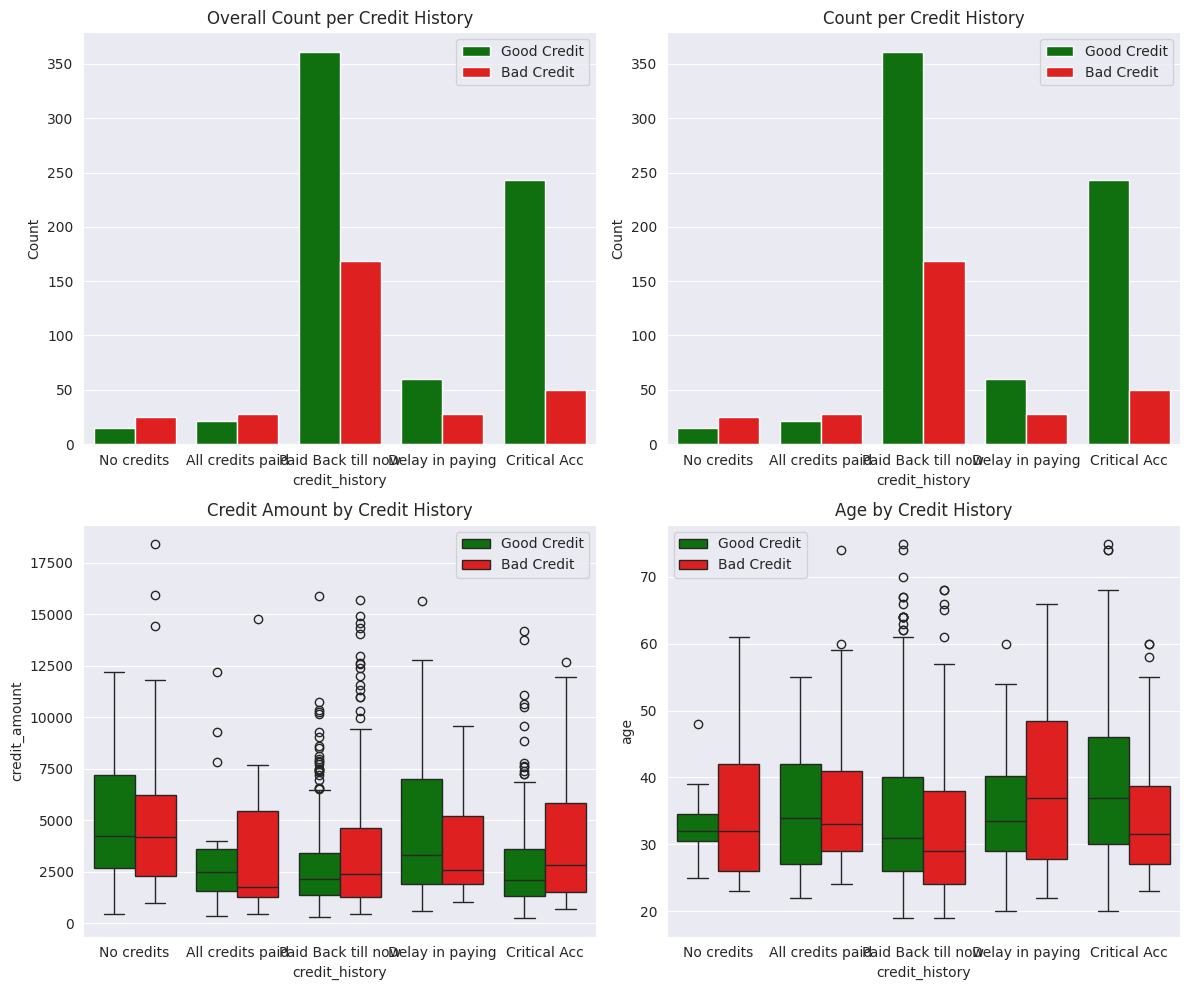

In [127]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

ticks = ["No credits", "All credits paid", "Paid Back till now", "Delay in paying", "Critical Acc"]
sns.countplot(x="credit_history", data=df_encode, palette=custom_palette,hue="result", ax=axes[0, 0])
axes[0, 0].set_ylabel("Count")
axes[0, 0].set_xticks([0, 1, 2, 3, 4])
axes[0, 0].set_xticklabels(ticks)
axes[0, 0].set_title('Overall Count per Credit History')
axes[0, 0].legend(labels=["Good Credit", "Bad Credit"])

sns.countplot(x="credit_history", data=df_encode, hue="result", palette=custom_palette, ax=axes[0, 1])
axes[0, 1].set_ylabel("Count")
axes[0, 1].set_xticks([0, 1, 2, 3, 4])
axes[0, 1].set_xticklabels(ticks)
axes[0, 1].set_title('Count per Credit History')
axes[0, 1].legend(labels=["Good Credit", "Bad Credit"])

sns.boxplot(x="credit_history", y="credit_amount", data=df_encode, hue="result", palette=custom_palette, ax=axes[1, 0])
axes[1, 0].set_xticks([0, 1, 2, 3, 4])
axes[1, 0].set_xticklabels(ticks)
axes[1, 0].set_title('Credit Amount by Credit History')
l = axes[1, 0].legend()
l.get_texts()[0].set_text('Good Credit')
l.get_texts()[1].set_text('Bad Credit')

sns.boxplot(x="credit_history", y="age", data=df_encode, hue="result", palette=custom_palette, ax=axes[1, 1])
axes[1, 1].set_xticks([0, 1, 2, 3, 4])
axes[1, 1].set_xticklabels(ticks)
axes[1, 1].set_title('Age by Credit History')
ll = axes[1, 1].legend()
ll.get_texts()[0].set_text('Good Credit')
ll.get_texts()[1].set_text('Bad Credit')

plt.tight_layout()


plt.show()


### Purpose


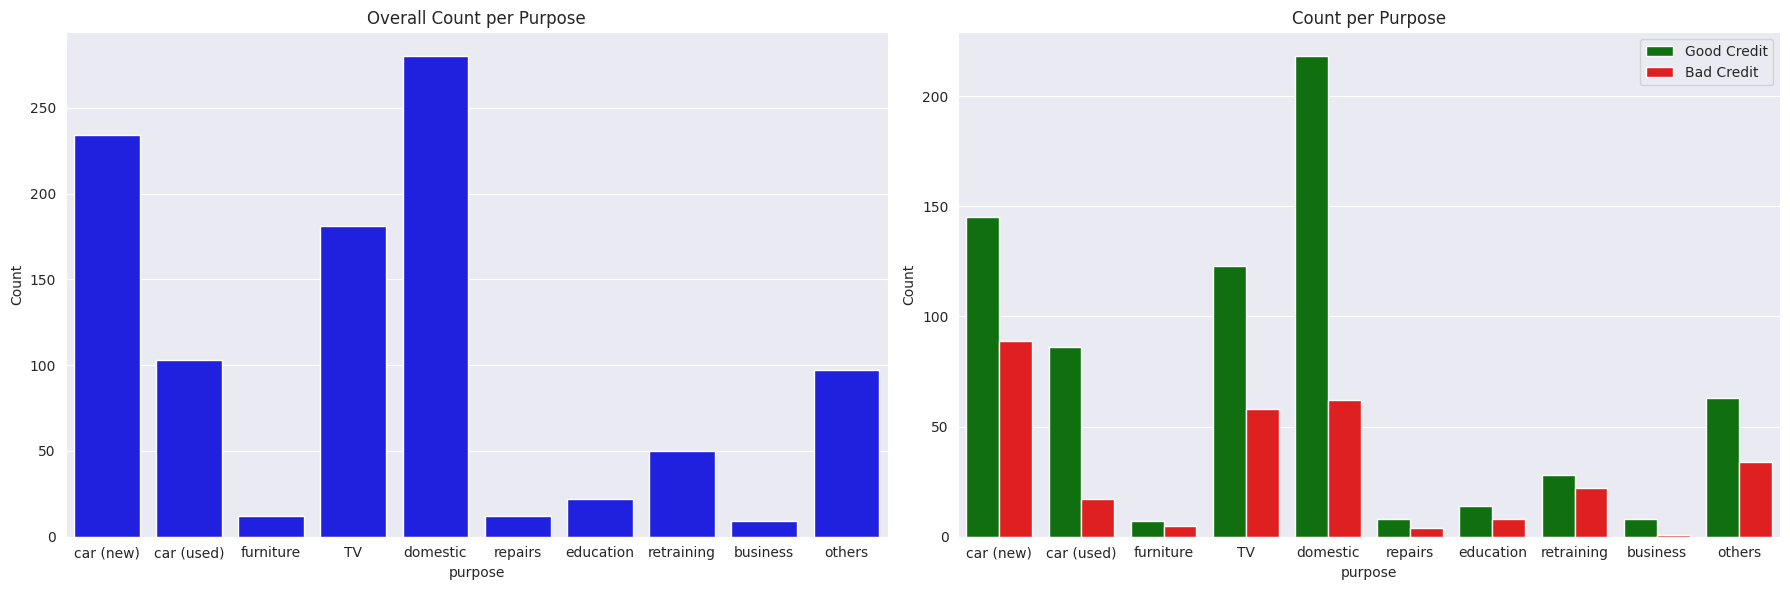

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
ticks = ["car (new)", "car (used)", "furniture", "TV", "domestic", "repairs", "education", "retraining", "business", "others"]
sns.countplot(x="purpose", data=df_encode, color = "blue", ax=axes[0])
axes[0].set_ylabel("Count")
axes[0].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
axes[0].set_xticklabels(ticks)
axes[0].set_title('Overall Count per Purpose')

sns.countplot(x="purpose", data=df_encode, hue="result", palette=custom_palette, ax=axes[1])
axes[1].set_ylabel("Count")
axes[1].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
axes[1].set_xticklabels(ticks)
axes[1].set_title('Count per Purpose')
custom_legend = axes[1].legend(labels=["Good Credit", "Bad Credit"])


plt.tight_layout()
custom_legend = plt.legend(labels=["Good Credit", "Bad Credit"])

plt.show()


### Housing
Here we also delve also into considering if the variables Housing and Age are modulated between each other. Same goes for the Housing and Credit Amount variables.

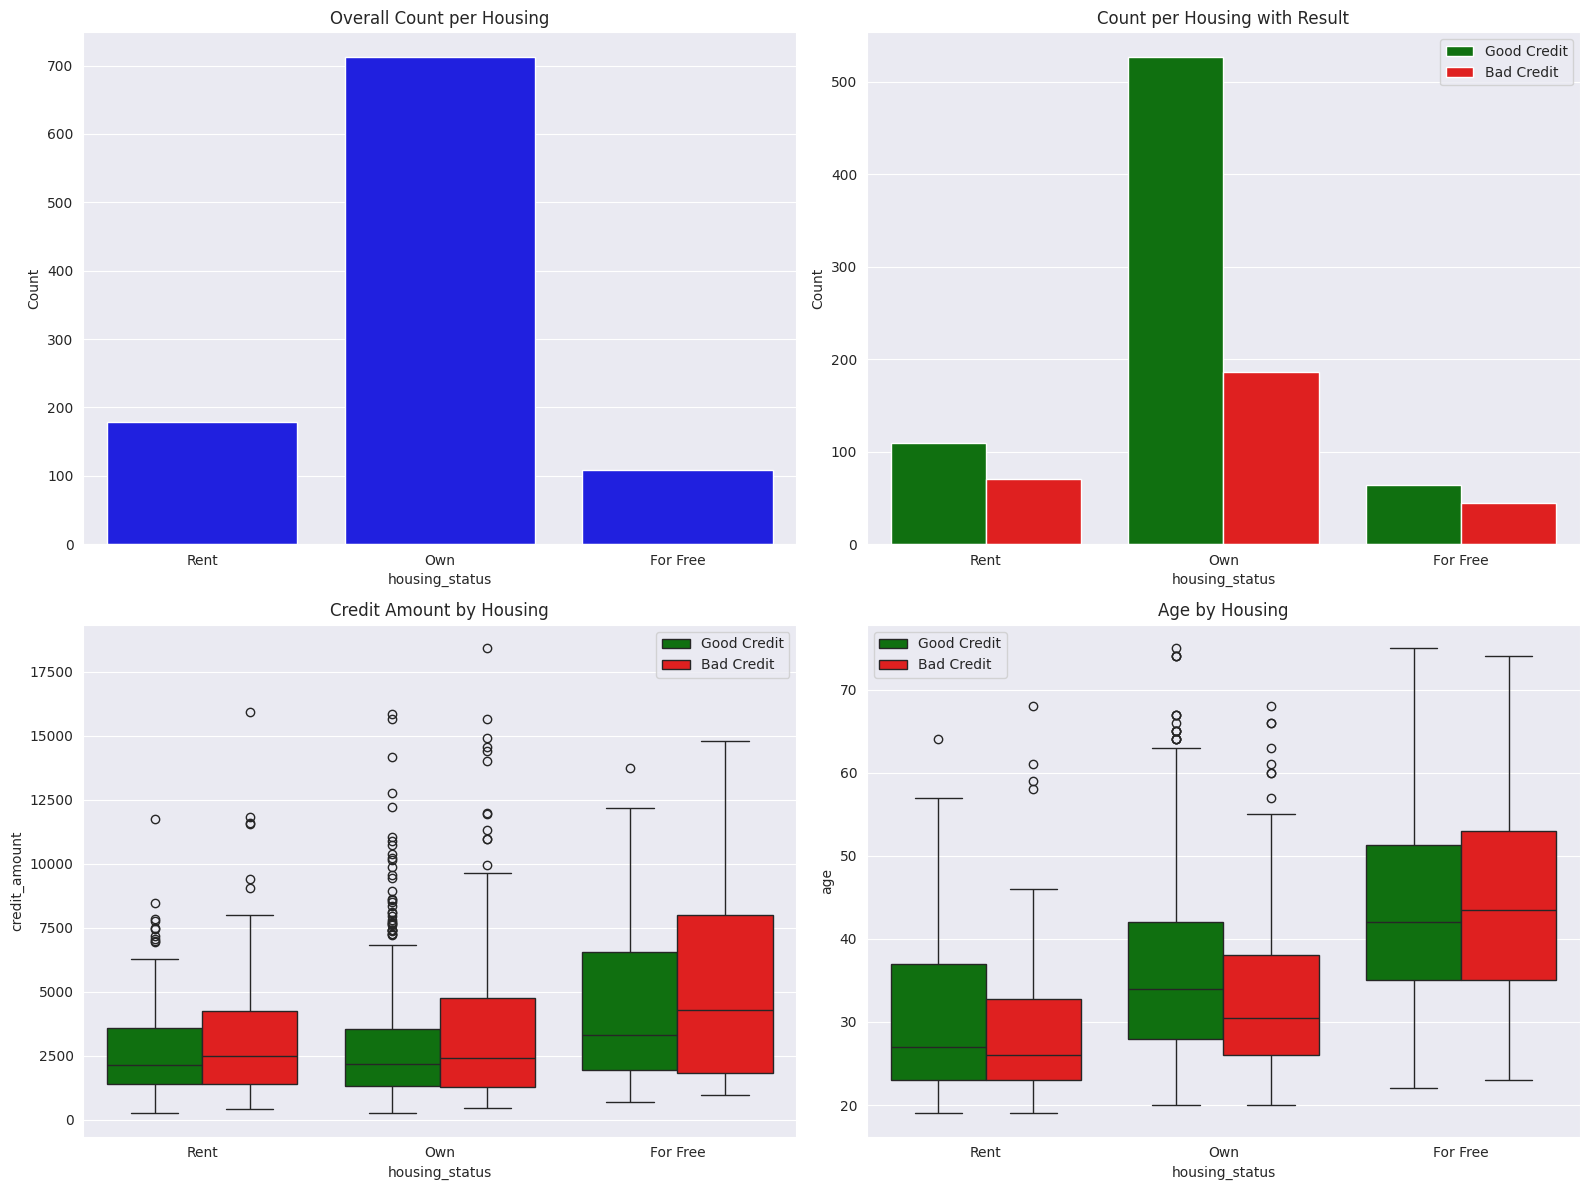

In [39]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

sns.countplot(x="housing_status", data=df_encode,color="blue", ax=axes[0, 0])
axes[0, 0].set_ylabel("Count")
axes[0, 0].set_xticks([0, 1, 2])
axes[0, 0].set_xticklabels(["Rent", "Own", "For Free"])
axes[0, 0].set_title('Overall Count per Housing')

sns.countplot(x="housing_status", data=df_encode, hue="result", palette=custom_palette, ax=axes[0, 1])
axes[0, 1].set_ylabel("Count")
axes[0, 1].set_xticks([0, 1, 2])
axes[0, 1].set_xticklabels(["Rent", "Own", "For Free"])
axes[0, 1].set_title('Count per Housing with Result')
axes[0, 1].legend(labels=["Good Credit", "Bad Credit"])

sns.boxplot(x="housing_status", y="credit_amount", data=df_encode, hue="result", palette=custom_palette, ax=axes[1, 0])
axes[1, 0].set_xticks([0, 1, 2])
axes[1, 0].set_xticklabels(["Rent", "Own", "For Free"])
axes[1, 0].set_title('Credit Amount by Housing')
l = axes[1, 0].legend()
l.get_texts()[0].set_text('Good Credit')
l.get_texts()[1].set_text('Bad Credit')

sns.boxplot(x="housing_status", y="age", data=df_encode, hue="result", palette=custom_palette, ax=axes[1, 1])
axes[1, 1].set_xticks([0, 1, 2])
axes[1, 1].set_xticklabels(["Rent", "Own", "For Free"])
axes[1, 1].set_title('Age by Housing')
l = axes[1, 1].legend()
l.get_texts()[0].set_text('Good Credit')
l.get_texts()[1].set_text('Bad Credit')

plt.tight_layout()
plt.show()


# 2 Unsupervised Exploration and Clustering

## 2.1 Dimensionality reduction for data visualization
### PCA

In [38]:

def compute_cum_var_PCA(df):
    pca = PCA(random_state=15)
    pca.fit(df)
    explained_variance = pca.explained_variance_ratio_
    cumul_exp_var = np.cumsum(explained_variance)
    perc_cumul_exp_var = cumul_exp_var * 100
    return perc_cumul_exp_var

def perform_PCA(df,perc_cumul_exp_var,labels):
    threshold = 90
    n_components_threshold = np.argmax(perc_cumul_exp_var >= threshold)
    pca = PCA(n_components=n_components_threshold, random_state=15)
    pca.fit(df)
    pca_result = pca.transform(df)
    df_pca = pd.DataFrame(pca_result) # df_pca will be used for performing unsupervised learning as it doesn't posses the labels.
    df_pca_with_labels = df_pca.copy()
    df_pca_with_labels['labels'] = labels 
    num_components = df_pca.shape[1]
    new_column_names = [f'Component {i}' for i in range(1, num_components + 1)]
    column_name_mapping = dict(zip(df_pca.columns, new_column_names))
    df_pca.rename(columns=column_name_mapping, inplace=True)
    df_pca_with_labels.rename(columns=column_name_mapping,inplace=True)
    return df_pca, df_pca_with_labels



In [39]:
df_normalized = pd.DataFrame(normalization(df_one_hot_encoded), columns=df_one_hot_encoded.columns)
labels = df_normalized['result']
df_normalized_for_pca = df_normalized.drop('result', axis=1) # we drop the labels before performing unsupervised learning
perc_cumul_exp_var = compute_cum_var_PCA(df_normalized_for_pca)

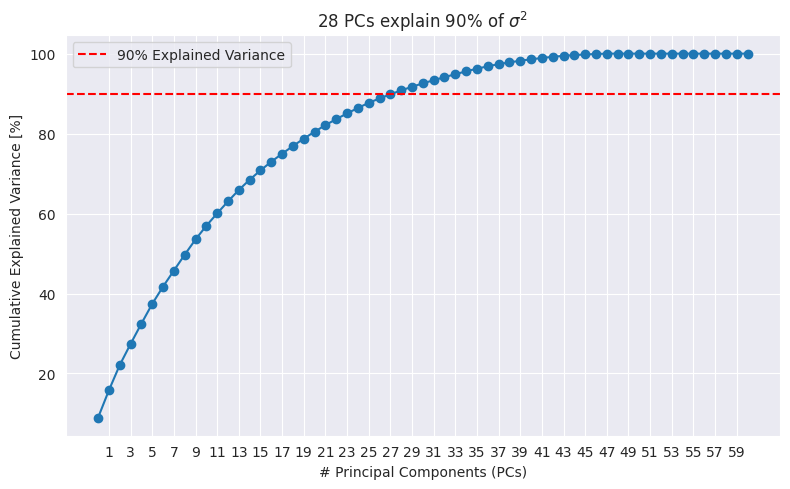

In [40]:
#Plot
plt.figure(figsize=(8, 5))
plt.plot(perc_cumul_exp_var, marker='o')
plt.axhline(y=90, color='r', linestyle='--', label='90% Explained Variance')
plt.xlabel('# Principal Components (PCs)')
plt.ylabel('Cumulative Explained Variance [%]')
plt.xticks(np.arange(1, 61, 2), np.arange(1, 61, 2))
plt.grid(True)
plt.title(f'28 PCs explain {round(perc_cumul_exp_var[27])}% of $\sigma^2$')
plt.legend()
plt.tight_layout()
plt.show()

In [41]:
df_normalized_for_pca

month_duration  credit_amount  installment_rate  resident_since  \
0          0.029412       0.050567          1.000000        1.000000   
1          0.647059       0.313690          0.333333        0.333333   
2          0.117647       0.101574          0.333333        0.666667   
3          0.558824       0.419941          0.333333        1.000000   
4          0.294118       0.254209          0.666667        1.000000   
..              ...            ...               ...             ...   
995        0.117647       0.081765          0.666667        1.000000   
996        0.382353       0.198470          1.000000        1.000000   
997        0.117647       0.030483          1.000000        1.000000   
998        0.602941       0.087763          1.000000        1.000000   
999        0.602941       0.238032          0.666667        1.000000   

          age  credit_number  people_liability  credit_history_A30  \
0    0.857143       0.333333               0.0                 0.0   
1    0.053571       0.000000               0.0                 0.0   
2    0.535714       0.000000               1.0                 0.0   
3    0.464286       0.000000               1.0                 0.0   
4    0.607143       0.333333               1.0                 0.0   
..        ...            ...               ...                 ...   
995  0.214286       0.000000               0.0                 0.0   
996  0.375000       0.000000               0.0                 0.0   
997  0.339286       0.000000               0.0                 0.0   
998  0.071429       0.000000               0.0                 0.0   
999  0.142857       0.000000               0.0                 0.0   

     credit_history_A31  credit_history_A32  ...  telephone_A192  job_A171  \
0                   0.0                 0.0  ...             1.0       0.0   
1                   0.0                 1.0  ...             0.0       0.0   
2                   0.0                 0.0  ...             0.0       0.0   
3                   0.0                 1.0  ...             0.0       0.0   
4                   0.0                 0.0  ...             0.0       0.0   
..                  ...                 ...  ...             ...       ...   
995                 0.0                 1.0  ...             0.0       0.0   
996                 0.0                 1.0  ...             1.0       0.0   
997                 0.0                 1.0  ...             0.0       0.0   
998                 0.0                 1.0  ...             1.0       0.0   
999                 0.0                 0.0  ...             0.0       0.0   

     job_A172  job_A173  job_A174  employment_status_A71  \
0         0.0       1.0       0.0                    0.0   
1         0.0       1.0       0.0                    0.0   
2         1.0       0.0       0.0                    0.0   
3         0.0       1.0       0.0                    0.0   
4         0.0       1.0       0.0                    0.0   
..        ...       ...       ...                    ...   
995       1.0       0.0       0.0                    0.0   
996       0.0       0.0       1.0                    0.0   
997       0.0       1.0       0.0                    0.0   
998       0.0       1.0       0.0                    0.0   
999       0.0       1.0       0.0                    1.0   

     employment_status_A72  employment_status_A73  employment_status_A74  \
0                      0.0                    0.0                    0.0   
1                      0.0                    1.0                    0.0   
2                      0.0                    0.0                    1.0   
3                      0.0                    0.0                    1.0   
4                      0.0                    1.0                    0.0   
..                     ...                    ...                    ...   
995                    0.0                    0.0                    1.0   
996                    0.0       

In [42]:
df_pca, df_pca_with_labels = perform_PCA(df_normalized_for_pca, perc_cumul_exp_var,labels)
df_pca

Component 1  Component 2  Component 3  Component 4  Component 5  \
0       1.093896    -0.671380     0.071016     0.303321     0.084120   
1      -1.416504     0.091915    -0.554415    -0.452032    -0.045154   
2      -0.057365    -1.337977     0.891653    -0.151721     0.760244   
3      -0.338916     0.466398     1.126655     0.462162    -1.028940   
4       0.126734     0.099974     1.483676     0.675505    -0.634898   
..           ...          ...          ...          ...          ...   
995    -1.110719    -0.061561    -0.003418    -0.086624     0.626471   
996     0.324920     1.041202     0.087036    -0.856791     0.197068   
997    -0.014915    -0.808939    -0.476231     0.140822    -0.916646   
998     0.572306     0.895386     0.367433     0.039533    -0.977373   
999     0.340852    -0.624195    -0.134620     0.239113    -0.214858   

     Component 6  Component 7  Component 8  Component 9  Component 10  ...  \
0      -0.110836    -0.417682    -0.405376    -0.494925      1.206834  ...   
1       0.024574    -0.116422    -0.824057     0.472696      0.642347  ...   
2       0.422292    -0.351408    -0.055935    -0.264485     -0.330170  ...   
3      -0.841163    -0.381973     0.710002    -0.219618      0.283003  ...   
4      -0.680913    -0.411219    -0.133552     1.048467     -0.340218  ...   
..           ...          ...          ...          ...           ...  ...   
995     0.668442    -0.488642     0.089488    -0.819151     -0.394131  ...   
996    -0.279205    -0.891673     0.673748    -0.135763     -0.094919  ...   
997    -0.492958     0.034228    -0.701503    -1.033107     -0.417110  ...   
998    -0.702487    -1.093899    -0.798148     0.352826      0.164896  ...   
999    -0.231716     1.296259    -0.038554     0.605821      0.071682  ...   

     Component 19  Component 20  Component 21  Component 22  Component 23  \
0        0.037877     -0.067467     -0.242851      0.062089     -0.220678   
1        0.421547      0.103522     -0.273862     -0.098651     -0.408392   
2        0.549603     -0.284337     -0.028393      0.226009      0.037133   
3        0.556886     -0.143265      0.239706     -0.287579      0.473490   
4        0.397019     -0.104035     -0.225484     -0.178999     -0.100805   
..            ...           ...           ...           ...           ...   
995     -0.129623     -0.437023     -0.115081      0.262249      0.026290   
996     -0.208507      0.778086     -0.018580      0.199480      0.369489   
997     -0.047900     -0.027274     -0.146496     -0.019045     -0.011524   
998      0.013672     -0.548532      0.144102      0.244398     -0.012721   
999     -0.125283      0.241408      0.404041     -0.359938      0.355454   

     Component 24  Component 25  Component 26  Component 27  Component 28  
0       -0.020623     -0.278099     -0.000432      0.020777     -0.150915  
1        0.217765     -0.063721      0.007565     -0.105374     -0.240531  
2        0.300967      0.289490      0.059597      0.239646     -0.031608  
3       -0.367198      0.479245      0.389294      0.295266      0.151930  
4       -0.529538      0.305432      0.628784     -0.048527      0.065381  
..            ...           ...           ...           ...           ...  
995     -0.178407     -0.096717      0.280308     -0.034068      0.063873  
996      0.758680     -0.045199      0.388745     -0.023048      0.401431  
997     -0.031578     -0.212834      0.135810      0.105246     -0.035551  
998     -0.078317     -0.326513      0.036055      0.044977     -0.149218  
999      0.943952     -0.553913      0.495968     -0.034388     -0.004494  

[1000 rows x 28 columns]

In [43]:
df_pca_with_labels

Component 1  Component 2  Component 3  Component 4  Component 5  \
0       1.093896    -0.671380     0.071016     0.303321     0.084120   
1      -1.416504     0.091915    -0.554415    -0.452032    -0.045154   
2      -0.057365    -1.337977     0.891653    -0.151721     0.760244   
3      -0.338916     0.466398     1.126655     0.462162    -1.028940   
4       0.126734     0.099974     1.483676     0.675505    -0.634898   
..           ...          ...          ...          ...          ...   
995    -1.110719    -0.061561    -0.003418    -0.086624     0.626471   
996     0.324920     1.041202     0.087036    -0.856791     0.197068   
997    -0.014915    -0.808939    -0.476231     0.140822    -0.916646   
998     0.572306     0.895386     0.367433     0.039533    -0.977373   
999     0.340852    -0.624195    -0.134620     0.239113    -0.214858   

     Component 6  Component 7  Component 8  Component 9  Component 10  ...  \
0      -0.110836    -0.417682    -0.405376    -0.494925      1.206834  ...   
1       0.024574    -0.116422    -0.824057     0.472696      0.642347  ...   
2       0.422292    -0.351408    -0.055935    -0.264485     -0.330170  ...   
3      -0.841163    -0.381973     0.710002    -0.219618      0.283003  ...   
4      -0.680913    -0.411219    -0.133552     1.048467     -0.340218  ...   
..           ...          ...          ...          ...           ...  ...   
995     0.668442    -0.488642     0.089488    -0.819151     -0.394131  ...   
996    -0.279205    -0.891673     0.673748    -0.135763     -0.094919  ...   
997    -0.492958     0.034228    -0.701503    -1.033107     -0.417110  ...   
998    -0.702487    -1.093899    -0.798148     0.352826      0.164896  ...   
999    -0.231716     1.296259    -0.038554     0.605821      0.071682  ...   

     Component 20  Component 21  Component 22  Component 23  Component 24  \
0       -0.067467     -0.242851      0.062089     -0.220678     -0.020623   
1        0.103522     -0.273862     -0.098651     -0.408392      0.217765   
2       -0.284337     -0.028393      0.226009      0.037133      0.300967   
3       -0.143265      0.239706     -0.287579      0.473490     -0.367198   
4       -0.104035     -0.225484     -0.178999     -0.100805     -0.529538   
..            ...           ...           ...           ...           ...   
995     -0.437023     -0.115081      0.262249      0.026290     -0.178407   
996      0.778086     -0.018580      0.199480      0.369489      0.758680   
997     -0.027274     -0.146496     -0.019045     -0.011524     -0.031578   
998     -0.548532      0.144102      0.244398     -0.012721     -0.078317   
999      0.241408      0.404041     -0.359938      0.355454      0.943952   

     Component 25  Component 26  Component 27  Component 28  labels  
0       -0.278099     -0.000432      0.020777     -0.150915     0.0  
1       -0.063721      0.007565     -0.105374     -0.240531     1.0  
2        0.289490      0.059597      0.239646     -0.031608     0.0  
3        0.479245      0.389294      0.295266      0.151930     0.0  
4        0.305432      0.628784     -0.048527      0.065381     1.0  
..            ...           ...           ...           ...     ...  
995     -0.096717      0.280308     -0.034068      0.063873     0.0  
996     -0.045199      0.388745     -0.023048      0.401431     0.0  
997     -0.212834      0.135810      0.105246     -0.035551     0.0  
998     -0.326513      0.036055      0.044977     -0.149218     1.0  
999     -0.553913      0.495968     -0.034388     -0.004494     0.0  

[1000 rows x 29 columns]

### t-SNE

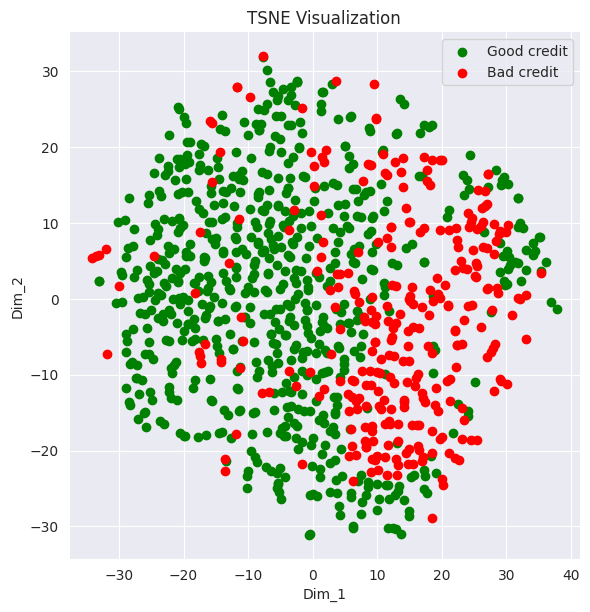

In [44]:
model = TSNE(n_components=2, learning_rate=100, perplexity=45, n_iter=2000, metric = "cityblock", random_state=15,n_jobs=-1)
tsne_data = model.fit_transform(df_pca_with_labels)
tsne_df = pd.DataFrame(data=np.column_stack((tsne_data, labels)), columns=["Dim_1", "Dim_2", "label"])
tsne_df['label'] = tsne_df['label'].astype(int)
sns.FacetGrid(tsne_df, hue="label", height=6,palette=["green","red"]).map(plt.scatter, 'Dim_1', 'Dim_2')
plt.title(f"TSNE Visualization")
plt.legend(labels=["Good credit", "Bad credit"])
plt.show()

## 2.2 Unsupervised Data Analysis

In [45]:
df_clustering = df_pca.copy() 
y_clustering = pd.DataFrame(df_pca_with_labels['labels'].copy())

### Hard Clustering: KMeans

In [46]:
def perform_k_means(df, max_range, title):
    kmeans_results = []
    for k in range(2,max_range+1):
        kmeans_results.append(KMeans(n_clusters=k, init='k-means++', n_init=5, random_state=13).fit(df))

    fig, axs = plt.subplots(1,2, figsize=(8, 3.5))

    axs[0].plot(
        [k for k in range(2,max_range+1)],
        [result.inertia_ for result in kmeans_results]
    )
    axs[0].set_xlabel("Number of clusters k")
    axs[0].set_ylabel("Clustering error")
    axs[0].grid()
    axs[0].set_title(f"{title}: Clustering Error")

    axs[1].plot(
        [k for k in range(2,max_range+1)],
        [silhouette_score(df, result.labels_) for result in kmeans_results]
    )
    axs[1].set_xlabel("Number of clusters k")
    axs[1].set_ylabel("Silhouette")
    axs[1].grid()
    axs[1].set_title(f"{title}: Silhouette")

    plt.tight_layout()
    plt.show()

In [47]:
def tuning_k_means(df,labels,max_range=2):
    #Iterating over the number of cluster, in order to find the best hyparameters with scikit standardization
    best_silhouette = -1  
    best_params = None

    for n_clusters in range(2, max_range+1): 
        kmeans = KMeans(n_clusters=n_clusters,init='k-means++', n_init=5, random_state=13)
        cluster_labels = kmeans.fit_predict(df)

        silhouette = silhouette_score(df, cluster_labels)
        ri = rand_score(np.ravel(labels), cluster_labels)
        ari = adjusted_rand_score(np.ravel(labels), cluster_labels)

        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_k = n_clusters
    kmeans = KMeans(n_clusters=best_k, init='k-means++', n_init=5, random_state=13)
    cluster_labels = kmeans.fit_predict(df)
    silhouette = silhouette_score(df, cluster_labels)
    ri = rand_score(np.ravel(labels), cluster_labels)
    ari = adjusted_rand_score(np.ravel(labels), cluster_labels)

    print(f'k-Means with {best_k} clusters')
    (unique, counts)=np.unique( cluster_labels, return_counts=True)
    print("Size of each cluster: ", counts)
    print(f'k_means clustering error: {round(kmeans.inertia_, 2)}')
    print(f'Silhouette: {round(silhouette, 2)}')
    print(f'RI: {round(ri, 2)}')
    print(f'ARI: {round(ari, 2)}')
    cc = kmeans.cluster_centers_
    if (best_k == 2):
        centroids = []
        for centroid in cc:
            var_influence = pd.DataFrame([centroid], columns=df.columns)
            centroids.append(var_influence)
        centroid_distances = np.abs(centroids[0] - centroids[1])
        feature_distances = centroid_distances.values[0]
        top_features_indices = np.argsort(feature_distances)[-3:]
        top_features = df.columns[top_features_indices]
        print("Top 3 features with the highest distance between the 2 centroids:", top_features.values)
    return cluster_labels

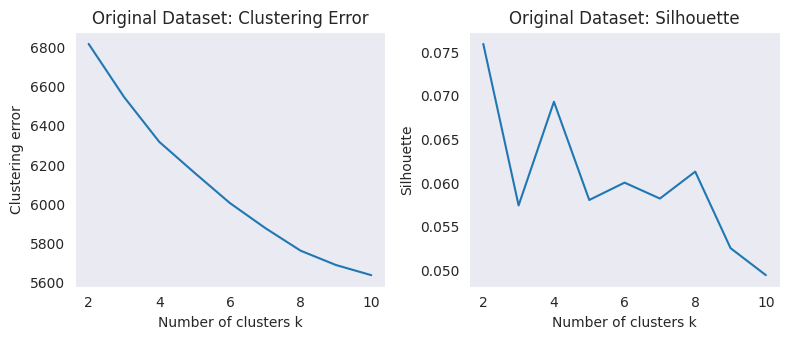

In [52]:
perform_k_means(df_normalized_for_pca,10, "Original Dataset") #whole dataset before PCA. Just normalized with MinMaxScaler()

In [53]:
df_normalized_cl_labels = tuning_k_means(df_normalized_for_pca,labels,10)

k-Means with 2 clusters
Size of each cluster:  [596 404]
k_means clustering error: 6816.85
Silhouette: 0.08
RI: 0.5
ARI: -0.0
Top 3 features with the highest distance between the 2 centroids: ['job_A174' 'telephone_A191' 'telephone_A192']


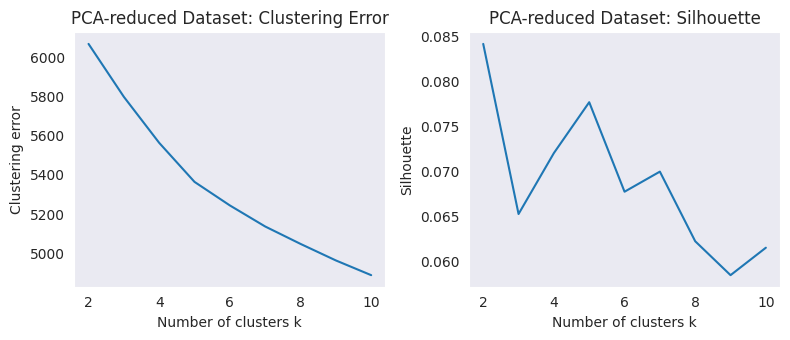

In [50]:
perform_k_means(df_clustering,10, "PCA-reduced Dataset")  #PCA dataset.

In [54]:
df_clustering_cl_labels = tuning_k_means(df_clustering,labels,10)

k-Means with 2 clusters
Size of each cluster:  [596 404]
k_means clustering error: 6067.13
Silhouette: 0.08
RI: 0.5
ARI: -0.0
Top 3 features with the highest distance between the 2 centroids: ['Component 3' 'Component 2' 'Component 1']


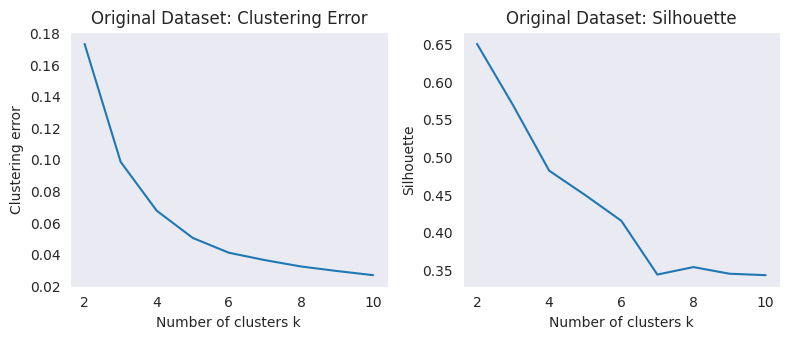

In [55]:
#Since the result of the silhouette score is not high, we try to normalize data in a different way using the normalize() function from sklearn
df_one_hot_without_labels = df_one_hot_encoded.copy().drop('result',axis=1)
df_start_scaled = normalize(df_one_hot_without_labels)  
df_start_scaled = pd.DataFrame(df_start_scaled, columns=df_one_hot_without_labels.columns)
perform_k_means(df_start_scaled,10, "Original Dataset")

In [56]:
df_start_scaled_cl_labels = tuning_k_means(df_start_scaled,labels,10)

k-Means with 2 clusters
Size of each cluster:  [851 149]
k_means clustering error: 0.17
Silhouette: 0.65
RI: 0.53
ARI: -0.02
Top 3 features with the highest distance between the 2 centroids: ['installment_rate' 'month_duration' 'age']


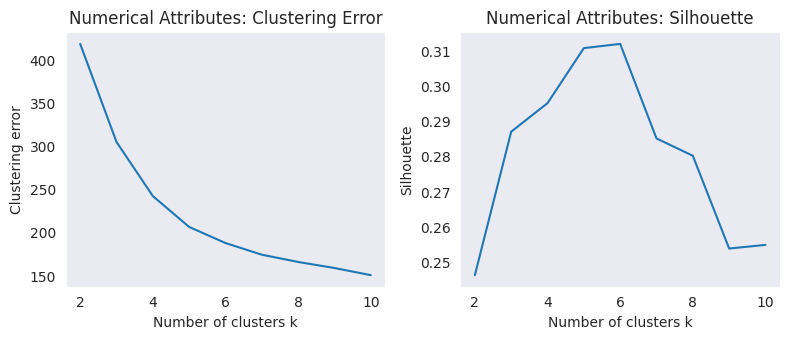

In [57]:
# Additionally, with the starting normalization method (MinMaxScaler) we perform clustering only on the numerical features
df_numerical_clustering = pd.DataFrame(normalization(df_one_hot_encoded[numerical_attributes]), columns=numerical_attributes)
perform_k_means(df_numerical_clustering,10,"Numerical Attributes")

In [58]:
df_numerical_cl_labels = tuning_k_means(df_numerical_clustering,labels,10)

k-Means with 6 clusters
Size of each cluster:  [303  56 138 241  99 163]
k_means clustering error: 188.32
Silhouette: 0.31
RI: 0.45
ARI: -0.0


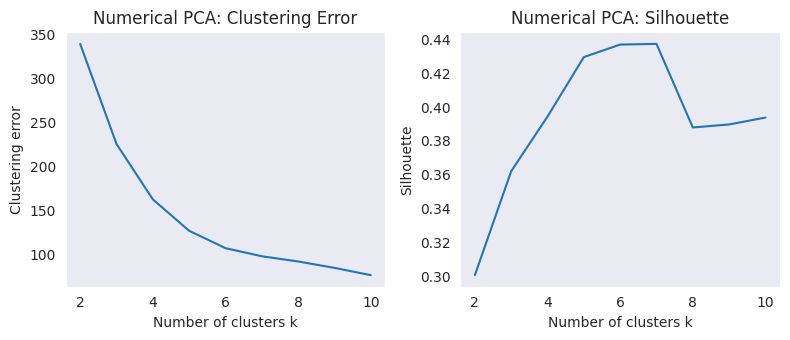

In [59]:
# Moreover, we perform PCA on the numerical features to see if the clustering improves. Still MinMaxScaler() used as normalization method
perc_cumul_exp_var_numerical = compute_cum_var_PCA(df_numerical_clustering)
df_numerical_pca, df_numerical_pca_with_labels = perform_PCA(df_numerical_clustering,perc_cumul_exp_var_numerical,labels)
perform_k_means(df_numerical_pca,10,"Numerical PCA")


In [60]:
df_numerical_cl_pca = tuning_k_means(df_numerical_pca,labels,10)

k-Means with 7 clusters
Size of each cluster:  [303 163 241  64 138  41  50]
k_means clustering error: 97.99
Silhouette: 0.44
RI: 0.45
ARI: -0.0


### Soft Clustering: GMM

In [61]:
def perform_gmm(df, labels, string, range_loop=2):
    n_cluster_list = []
    shs_list = []
    ri_list = []
    ari_list = []
    log_l_list = []
    cl_labels_gmm_list = []
    
    if range_loop!=2:
        fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    
    for n_clusters in range(2, range_loop+1):
        gmm = GaussianMixture(n_components=n_clusters, n_init=5, random_state=13)
        cl_labels_gmm = gmm.fit_predict(df)
        silhouette = silhouette_score(df, cl_labels_gmm)
        n_cluster_list.append(n_clusters)
        shs_list.append(silhouette)
        ri_list.append(rand_score(np.ravel(labels), cl_labels_gmm))
        ari_list.append(adjusted_rand_score(np.ravel(labels), cl_labels_gmm))
        log_l_list.append(gmm.score(df))
        cl_labels_gmm_list.append(cl_labels_gmm)

    
    best_sh = np.max(shs_list)
    best_n = n_cluster_list[np.argmax(shs_list)]
    print("best k for GMM: ",best_n, " with corresponding silhouette: ", best_sh)
    (unique, counts)=np.unique(cl_labels_gmm_list[best_n-2], return_counts=True)
    print("Size of each cluster: ", counts)
    print("")
    if (range_loop!=2):
        axs[0].plot(n_cluster_list, shs_list, marker='o', markersize=5)
        axs[0].scatter(best_n, best_sh, color='r', marker='x', s=90)
        axs[0].grid()
        axs[0].set_xlabel('Number of clusters')
        axs[0].set_ylabel('Silhouette score')
        axs[0].set_title(f'Silhouette Score vs Number of Clusters ({string} Dataset)')
        
        axs[1].plot(n_cluster_list, log_l_list, marker='o', markersize=5)
        axs[1].grid()
        axs[1].set_xlabel('Number of clusters')
        axs[1].set_ylabel('GMM total log-likelihood score')
        axs[1].set_title(f'GMM Total Log-Likelihood Score vs Number of Clusters ({string} Dataset)')
        
        axs[2].plot(n_cluster_list, ari_list, marker='o', markersize=5)
        axs[2].grid()
        axs[2].set_xlabel('Number of clusters')
        axs[2].set_ylabel('ARI')
        axs[2].set_title(f'Adjusted Rand Index (ARI) vs Number of Clusters ({string} Dataset)')
        
        plt.tight_layout()
        plt.show()
        
    if (best_n == 2):
        gmm = GaussianMixture(n_components=n_clusters, n_init=5, random_state=13)
        gmm.fit(df)
        cc = gmm.means_
        centroids = []
        for centroid in cc:
            var_influence = pd.DataFrame([centroid], columns=df.columns)
            centroids.append(var_influence)
        centroid_distances = np.abs(centroids[0] - centroids[1])
        feature_distances = centroid_distances.values[0]
        top_features_indices = np.argsort(feature_distances)[-3:]
        top_features = df.columns[top_features_indices]
        print("Top 3 features with the highest distance between the 2 centroids:", top_features.values)
    return cl_labels_gmm_list[best_n-2]


best k for GMM:  2  with corresponding silhouette:  0.07085853404733619
Size of each cluster:  [713 287]


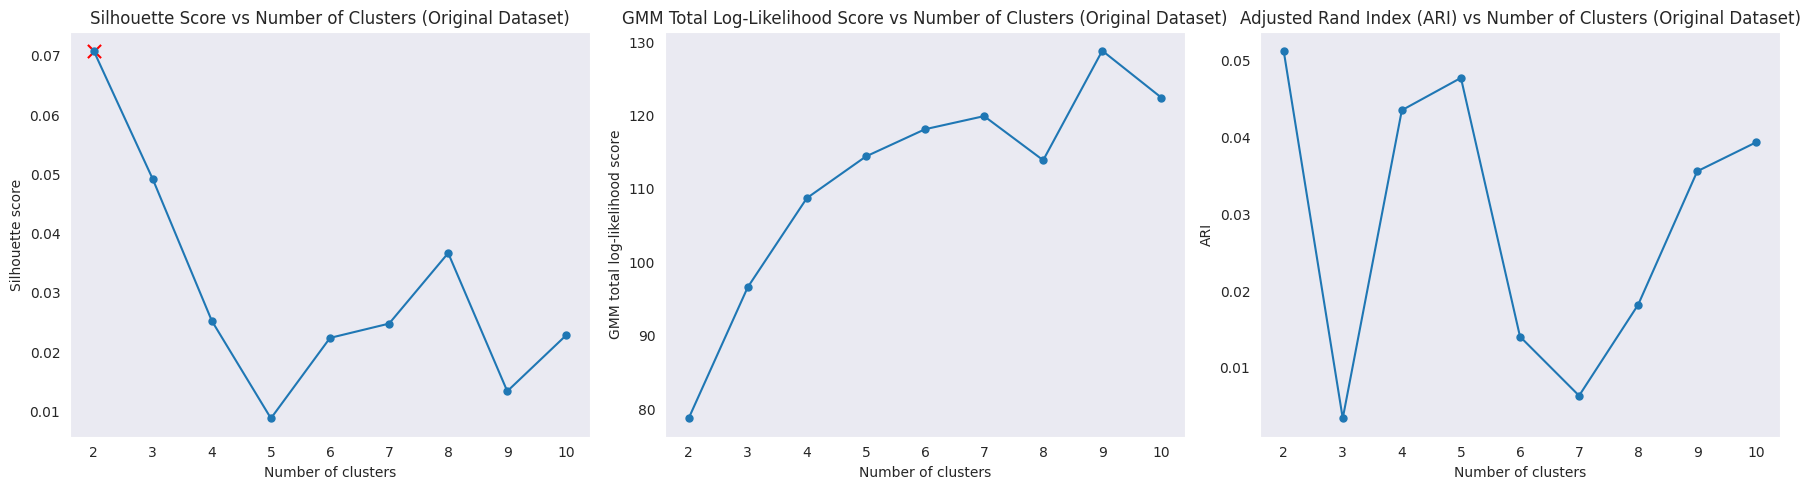

Top 3 features with the highest distance between the 2 centroids: ['debts_status_A101' 'existing_account_A14' 'existing_account_A11']


In [62]:
cl_gmm_normalized = perform_gmm(df_normalized_for_pca,labels,"Original",10)  #original dataset, just normalized with MinMaxScaler()

best k for GMM:  2  with corresponding silhouette:  0.06706784496672126
Size of each cluster:  [548 452]


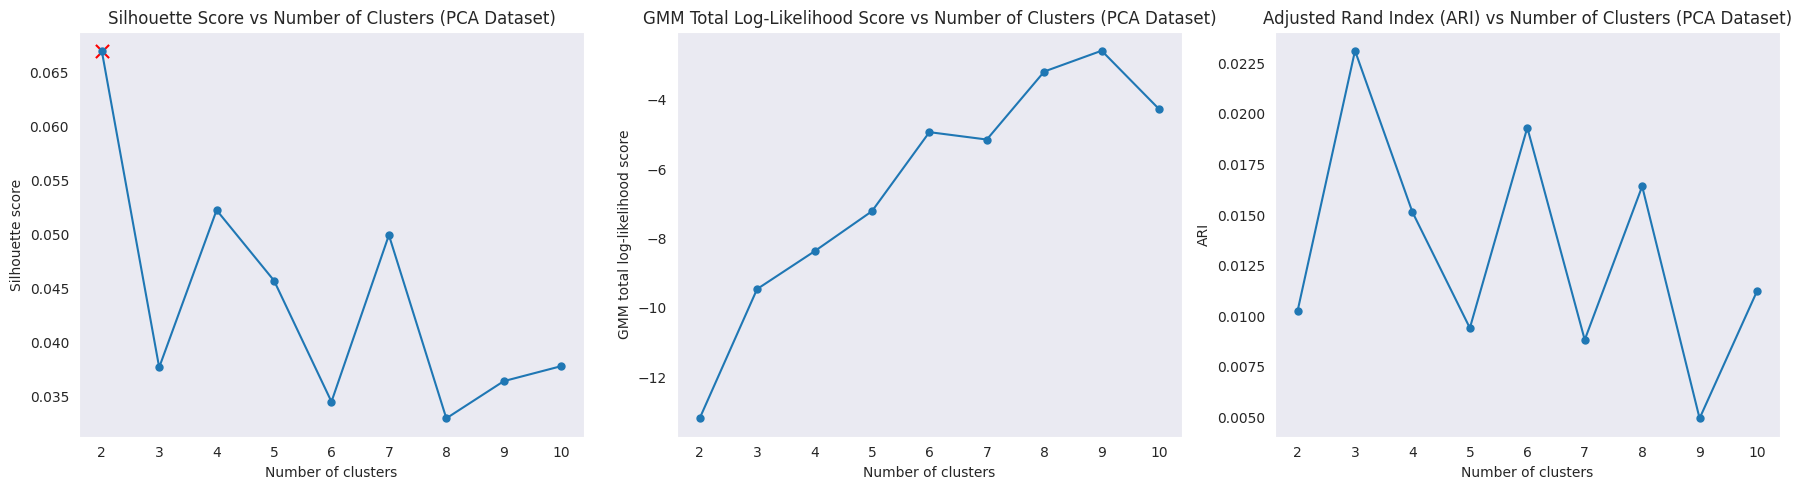

Top 3 features with the highest distance between the 2 centroids: ['Component 8' 'Component 5' 'Component 1']


In [63]:
cl_gmm_clustering = perform_gmm(df_clustering,labels,"PCA",10) # PCA-reduced Dataset.

best k for GMM:  2  with corresponding silhouette:  0.7479895777956633
Size of each cluster:  [970  30]


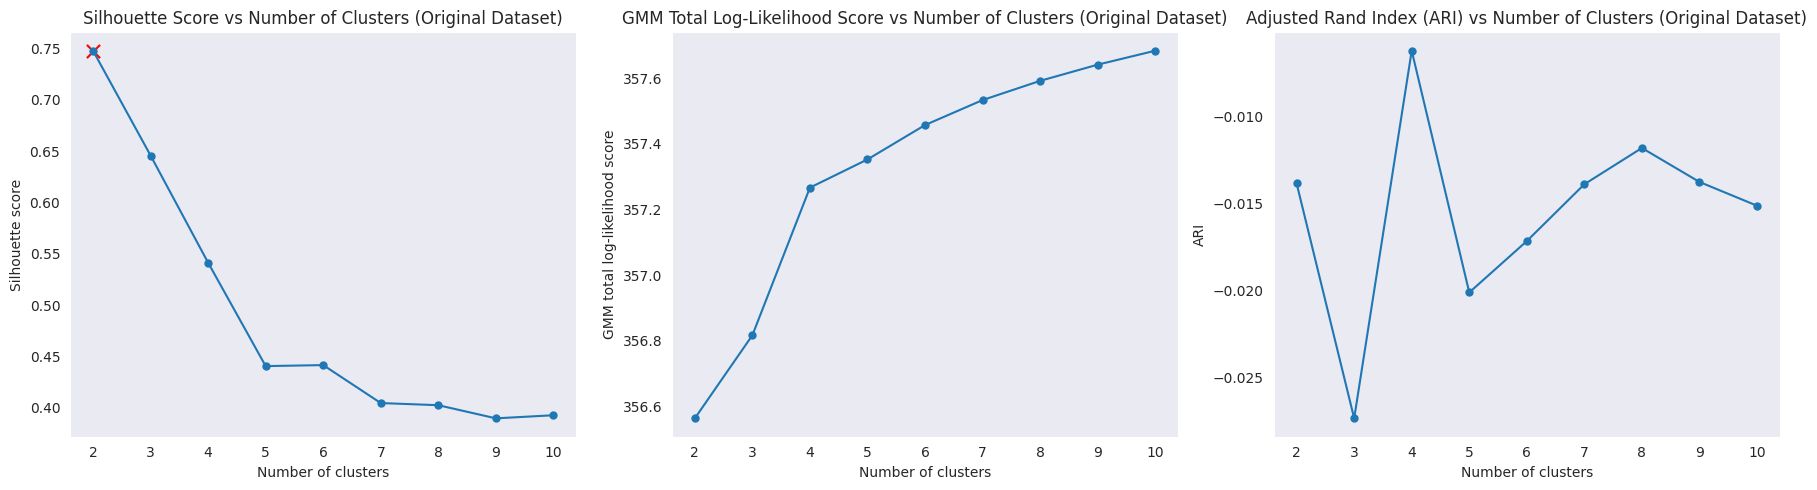

Top 3 features with the highest distance between the 2 centroids: ['installment_rate' 'month_duration' 'age']


In [64]:
# with another normalization 
cl_gmm_start_scaled = perform_gmm(df_start_scaled,labels,"Original",10) # Original Dataset with normalize() normalization.

best k for GMM:  3  with corresponding silhouette:  0.25180487571422844
Size of each cluster:  [155 401 444]


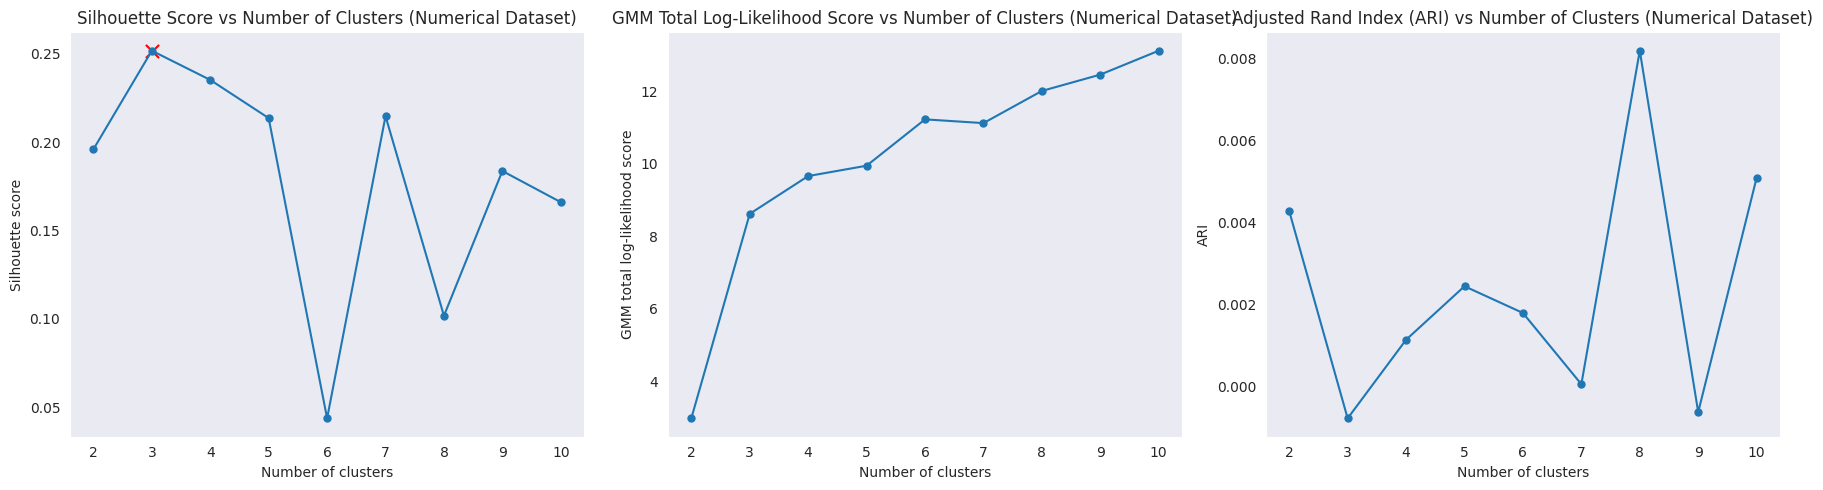

In [65]:
cl_gmm_numerical = perform_gmm(df_numerical_clustering,labels, "Numerical",10) # Numerical Features with starting MinMaxScaler() normalization

best k for GMM:  8  with corresponding silhouette:  0.31368482331536107
Size of each cluster:  [ 52 164 199 152 231  45  99  58]


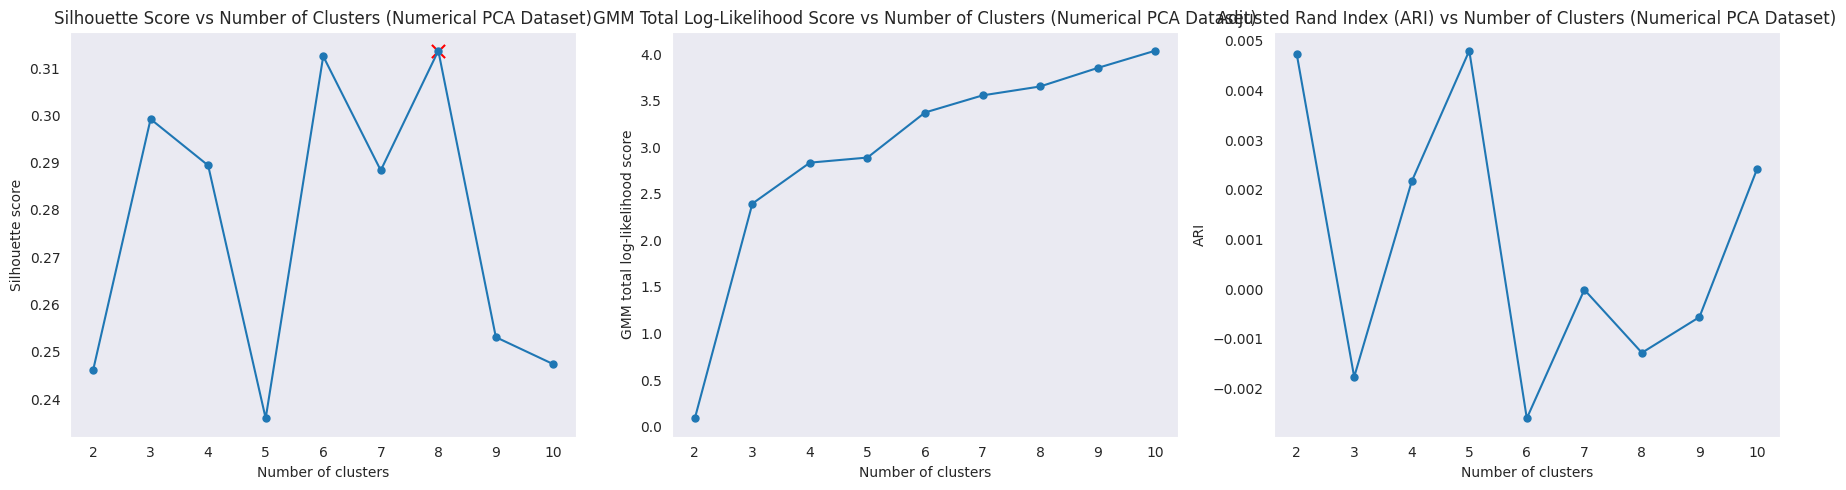

In [66]:
cl_gmm_numerical_pca = perform_gmm(df_numerical_pca,labels, "Numerical PCA",10) 

In [67]:
def compare_clustering(df, kmeans_labels, gmm_labels):
    pca = PCA(n_components=2)
    df_pca = pd.DataFrame(pca.fit_transform(df), columns=['PCA1', 'PCA2'])

    df_visualization = pd.DataFrame({
        'PCA1': df_pca['PCA1'],
        'PCA2': df_pca['PCA2'],
        'KMeans_Cluster': kmeans_labels,
        'GMM_Cluster': gmm_labels
    })

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    kmeans_palette = sns.color_palette("tab10", len(df_visualization['KMeans_Cluster'].unique()))
    sns.scatterplot(data=df_visualization, x='PCA1', y='PCA2', hue='KMeans_Cluster', palette=kmeans_palette)
    plt.title('KMeans Clustering Results')
    plt.legend(title='Cluster')

    plt.subplot(1, 2, 2)
    gmm_palette = sns.color_palette("tab10", len(df_visualization['GMM_Cluster'].unique()))
    sns.scatterplot(data=df_visualization, x='PCA1', y='PCA2', hue='GMM_Cluster', palette=gmm_palette)
    plt.title('GMM Clustering Results')
    plt.legend(title='Cluster')

    plt.tight_layout()
    plt.show()


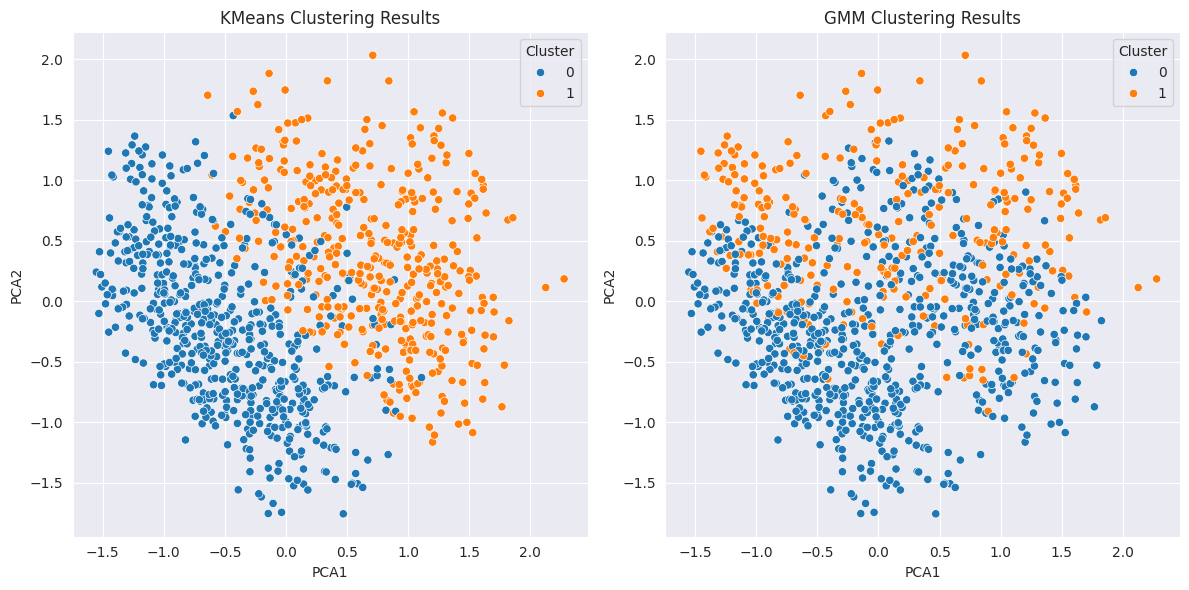

In [68]:
compare_clustering(df_normalized_for_pca, df_normalized_cl_labels,cl_gmm_normalized)

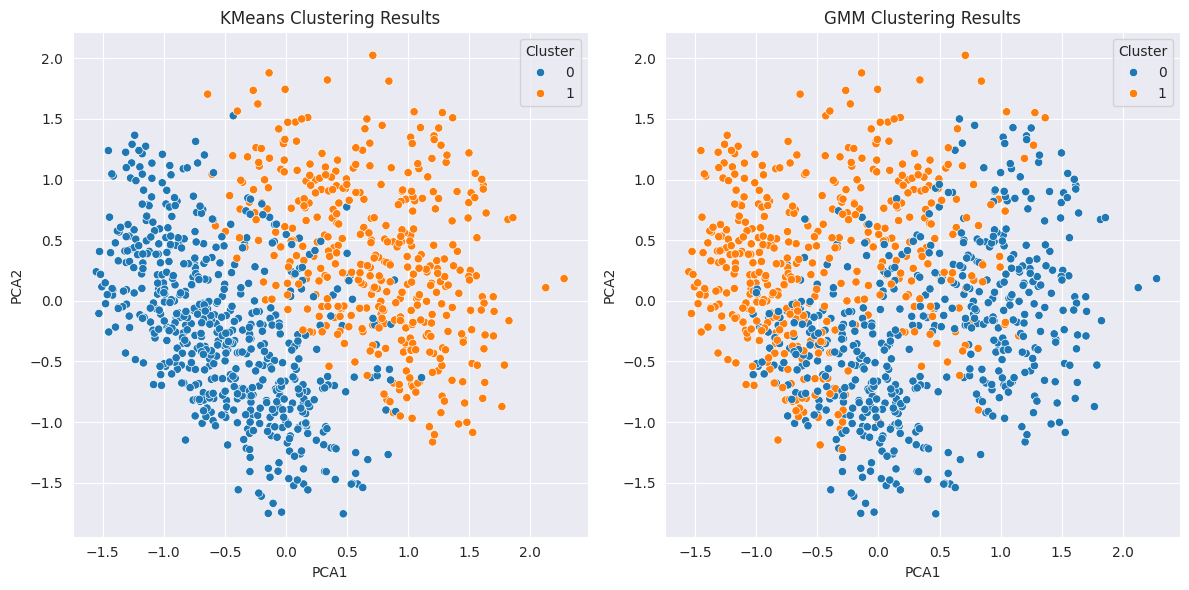

In [69]:
compare_clustering(df_clustering,df_clustering_cl_labels,cl_gmm_clustering)

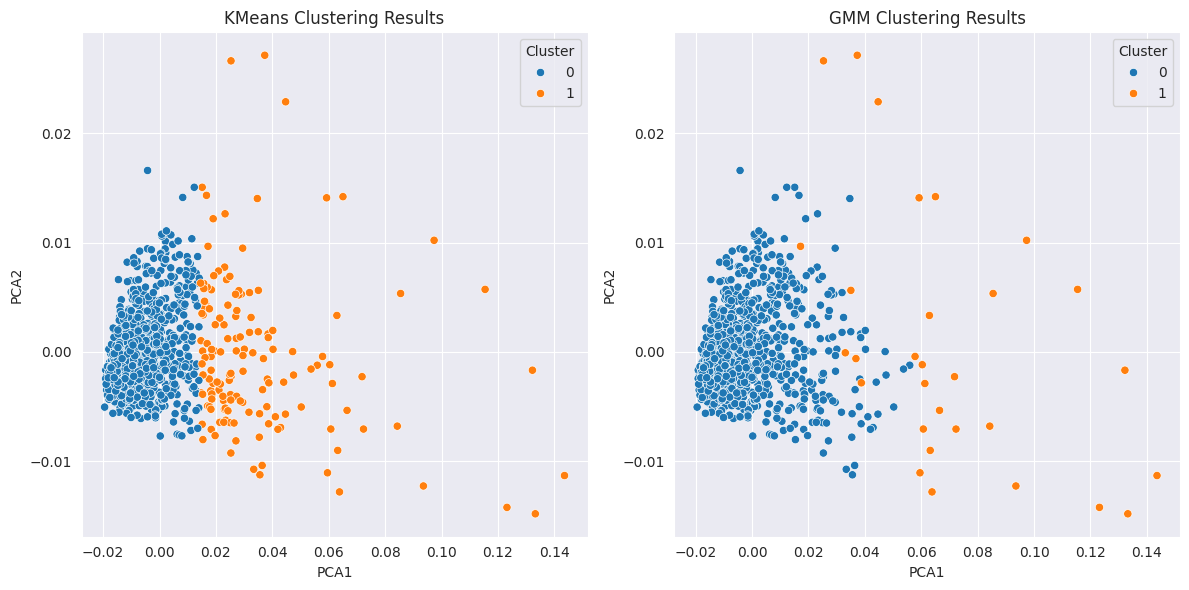

In [71]:
compare_clustering(df_start_scaled,df_start_scaled_cl_labels,cl_gmm_start_scaled)

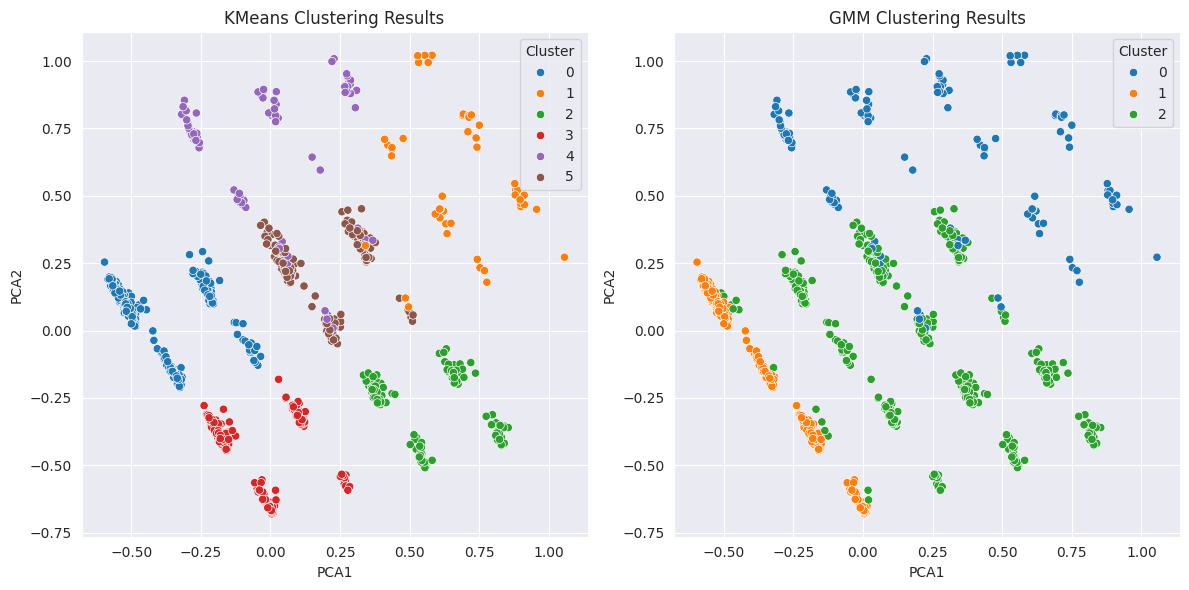

In [72]:
compare_clustering(df_numerical_clustering,df_numerical_cl_labels,cl_gmm_numerical)

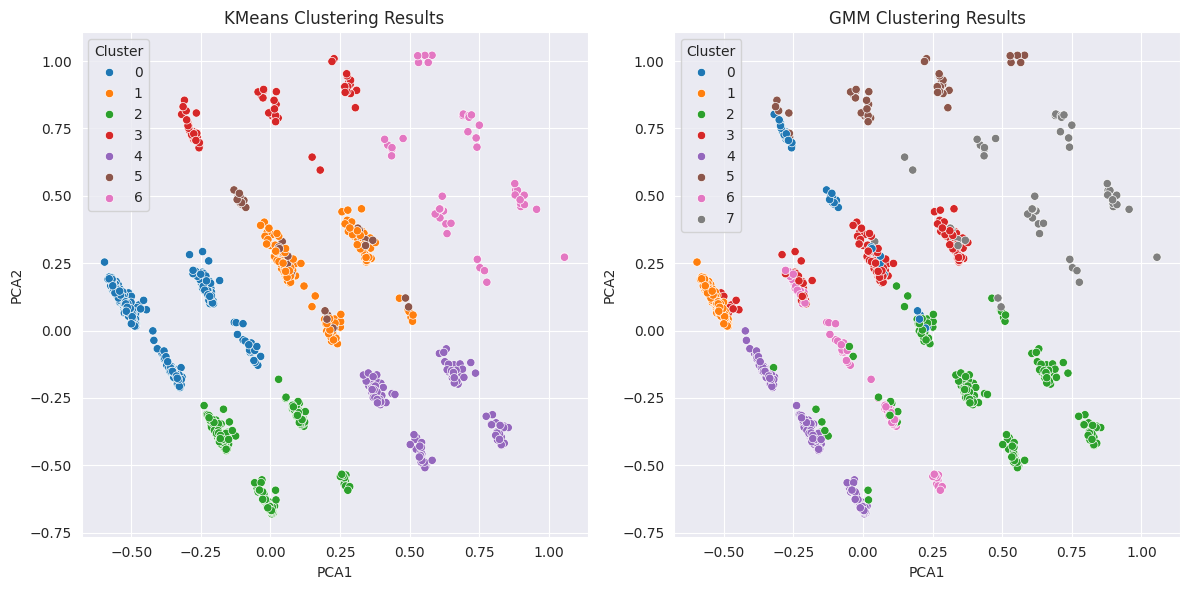

In [73]:
compare_clustering(df_numerical_pca,df_numerical_cl_pca,cl_gmm_numerical_pca)

In [74]:

def compute_purity(cl_labels_gmm, cl_labels_kmeans, actual_labels):
    matrix_gmm = confusion_matrix(actual_labels, cl_labels_gmm)
    matrix_kmeans = confusion_matrix(actual_labels, cl_labels_kmeans)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.heatmap(matrix_kmeans, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix - K-means Clustering")
   
    plt.subplot(1, 2, 2)
    sns.heatmap(matrix_gmm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix - GMM Clustering")
    plt.tight_layout()
    plt.show()
    
    num_clusters_kmeans = len(set(cl_labels_kmeans))
    for cluster in range(num_clusters_kmeans):
        cluster_samples = actual_labels[cl_labels_kmeans == cluster]
        class_counts = np.bincount(cluster_samples)
        purity = np.max(class_counts) / np.sum(class_counts)
        print(f"Purity of cluster {cluster} (K-means): {purity:.2f}")
      
    num_clusters_gmm = len(set(cl_labels_gmm))
    for cluster in range(num_clusters_gmm):
        cluster_samples = actual_labels[cl_labels_gmm == cluster]
        class_counts = np.bincount(cluster_samples)
        purity = np.max(class_counts) / np.sum(class_counts)
        print(f"Purity of cluster {cluster} (GMM): {purity:.2f}")


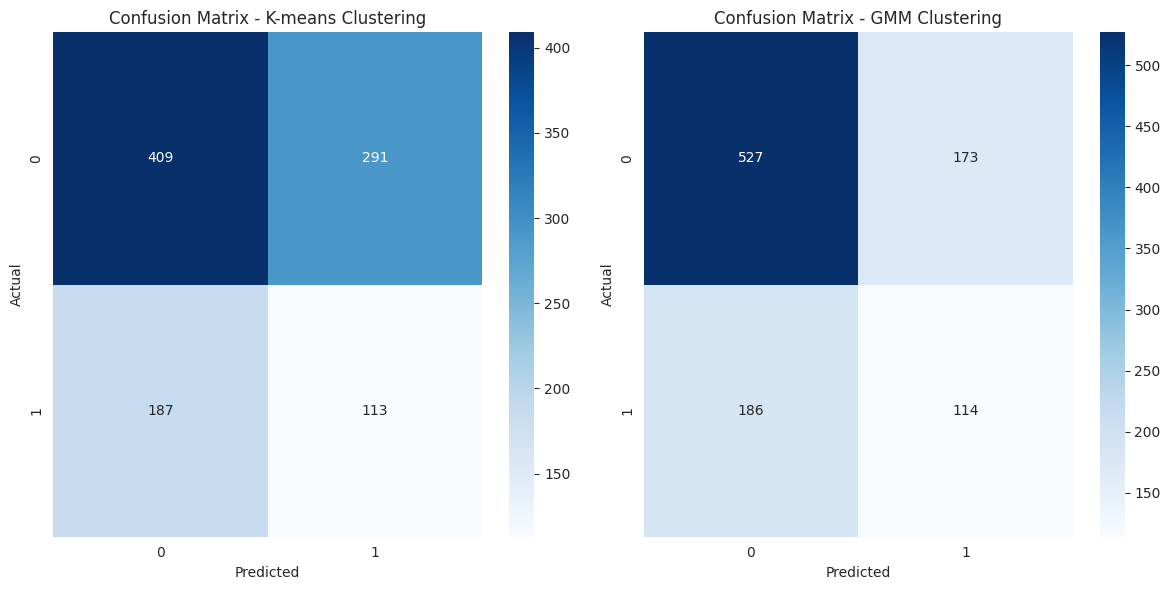

Purity of cluster 0 (K-means): 0.69
Purity of cluster 1 (K-means): 0.72
Purity of cluster 0 (GMM): 0.74
Purity of cluster 1 (GMM): 0.60


In [75]:
compute_purity(cl_gmm_normalized,df_normalized_cl_labels,labels)

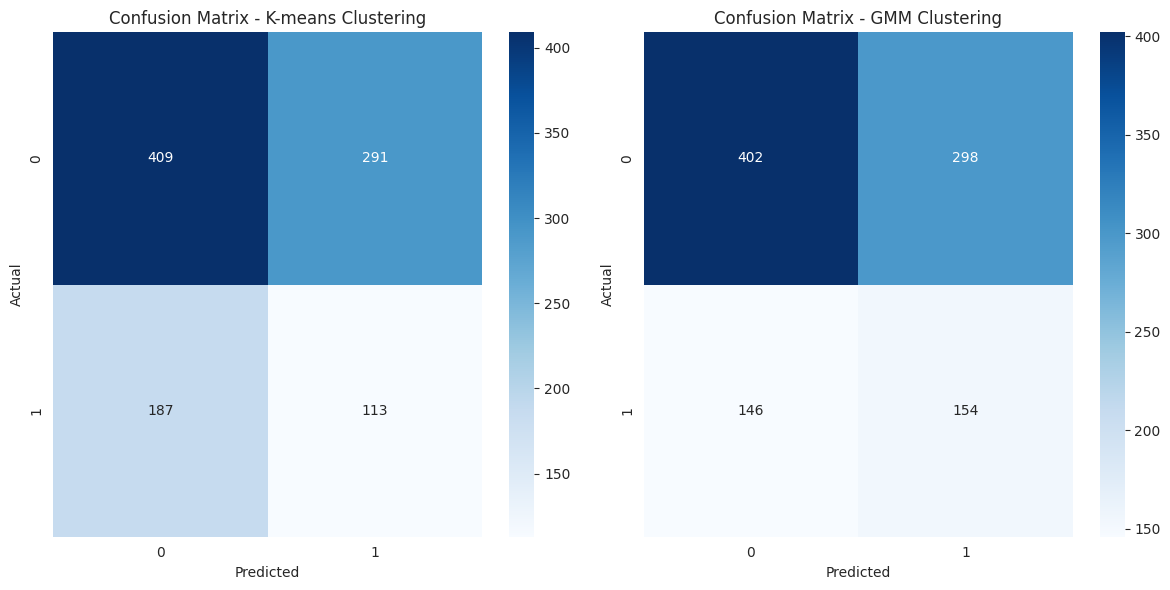

Purity of cluster 0 (K-means): 0.69
Purity of cluster 1 (K-means): 0.72
Purity of cluster 0 (GMM): 0.73
Purity of cluster 1 (GMM): 0.66


In [76]:
compute_purity(cl_gmm_clustering,df_clustering_cl_labels,labels)

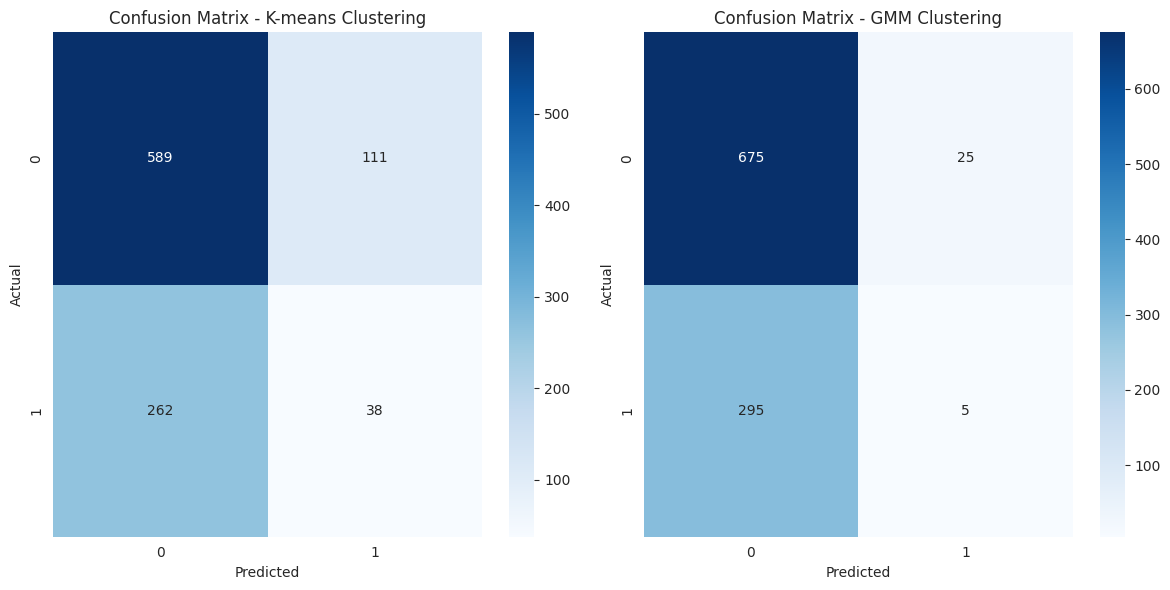

Purity of cluster 0 (K-means): 0.69
Purity of cluster 1 (K-means): 0.74
Purity of cluster 0 (GMM): 0.70
Purity of cluster 1 (GMM): 0.83


In [77]:
compute_purity(cl_gmm_start_scaled,df_start_scaled_cl_labels,labels)

For the remaining cluster assignments, we will cluster them in only 2 clusters to plot the confusion matrixes and compute the purity for each class.

In [78]:
df_numerical_cl_labels = tuning_k_means(df_numerical_clustering,labels,2)

k-Means with 2 clusters
Size of each cluster:  [605 395]
k_means clustering error: 419.76
Silhouette: 0.25
RI: 0.5
ARI: -0.01
Top 3 features with the highest distance between the 2 centroids: ['credit_amount' 'people_liability' 'installment_rate']


In [79]:
cl_gmm_numerical_labels = perform_gmm(df_numerical_clustering,labels, "Numerical PCA",2)

best k for GMM:  2  with corresponding silhouette:  0.19599436378651036
Size of each cluster:  [461 539]

Top 3 features with the highest distance between the 2 centroids: ['people_liability' 'credit_amount' 'installment_rate']


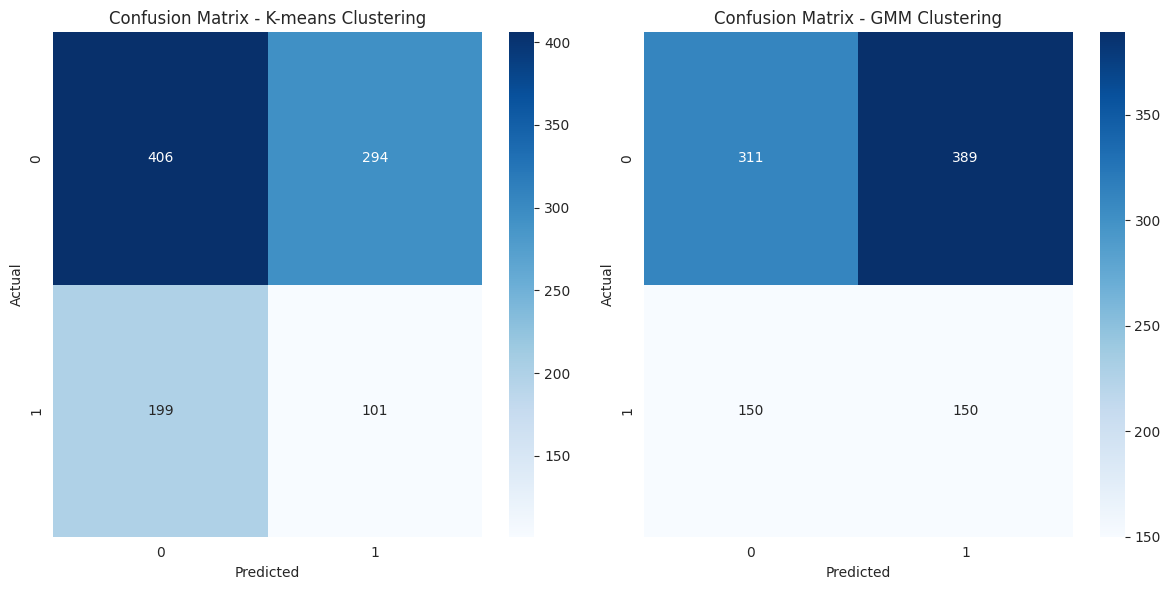

Purity of cluster 0 (K-means): 0.67
Purity of cluster 1 (K-means): 0.74
Purity of cluster 0 (GMM): 0.67
Purity of cluster 1 (GMM): 0.72


In [80]:
compute_purity(cl_gmm_numerical_labels,df_numerical_cl_labels,labels)

In [81]:
df_numerical_cl_pca = tuning_k_means(df_numerical_pca,labels,2)

k-Means with 2 clusters
Size of each cluster:  [605 395]
k_means clustering error: 339.11
Silhouette: 0.3
RI: 0.5
ARI: -0.01
Top 3 features with the highest distance between the 2 centroids: ['Component 3' 'Component 2' 'Component 1']


In [82]:
cl_gmm_numerical_pca = perform_gmm(df_numerical_pca,labels, "Numerical PCA",2) 

best k for GMM:  2  with corresponding silhouette:  0.24604744843458398
Size of each cluster:  [464 536]

Top 3 features with the highest distance between the 2 centroids: ['Component 2' 'Component 3' 'Component 1']


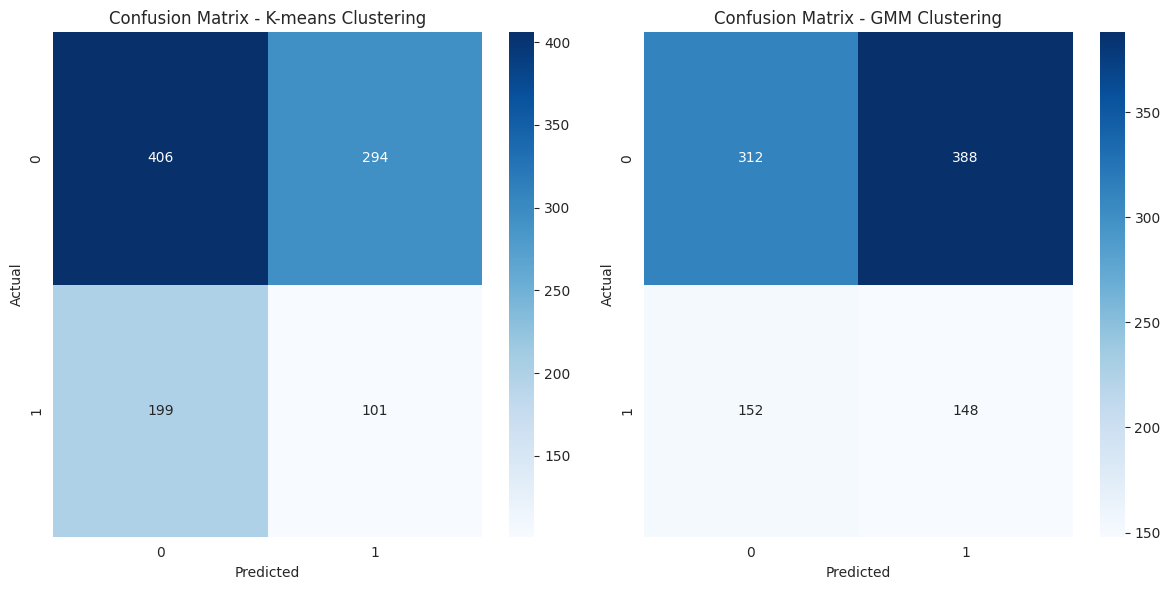

Purity of cluster 0 (K-means): 0.67
Purity of cluster 1 (K-means): 0.74
Purity of cluster 0 (GMM): 0.67
Purity of cluster 1 (GMM): 0.72


In [83]:
compute_purity(cl_gmm_numerical_pca,df_numerical_cl_pca,labels)

# 3 Supervised Data Analysis

## 3.1 Classifier Selection

### Pipeline Definition for each model

In [20]:
# model for the NN Pipeline
def build_model():
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(X_train_validation.shape[1],)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [21]:
model = KerasClassifier(model=build_model, verbose=0, random_state=16)

In [22]:
# data normalization is performed inside the pipeline for each different split, in order to avoid data leakage.
LogRegPipe = Pipeline([("scale", MinMaxScaler()), ("LogReg", LogisticRegression(random_state = 42))])
RFPipe = Pipeline([("scale", MinMaxScaler()), ("RF", RandomForestClassifier(random_state = 16))])
NNPipe = Pipeline([("scale", MinMaxScaler()), ("NN", model)])
SVMPipe = Pipeline([("scale", MinMaxScaler()), ("SVM", SVC(random_state=13, probability=True))])
GNBPipe = Pipeline([("scale", MinMaxScaler()),("GNB",ComplementNB())])

### HyperParameters Tuned for each Model

In [23]:
param_dict_logreg = {
    "LogReg__penalty": ["l2"],
    "LogReg__C" : [0.2, 1, 1.5, 2],
    "LogReg__max_iter": [25, 35, 50, 60, 80, 100, 120],
    "LogReg__class_weight": ["balanced", None],
    "LogReg__solver": ['lbfgs','liblinear']
}

param_dict_RF = {
    "RF__n_estimators": [50, 100, 200, 400, 600],
    "RF__max_depth": [5,10,20],
    "RF__max_features": ["sqrt",None,"log2"],
    "RF__min_samples_split": [5, 10, 15],
    "RF__class_weight": ["balanced", None]
}

param_dict_NN = {
   'NN__batch_size':[16,32,64,128],  
    'NN__epochs':[5,10,20,30,40,50],
    "NN__class_weight": ["balanced", None]
}
param_dict_SVM = {
    "SVM__C":[0.5,1.0,1.5,2],
    "SVM__kernel":['linear','poly','rbf'],
    "SVM__degree":[2,3,4],
    "SVM__gamma":['scale','auto'],
    "SVM__class_weight":["balanced", None],
}
param_dict_GNB ={
    "GNB__alpha" : [1.0, 1.5, 2.0,3.0],
}

### Cross-Validation Function 

In [88]:
def cross_val_features(X,y,pipeline,param_dict):
    # Creating a basic frame for a DF that displays Permutation Importances from all folds in the outer CV
    feature_importance_df = pd.Series(X.columns).rename("Predictor")
    feature_importance_df = pd.DataFrame(feature_importance_df) 
    
        
    # Cross Validation
    # Outer CV
    perf_metrics = {}
    params = {}
    i = 1
    outer_cv = StratifiedKFold( n_splits = 5, shuffle= True)
    inner_cv = StratifiedKFold(n_splits = 10, shuffle= True)
    for train_index, test_index in outer_cv.split(X,y):
    # Repeat for all outer folds
        X_train = X.iloc[train_index,:]
        X_test = X.iloc[test_index, :]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]
        
        perf_metrics[f"Outer Fold {i}"] = {}
        params[f"Outer Fold {i}"] = {}
        # Inner CV
        ## Split into Training and Test
        ## For all combinations of parameter sets calculate model
        scoring = ["accuracy","f1"]

        if pipeline == LogRegPipe or pipeline == RFPipe or pipeline == SVMPipe or pipeline==GNBPipe:
            refit_metric = "f1"
        else:
            refit_metric = "accuracy"
        gridcv = GridSearchCV(estimator = pipeline, param_grid = param_dict, scoring = scoring,refit=refit_metric, n_jobs = -1, cv = inner_cv)
        grid = gridcv.fit(X_train,y_train)
        #print(gridcv.scorer_)
        ## Give the parameter set that has performed best on average over all inner folds to outer cv.

        # Outer CV
        ## Train model with the parameter set of the Inner CV on the training set of the current outer fold
        pipeline.set_params(**grid.best_params_)
        pipeline.fit(X_train, y_train)
        params[f"Outer Fold {i}"] = pipeline.get_params()
        # Predict with fitted model
        X_test_norm = pd.DataFrame(normalization(X_test), columns=X_test.columns)
        y_pred = pipeline.predict(X_test_norm)
        y_proba = pipeline.predict_proba(X_test_norm)
        
        # Compute metrics for this outer fold
        perf_metrics[f"Outer Fold {i}"]["accuracy"] = accuracy_score(y_test, y_pred)
        perf_metrics[f"Outer Fold {i}"]["precision"] = precision_score(y_test, y_pred)
        perf_metrics[f"Outer Fold {i}"]["roc_auc"] = roc_auc_score(y_test, y_proba[:,1])
        perf_metrics[f"Outer Fold {i}"]["recall"] = recall_score(y_test, y_pred)
        perf_metrics[f"Outer Fold {i}"]["f1"] = f1_score(y_test, y_pred)

        ## Permutation Importance extraction
        perm_importance = permutation_importance(pipeline, X_train, y_train, scoring="accuracy", n_repeats=10)
        importances_mean = pd.Series(perm_importance.importances_mean).rename(f"Importance Mean Outer Fold {i}")
        importances_std = pd.Series(perm_importance.importances_std).rename(f"Importance Std Outer Fold {i}")
        feature_importance_df = pd.concat([feature_importance_df, importances_mean, importances_std], axis=1)
        
        print(f"Finished outer fold number {i}")
        i = i+1
        #feature_importance_df.sort_values(by=[f'Importance Mean Outer Fold {i}'],ascending=False)
        
        
        
        
    
    return feature_importance_df, perf_metrics, params

## Logistic Regression

In [ ]:
fi_logreg, perf_logreg, params_logreg = cross_val_features(X_train_validation,y_train_validation,LogRegPipe,param_dict_logreg)

### Logistic Regression: Folds' Metrics

In [72]:
df_perf_logreg = df.from_dict(perf_logreg)
df_perf_logreg.round(2)

Outer Fold 1  Outer Fold 2  Outer Fold 3  Outer Fold 4  \
accuracy           0.77          0.73          0.72          0.71   
precision          0.63          0.58          0.57          0.55   
roc_auc            0.76          0.80          0.73          0.77   
recall             0.56          0.38          0.35          0.12   
f1                 0.59          0.46          0.44          0.20   

           Outer Fold 5  
accuracy           0.74  
precision          0.65  
roc_auc            0.74  
recall             0.27  
f1                 0.38

### Logistic Regression: Tuned Hyperparameters

In [74]:
df_params_logreg = df.from_dict(params_logreg)
df_params_logreg

Outer Fold 1  \
memory                                                                  None   
steps                      [(scale, MinMaxScaler()), (LogReg, LogisticReg...   
verbose                                                                False   
scale                                                         MinMaxScaler()   
LogReg                     LogisticRegression(C=1, class_weight='balanced...   
scale__clip                                                            False   
scale__copy                                                             True   
scale__feature_range                                                  (0, 1)   
LogReg__C                                                                0.2   
LogReg__class_weight                                                balanced   
LogReg__dual                                                           False   
LogReg__fit_intercept                                                   True   
LogReg__intercept_scaling                                                  1   
LogReg__l1_ratio                                                        None   
LogReg__max_iter                                                          25   
LogReg__multi_class                                                     auto   
LogReg__n_jobs                                                          None   
LogReg__penalty                                                           l2   
LogReg__random_state                                                      42   
LogReg__solver                                                     liblinear   
LogReg__tol                                                           0.0001   
LogReg__verbose                                                            0   
LogReg__warm_start                                                     False   

                                                                Outer Fold 2  \
memory                                                                  None   
steps                      [(scale, MinMaxScaler()), (LogReg, LogisticReg...   
verbose                                                                False   
scale                                                         MinMaxScaler()   
LogReg                     LogisticRegression(C=1, class_weight='balanced...   
scale__clip                                                            False   
scale__copy                                                             True   
scale__feature_range                                                  (0, 1)   
LogReg__C                                                                0.2   
LogReg__class_weight                                                balanced   
LogReg__dual                                                           False   
LogReg__fit_intercept                                                   True   
LogReg__intercept_scaling                                                  1   
LogReg__l1_ratio                                                        None   
LogReg__max_iter                                                          25   
LogReg__multi_class                                                     auto   
LogReg__n_jobs                                                          None   
LogReg__penalty                                                           l2   
LogReg__random_state                                                      42   
LogReg__solver                                                         lbfgs   
LogReg__tol                                                           0.0001   
LogReg__verbose                                                            0   
LogReg__warm_start                                                     False   

                                                                Outer Fold 3  \
memory                                                                  None   
steps                      [(scale, MinMaxScaler()), (LogReg, 

### Logistic Regression: Feature Importance

In [75]:
fi_logreg.sort_values(by=[f'Importance Mean Outer Fold 1'],ascending=False)

Predictor  Importance Mean Outer Fold 1  \
44   existing_account_A14                      0.017656   
0          month_duration                      0.013906   
2        installment_rate                      0.013437   
11     credit_history_A34                      0.012187   
41   existing_account_A11                      0.012031   
..                    ...                           ...   
26      debts_status_A101                     -0.001719   
13            purpose_A41                     -0.002500   
59  employment_status_A74                     -0.002813   
42   existing_account_A12                     -0.002969   
58  employment_status_A73                     -0.004375   

    Importance Std Outer Fold 1  Importance Mean Outer Fold 2  \
44                     0.008445                      0.010312   
0                      0.008133                     -0.000313   
2                      0.004698                      0.003281   
11                     0.010383                      0.011719   
41                     0.008502                      0.005000   
..                          ...                           ...   
26                     0.001631                      0.002969   
13                     0.003776                      0.003281   
59                     0.004181                     -0.003594   
42                     0.005907                     -0.010938   
58                     0.004571                     -0.002500   

    Importance Std Outer Fold 2  Importance Mean Outer Fold 3  \
44                     0.006562                      0.008906   
0                      0.007153                      0.021875   
2                      0.007827                      0.009219   
11                     0.006675                      0.018437   
41                     0.007119                      0.009375   
..                          ...                           ...   
26                     0.002031                      0.000000   
13                     0.005865                      0.003906   
59                     0.003281                      0.007500   
42                     0.004364                      0.003437   
58                     0.003711                      0.001406   

    Importance Std Outer Fold 3  Importance Mean Outer Fold 4  \
44                     0.010871                      0.027500   
0                      0.005677                      0.004375   
2                      0.006933                      0.014063   
11                     0.006981                      0.017813   
41                     0.006052                     -0.004062   
..                          ...                           ...   
26                     0.000000                      0.000000   
13                     0.006299                     -0.006406   
59                     0.004931                     -0.004062   
42                     0.006242                     -0.003281   
58                     0.005012                     -0.006250   

    Importance Std Outer Fold 4  Importance Mean Outer Fold 5  \
44                     0.006374                      0.028594   
0                      0.007712                      0.011719   
2                      0.004419                      0.009375   
11                     0.007693                      0.010469   
41                     0.006219                      0.008750   
..                          ...                           ...   
26                     0.000000                      0.002344   
13                     0.003001                      0.004688   
59                     0.005855                      0.001719   
42                     0.005203                      0.007344   
58                     0.003351                      0.001094   

    Importance Std Outer Fold 5  
44                     0.007528  
0                      0.009536  
2                      0.006366  
11                     0.008120  
41           

### Logistic Regression: Average Metrics

In [76]:
mean_df_logreg = pd.DataFrame(df_perf_logreg.mean(axis=1).round(3),columns=['Mean'])
mean_df_logreg.round(2)

Mean
accuracy   0.73
precision  0.59
roc_auc    0.76
recall     0.34
f1         0.41

## Random Forest

In [ ]:
fi_rf, perf_rf, params_rf = cross_val_features(X_train_validation,y_train_validation,RFPipe,param_dict_RF)

### Random Forest: Folds' Metrics

In [82]:
df_perf_rf = df.from_dict(perf_rf)
df_perf_rf.round(2)

Outer Fold 1  Outer Fold 2  Outer Fold 3  Outer Fold 4  \
accuracy           0.74          0.71          0.72          0.71   
precision          0.57          1.00          0.64          0.55   
roc_auc            0.76          0.77          0.77          0.77   
recall             0.50          0.04          0.19          0.23   
f1                 0.53          0.08          0.29          0.32   

           Outer Fold 5  
accuracy           0.71  
precision          0.56  
roc_auc            0.76  
recall             0.19  
f1                 0.28

### Random Forest: Tuned HyperParameters

In [83]:
df_params_rf = df.from_dict(params_rf)
df_params_rf

Outer Fold 1  \
memory                                                                     None   
steps                         [(scale, MinMaxScaler()), (RF, (DecisionTreeCl...   
verbose                                                                   False   
scale                                                            MinMaxScaler()   
RF                            (DecisionTreeClassifier(max_depth=5, max_featu...   
scale__clip                                                               False   
scale__copy                                                                True   
scale__feature_range                                                     (0, 1)   
RF__bootstrap                                                              True   
RF__ccp_alpha                                                               0.0   
RF__class_weight                                                       balanced   
RF__criterion                                                              gini   
RF__max_depth                                                                 5   
RF__max_features                                                           sqrt   
RF__max_leaf_nodes                                                         None   
RF__max_samples                                                            None   
RF__min_impurity_decrease                                                   0.0   
RF__min_samples_leaf                                                          1   
RF__min_samples_split                                                        10   
RF__min_weight_fraction_leaf                                                0.0   
RF__monotonic_cst                                                          None   
RF__n_estimators                                                            600   
RF__n_jobs                                                                 None   
RF__oob_score                                                             False   
RF__random_state                                                             16   
RF__verbose                                                                   0   
RF__warm_start                                                            False   

                                                                   Outer Fold 2  \
memory                                                                     None   
steps                         [(scale, MinMaxScaler()), (RF, (DecisionTreeCl...   
verbose                                                                   False   
scale                                                            MinMaxScaler()   
RF                            (DecisionTreeClassifier(max_depth=5, max_featu...   
scale__clip                                                               False   
scale__copy                                                                True   
scale__feature_range                                                     (0, 1)   
RF__bootstrap                                                              True   
RF__ccp_alpha                                                               0.0   
RF__class_weight                                                       balanced   
RF__criterion                                                              gini   
RF__max_depth                                                                 5   
RF__max_features                                                           sqrt   
RF__max_leaf_nodes                                                         None   
RF__max_samples                                                            None   
RF__min_impurity_decrease                                                   0.0   
RF__min_samples_leaf                                                          1   
RF__min_samples_split                                                         5   
RF__min_weight_fraction_leaf                                                0.0   

### Random Forest: Feature Importance

In [84]:
fi_rf.sort_values(by=[f'Importance Mean Outer Fold 1'],ascending=False)

Predictor  Importance Mean Outer Fold 1  \
44  existing_account_A14                      0.033125   
1          credit_amount                      0.027969   
0         month_duration                      0.021875   
11    credit_history_A34                      0.015625   
45      saving_bonds_A61                      0.012344   
..                   ...                           ...   
10    credit_history_A33                     -0.000156   
7     credit_history_A30                     -0.000469   
46      saving_bonds_A62                     -0.000469   
19           purpose_A46                     -0.001875   
42  existing_account_A12                     -0.003594   

    Importance Std Outer Fold 1  Importance Mean Outer Fold 2  \
44                     0.011647                      0.022656   
1                      0.005653                      0.015469   
0                      0.004529                      0.020781   
11                     0.005720                      0.012344   
45                     0.005823                      0.016406   
..                          ...                           ...   
10                     0.000841                      0.000625   
7                      0.000716                     -0.001094   
46                     0.001220                      0.000000   
19                     0.001169                      0.000156   
42                     0.003281                     -0.005469   

    Importance Std Outer Fold 2  Importance Mean Outer Fold 3  \
44                     0.007599                      0.037031   
1                      0.004659                      0.017500   
0                      0.007196                      0.022344   
11                     0.005522                      0.010000   
45                     0.009144                      0.019688   
..                          ...                           ...   
10                     0.001593                      0.001250   
7                      0.000716                     -0.000937   
46                     0.000000                      0.000000   
19                     0.001631                      0.000000   
42                     0.002125                     -0.001094   

    Importance Std Outer Fold 3  Importance Mean Outer Fold 4  \
44                     0.014423                  1.687500e-02   
1                      0.004122                  2.390625e-02   
0                      0.005679                  2.484375e-02   
11                     0.006450                  1.421875e-02   
45                     0.006060                  1.046875e-02   
..                          ...                           ...   
10                     0.001822                  2.031250e-03   
7                      0.002119                 -1.562500e-04   
46                     0.000699                 -1.110223e-17   
19                     0.001210                 -9.375000e-04   
42                     0.003634                 -1.562500e-03   

    Importance Std Outer Fold 4  Importance Mean Outer Fold 5  \
44                     0.007616                      0.025000   
1                      0.006557                      0.023906   
0                      0.006646                      0.022656   
11                     0.006682                      0.008437   
45                     0.005504                      0.011875   
..                          ...                           ...   
10                     0.001220                      0.001250   
7                      0.002364                      0.001562   
46                     0.000699                     -0.000313   
19                     0.001250                     -0.000469   
42                     0.002318                      0.004219   

    Importance Std Outer Fold 5  
44                     0.012204  
1                      0.005764  
0                      0.005773  
11                     0.005049  
45                     0

### Random Forest: Average Metrics

In [85]:
mean_df_rf = pd.DataFrame(df_perf_rf.mean(axis=1).round(2),columns=['Mean'])
mean_df_rf

Mean
accuracy   0.72
precision  0.67
roc_auc    0.77
recall     0.23
f1         0.30

## Neural Network

In [ ]:
fi_nn, perf_nn, params_nn = cross_val_features(X_train_validation,y_train_validation,NNPipe,param_dict_NN)

### Neural Network: Folds' Metrics

In [25]:
df_perf_nn = df.from_dict(perf_nn)
df_perf_nn.round(2)

Outer Fold 1  Outer Fold 2  Outer Fold 3  Outer Fold 4  \
accuracy           0.74          0.71          0.73          0.70   
precision          0.55          0.54          0.55          0.50   
roc_auc            0.75          0.73          0.71          0.72   
recall             0.67          0.31          0.56          0.56   
f1                 0.60          0.39          0.56          0.53   

           Outer Fold 5  
accuracy           0.69  
precision          0.45  
roc_auc            0.79  
recall             0.19  
f1                 0.26

### Neural Network: Tuned HyperParameters

In [26]:
df_params_nn = df.from_dict(params_nn)
df_params_nn

Outer Fold 1  \
memory                                                                  None   
steps                      [(scale, MinMaxScaler()), (NN, KerasClassifier...   
verbose                                                                False   
scale                                                         MinMaxScaler()   
NN                         KerasClassifier(\n\tmodel=<function build_mode...   
scale__clip                                                            False   
scale__copy                                                             True   
scale__feature_range                                                  (0, 1)   
NN__model                           <function build_model at 0x7f3cdd1ccca0>   
NN__build_fn                                                            None   
NN__warm_start                                                         False   
NN__random_state                                                          16   
NN__optimizer                                                        rmsprop   
NN__loss                                                                None   
NN__metrics                                                             None   
NN__batch_size                                                            16   
NN__validation_batch_size                                               None   
NN__verbose                                                                0   
NN__callbacks                                                           None   
NN__validation_split                                                     0.0   
NN__shuffle                                                             True   
NN__run_eagerly                                                        False   
NN__epochs                                                                10   
NN__class_weight                                                    balanced   

                                                                Outer Fold 2  \
memory                                                                  None   
steps                      [(scale, MinMaxScaler()), (NN, KerasClassifier...   
verbose                                                                False   
scale                                                         MinMaxScaler()   
NN                         KerasClassifier(\n\tmodel=<function build_mode...   
scale__clip                                                            False   
scale__copy                                                             True   
scale__feature_range                                                  (0, 1)   
NN__model                           <function build_model at 0x7f3cdd1ccca0>   
NN__build_fn                                                            None   
NN__warm_start                                                         False   
NN__random_state                                                          16   
NN__optimizer                                                        rmsprop   
NN__loss                                                                None   
NN__metrics                                                             None   
NN__batch_size                                                            32   
NN__validation_batch_size                                               None   
NN__verbose                                                                0   
NN__callbacks                                                           None   
NN__validation_split                                                     0.0   
NN__shuffle                                                             True   
NN__run_eagerly                                                        False   
NN__epochs                                                                20   
NN__class_weight                                                    balanced   

                                                              

### Neural Network: Feature Importance

In [27]:
fi_nn.sort_values(by=[f'Importance Mean Outer Fold 1'],ascending=False)

Predictor  Importance Mean Outer Fold 1  \
41   existing_account_A11                      0.029844   
44   existing_account_A14                      0.020469   
0          month_duration                      0.017812   
11     credit_history_A34                      0.015156   
59  employment_status_A74                      0.013594   
..                    ...                           ...   
5           credit_number                      0.000469   
57  employment_status_A72                     -0.000469   
39           foreign_A201                     -0.001250   
49       saving_bonds_A65                     -0.001250   
18            purpose_A45                     -0.001875   

    Importance Std Outer Fold 1  Importance Mean Outer Fold 2  \
41                     0.006572                      0.025625   
44                     0.008879                      0.018594   
0                      0.003965                      0.009063   
11                     0.005041                      0.022344   
59                     0.004638                      0.007188   
..                          ...                           ...   
5                      0.001983                      0.001875   
57                     0.002711                      0.007500   
39                     0.001683                     -0.001406   
49                     0.004353                      0.006250   
18                     0.002073                     -0.000469   

    Importance Std Outer Fold 2  Importance Mean Outer Fold 3  \
41                     0.008125                      0.026406   
44                     0.005865                      0.025625   
0                      0.004239                      0.008281   
11                     0.008502                      0.014219   
59                     0.005896                      0.013906   
..                          ...                           ...   
5                      0.002688                      0.001875   
57                     0.004463                      0.007969   
39                     0.002364                      0.001562   
49                     0.003827                      0.010469   
18                     0.001719                      0.000312   

    Importance Std Outer Fold 3  Importance Mean Outer Fold 4  \
41                     0.008628                      0.015625   
44                     0.008274                      0.012344   
0                      0.005278                      0.010625   
11                     0.005433                      0.014219   
59                     0.005823                      0.007500   
..                          ...                           ...   
5                      0.004063                      0.001719   
57                     0.003981                      0.002500   
39                     0.003202                      0.001719   
49                     0.004137                      0.007812   
18                     0.001683                      0.000781   

    Importance Std Outer Fold 4  Importance Mean Outer Fold 5  \
41                     0.004990                      0.013438   
44                     0.011534                      0.040781   
0                      0.005668                      0.014844   
11                     0.007669                      0.032500   
59                     0.003617                      0.022344   
..                          ...                           ...   
5                      0.002656                      0.009531   
57                     0.002232                      0.007500   
39                     0.001298                     -0.000937   
49                     0.005846                      0.016250   
18                     0.000781                      0.004219   

    Importance Std Outer Fold 5  
41                     0.006746  
44                     0.008398  
0                      0.005557  
11                     0.006768  
59           

### Neural Network: Average Metrics

In [28]:
mean_df_nn = pd.DataFrame(df_perf_nn.mean(axis=1).round(2),columns=['Mean'])
mean_df_nn

Mean
accuracy   0.71
precision  0.52
roc_auc    0.74
recall     0.46
f1         0.47

## Support Vector Machine

In [89]:
fi_svm, perf_svm, params_svm = cross_val_features(X_train_validation,y_train_validation,SVMPipe,param_dict_SVM)

Finished outer fold number 1
Finished outer fold number 2
Finished outer fold number 3
Finished outer fold number 4
Finished outer fold number 5


### SVM: Folds' Metrics

In [90]:
df_perf_svm = df.from_dict(perf_svm)
df_perf_svm.round(2)

Outer Fold 1  Outer Fold 2  Outer Fold 3  Outer Fold 4  \
accuracy           0.72          0.74          0.71          0.74   
precision          0.53          0.54          0.52          0.55   
roc_auc            0.78          0.84          0.71          0.79   
recall             0.65          0.88          0.54          0.75   
f1                 0.58          0.67          0.53          0.63   

           Outer Fold 5  
accuracy           0.64  
precision          0.43  
roc_auc            0.75  
recall             0.60  
f1                 0.50

### SVM: Tuned HyperParameters

In [91]:
df_params_svm = df.from_dict(params_svm)
df_params_svm

Outer Fold 1  \
memory                                                                     None   
steps                         [(scale, MinMaxScaler()), (SVM, SVC(C=1.5, cla...   
verbose                                                                   False   
scale                                                            MinMaxScaler()   
SVM                           SVC(C=1.5, class_weight='balanced', degree=2, ...   
scale__clip                                                               False   
scale__copy                                                                True   
scale__feature_range                                                     (0, 1)   
SVM__C                                                                      1.5   
SVM__break_ties                                                           False   
SVM__cache_size                                                             200   
SVM__class_weight                                                      balanced   
SVM__coef0                                                                  0.0   
SVM__decision_function_shape                                                ovr   
SVM__degree                                                                   2   
SVM__gamma                                                                 auto   
SVM__kernel                                                                 rbf   
SVM__max_iter                                                                -1   
SVM__probability                                                           True   
SVM__random_state                                                            13   
SVM__shrinking                                                             True   
SVM__tol                                                                  0.001   
SVM__verbose                                                              False   

                                                                   Outer Fold 2  \
memory                                                                     None   
steps                         [(scale, MinMaxScaler()), (SVM, SVC(C=1.5, cla...   
verbose                                                                   False   
scale                                                            MinMaxScaler()   
SVM                           SVC(C=1.5, class_weight='balanced', degree=2, ...   
scale__clip                                                               False   
scale__copy                                                                True   
scale__feature_range                                                     (0, 1)   
SVM__C                                                                        2   
SVM__break_ties                                                           False   
SVM__cache_size                                                             200   
SVM__class_weight                                                      balanced   
SVM__coef0                                                                  0.0   
SVM__decision_function_shape                                                ovr   
SVM__degree                                                                   2   
SVM__gamma                                                                 auto   
SVM__kernel                                                                poly   
SVM__max_iter                                                                -1   
SVM__probability                                                           True   
SVM__random_state                                                            13   
SVM__shrinking                                                             True   
SVM__tol                                                                  0.001   
SVM__verbose                                                              False   

                                                                   Outer Fold 3  

### SVM: Feature Importance

In [93]:
fi_svm.sort_values(by=[f'Importance Mean Outer Fold 2'],ascending=False)

Predictor  Importance Mean Outer Fold 1  \
44  existing_account_A14                      0.005938   
45      saving_bonds_A61                      0.006250   
11    credit_history_A34                      0.002813   
41  existing_account_A11                      0.002500   
0         month_duration                      0.013125   
..                   ...                           ...   
29         property_A121                      0.012813   
47      saving_bonds_A63                      0.000000   
4                    age                      0.004375   
49      saving_bonds_A65                      0.004219   
42  existing_account_A12                      0.003750   

    Importance Std Outer Fold 1  Importance Mean Outer Fold 2  \
44                     0.004518                      0.015938   
45                     0.005720                      0.011563   
11                     0.005796                      0.008594   
41                     0.004485                      0.006719   
0                      0.005376                      0.005469   
..                          ...                           ...   
29                     0.006804                     -0.001562   
47                     0.000000                     -0.001719   
4                      0.001822                     -0.002500   
49                     0.002885                     -0.002812   
42                     0.005855                     -0.003906   

    Importance Std Outer Fold 2  Importance Mean Outer Fold 3  \
44                     0.011751                      0.011250   
45                     0.005511                      0.011250   
11                     0.005644                      0.009219   
41                     0.007128                     -0.002344   
0                      0.004029                      0.015937   
..                          ...                           ...   
29                     0.003763                      0.010469   
47                     0.001094                      0.000937   
4                      0.001875                     -0.001719   
49                     0.003409                      0.004687   
42                     0.004542                      0.004531   

    Importance Std Outer Fold 3  Importance Mean Outer Fold 4  \
44                     0.009239                      0.007656   
45                     0.005313                      0.009687   
11                     0.003160                      0.002500   
41                     0.007100                     -0.004844   
0                      0.002778                      0.008125   
..                          ...                           ...   
29                     0.005679                      0.004219   
47                     0.001432                      0.004687   
4                      0.001775                     -0.000156   
49                     0.003046                      0.003906   
42                     0.004963                     -0.004844   

    Importance Std Outer Fold 4  Importance Mean Outer Fold 5  \
44                     0.006791                     -0.000156   
45                     0.004980                      0.014375   
11                     0.003840                      0.014687   
41                     0.008311                      0.010469   
0                      0.005313                      0.016562   
..                          ...                           ...   
29                     0.005592                      0.017188   
47                     0.000988                      0.001250   
4                      0.002834                     -0.002031   
49                     0.002985                      0.005937   
42                     0.004160                      0.003281   

    Importance Std Outer Fold 5  
44                     0.009069  
45                     0.003878  
11                     0.006673  
41                     0.005764  
0                      0

### SVM: Average Metrics

In [94]:
mean_df_svm = pd.DataFrame(df_perf_svm.mean(axis=1).round(2),columns=['Mean'])
mean_df_svm

Mean
accuracy   0.71
precision  0.51
roc_auc    0.77
recall     0.68
f1         0.58

## Complement Naive Bayes

In [95]:
fi_cnb, perf_cnb, params_cnb = cross_val_features(X_train_validation,y_train_validation,GNBPipe,param_dict_GNB)

Finished outer fold number 1
Finished outer fold number 2
Finished outer fold number 3
Finished outer fold number 4
Finished outer fold number 5


### CNB: Folds' Metrics

In [96]:
df_perf_cnb = df.from_dict(perf_cnb)
df_perf_cnb.round(2)

Outer Fold 1  Outer Fold 2  Outer Fold 3  Outer Fold 4  \
accuracy           0.69          0.70          0.69          0.72   
precision          0.49          0.50          0.49          0.52   
roc_auc            0.75          0.76          0.75          0.75   
recall             0.71          0.75          0.69          0.79   
f1                 0.58          0.60          0.57          0.63   

           Outer Fold 5  
accuracy           0.72  
precision          0.53  
roc_auc            0.79  
recall             0.69  
f1                 0.60

### CNB: Tuned HyperParameters

In [52]:
df_params_cnb = df.from_dict(params_cnb)
df_params_cnb

Outer Fold 1  \
memory                                                             None   
steps                 [(scale, MinMaxScaler()), (GNB, ComplementNB(a...   
verbose                                                           False   
scale                                                    MinMaxScaler()   
GNB                                             ComplementNB(alpha=3.0)   
scale__clip                                                       False   
scale__copy                                                        True   
scale__feature_range                                             (0, 1)   
GNB__alpha                                                          3.0   
GNB__class_prior                                                   None   
GNB__fit_prior                                                     True   
GNB__force_alpha                                                   True   
GNB__norm                                                         False   

                                                           Outer Fold 2  \
memory                                                             None   
steps                 [(scale, MinMaxScaler()), (GNB, ComplementNB(a...   
verbose                                                           False   
scale                                                    MinMaxScaler()   
GNB                                             ComplementNB(alpha=3.0)   
scale__clip                                                       False   
scale__copy                                                        True   
scale__feature_range                                             (0, 1)   
GNB__alpha                                                          1.5   
GNB__class_prior                                                   None   
GNB__fit_prior                                                     True   
GNB__force_alpha                                                   True   
GNB__norm                                                         False   

                                                           Outer Fold 3  \
memory                                                             None   
steps                 [(scale, MinMaxScaler()), (GNB, ComplementNB(a...   
verbose                                                           False   
scale                                                    MinMaxScaler()   
GNB                                             ComplementNB(alpha=3.0)   
scale__clip                                                       False   
scale__copy                                                        True   
scale__feature_range                                             (0, 1)   
GNB__alpha                                                          3.0   
GNB__class_prior                                                   None   
GNB__fit_prior                                                     True   
GNB__force_alpha                                                   True   
GNB__norm                                                         False   

                                                           Outer Fold 4  \
memory                                                             None   
steps                 [(scale, MinMaxScaler()), (GNB, ComplementNB(a...   
verbose                                                           False   
scale                                                    MinMaxScaler()   
GNB                                             ComplementNB(alpha=3.0)   
scale__clip                                                       False   
scale__copy                                                        True   
scale__feature_range                                             (0, 1)   
GNB__alpha                                                          3.0   
GNB__class_prior                                                   None   
GNB__fit_prior                                                     True   
GNB__f

### CNB: Feature Importance

In [57]:
fi_cnb.sort_values(by=[f'Importance Mean Outer Fold 3'],ascending=False)

Predictor  Importance Mean Outer Fold 1  \
44  existing_account_A14                      0.020625   
28     debts_status_A103                      0.011875   
16           purpose_A43                      0.004687   
27     debts_status_A102                      0.003437   
49      saving_bonds_A65                     -0.001250   
..                   ...                           ...   
21           purpose_A49                     -0.005313   
8     credit_history_A31                     -0.002656   
24        status_sex_A93                      0.002969   
47      saving_bonds_A63                      0.001719   
45      saving_bonds_A61                      0.006719   

    Importance Std Outer Fold 1  Importance Mean Outer Fold 2  \
44                     0.010593                      0.015781   
28                     0.002232                      0.006562   
16                     0.004635                     -0.003125   
27                     0.003549                      0.007656   
49                     0.004780                     -0.002188   
..                          ...                           ...   
21                     0.002724                     -0.002344   
8                      0.003956                     -0.000781   
24                     0.002919                     -0.004688   
47                     0.002031                      0.004375   
45                     0.003634                     -0.006094   

    Importance Std Outer Fold 2  Importance Mean Outer Fold 3  \
44                     0.006609                      0.009687   
28                     0.003940                      0.006719   
16                     0.004134                      0.005000   
27                     0.002364                      0.004375   
49                     0.004539                      0.004062   
..                          ...                           ...   
21                     0.001881                     -0.002500   
8                      0.003441                     -0.002969   
24                     0.003046                     -0.003594   
47                     0.004122                     -0.004531   
45                     0.003792                     -0.005156   

    Importance Std Outer Fold 3  Importance Mean Outer Fold 4  \
44                     0.014704                      0.007188   
28                     0.001570                      0.000156   
16                     0.002688                      0.001719   
27                     0.002296                      0.001094   
49                     0.005511                     -0.000469   
..                          ...                           ...   
21                     0.001740                     -0.002344   
8                      0.001907                      0.001563   
24                     0.003831                      0.001406   
47                     0.003082                      0.000156   
45                     0.004137                     -0.004531   

    Importance Std Outer Fold 4  Importance Mean Outer Fold 5  \
44                     0.009862                      0.011250   
28                     0.001298                      0.003281   
16                     0.005610                     -0.005469   
27                     0.001000                      0.002969   
49                     0.007397                      0.003906   
..                          ...                           ...   
21                     0.002446                      0.000625   
8                      0.003953                     -0.002656   
24                     0.003082                     -0.001094   
47                     0.002563                     -0.001875   
45                     0.004101                      0.000625   

    Importance Std Outer Fold 5  
44                     0.009728  
28                     0.002364  
16                     0.005730  
27                     0.003311  
49                     0

### CNB: Average Metrics

In [54]:
mean_df_cnb = pd.DataFrame(df_perf_cnb.mean(axis=1).round(2),columns=['Mean'])
mean_df_cnb

Mean
accuracy   0.70
precision  0.50
roc_auc    0.76
recall     0.72
f1         0.59

## 3.3


In [46]:

def get_roc_curve(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    
def get_confusion_matrix(y_test, y_pred):
    conf_mat = confusion_matrix(y_test, y_pred)
    
    plt.subplot(1, 2, 2)
    sns.heatmap(conf_mat, annot=True, linewidth=0.5, xticklabels=["good_credit (0)", "bad_credit (1)"], fmt="g")
    plt.xlabel("predicted")
    plt.ylabel("actual")
    
    plt.tight_layout()
    plt.show()


### Most Accurate Logistic Regression Hypothesis

In [43]:
lr_final_metrics = {}
logisticregression = LogisticRegression(penalty='l2',C=0.2,class_weight='balanced',max_iter=25,solver='liblinear',random_state=42).fit(X_train_validation_normalized, y_train_validation)
y_prob_lr = logisticregression.predict_proba(X_test)
lr_pred = logisticregression.predict(X_test)
lr_final_metrics["accuracy"] = accuracy_score(y_test, lr_pred)
lr_final_metrics["precision"] = precision_score(y_test, lr_pred)
lr_final_metrics["roc_auc"] = roc_auc_score(y_test, y_prob_lr[:,1])
lr_final_metrics["recall"] = recall_score(y_test, lr_pred)
lr_final_metrics["f1"] = f1_score(y_test, lr_pred)

In [44]:
df_final_metrics = pd.DataFrame.from_dict(lr_final_metrics, orient='index', columns=['Metrics'])
df_final_metrics.round(2)

Metrics
accuracy      0.69
precision     0.49
roc_auc       0.78
recall        0.72
f1            0.58

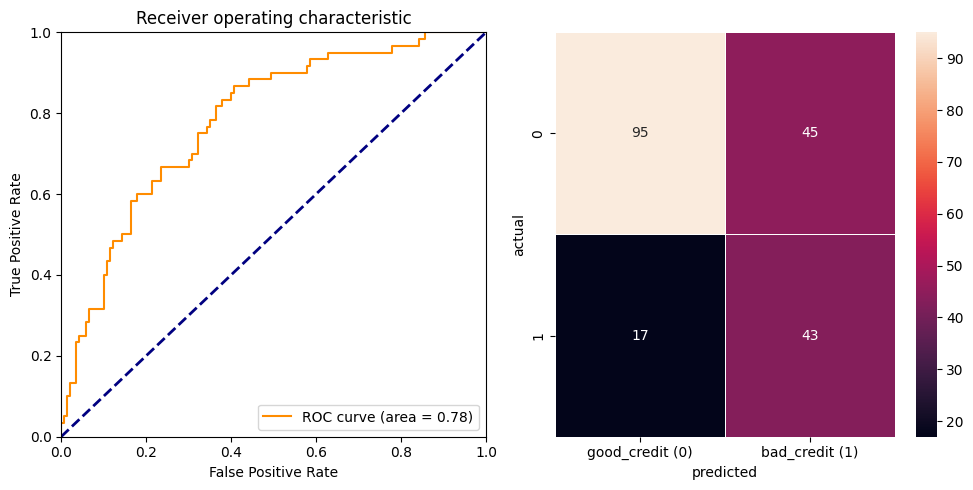

In [47]:
get_roc_curve(y_test,y_prob_lr[:,1])
get_confusion_matrix(y_test,lr_pred)

### Most Accurate Random Forest Hypothesis

In [48]:
rf_final_metrics = {}
randomforest = RandomForestClassifier(max_depth=5,n_estimators=200,min_samples_split=10,max_features="sqrt",class_weight='balanced', random_state=16).fit(X_train_validation_normalized, y_train_validation)
y_prob_rf = randomforest.predict_proba(X_test)
rf_pred = randomforest.predict(X_test)
rf_final_metrics["accuracy"] = accuracy_score(y_test, rf_pred)
rf_final_metrics["precision"] = precision_score(y_test, rf_pred)
rf_final_metrics["roc_auc"] = roc_auc_score(y_test, y_prob_rf[:,1])
rf_final_metrics["recall"] = recall_score(y_test, rf_pred)
rf_final_metrics["f1"] = f1_score(y_test, rf_pred)

In [49]:
df_final_metrics = pd.DataFrame.from_dict(rf_final_metrics, orient='index', columns=['Metrics'])

df_final_metrics.round(2)

Metrics
accuracy      0.70
precision     0.50
roc_auc       0.78
recall        0.65
f1            0.57

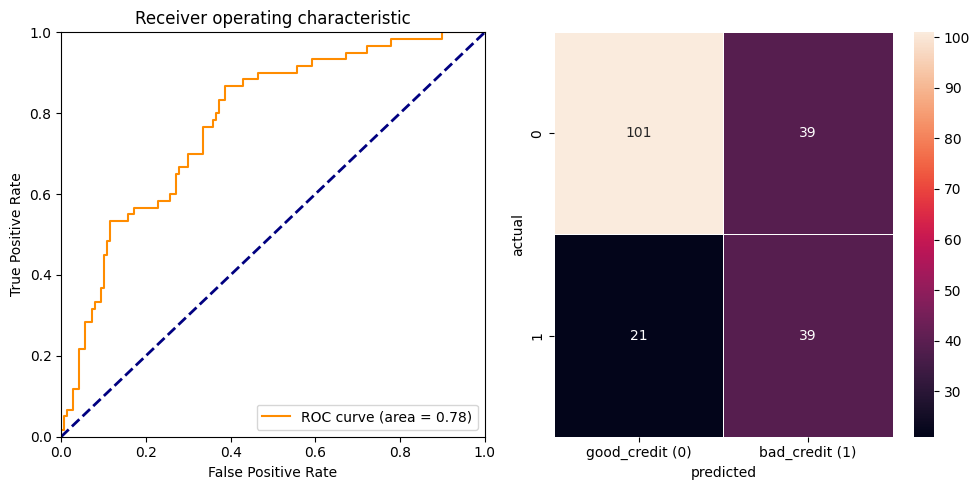

In [50]:
get_roc_curve(y_test,y_prob_rf[:,1])
get_confusion_matrix(y_test,rf_pred)

### Most Accurate Neural Network Hypothesis

In [58]:
class_labels = np.unique(y_train_validation)
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=y_train_validation)
class_weight_dict = dict(zip(class_labels,class_weights))
neuralnetwork = KerasClassifier(model=build_model, verbose=0, random_state=18).fit(X_train_validation_normalized, y_train_validation, epochs=10, batch_size=16, class_weight=class_weight_dict)
nn_final_metrics = {}
y_prob_nn = neuralnetwork.predict_proba(X_test)
nn_pred = neuralnetwork.predict(X_test)
nn_final_metrics["accuracy"] = accuracy_score(y_test, nn_pred)
nn_final_metrics["precision"] = precision_score(y_test, nn_pred)
nn_final_metrics["roc_auc"] = roc_auc_score(y_test, y_prob_nn[:,1])
nn_final_metrics["recall"] = recall_score(y_test, nn_pred)
nn_final_metrics["f1"] = f1_score(y_test, nn_pred)

In [59]:
df_final_metrics = pd.DataFrame.from_dict(nn_final_metrics, orient='index', columns=['Metrics'])
df_final_metrics.round(2)

Metrics
accuracy      0.70
precision     0.50
roc_auc       0.77
recall        0.75
f1            0.60

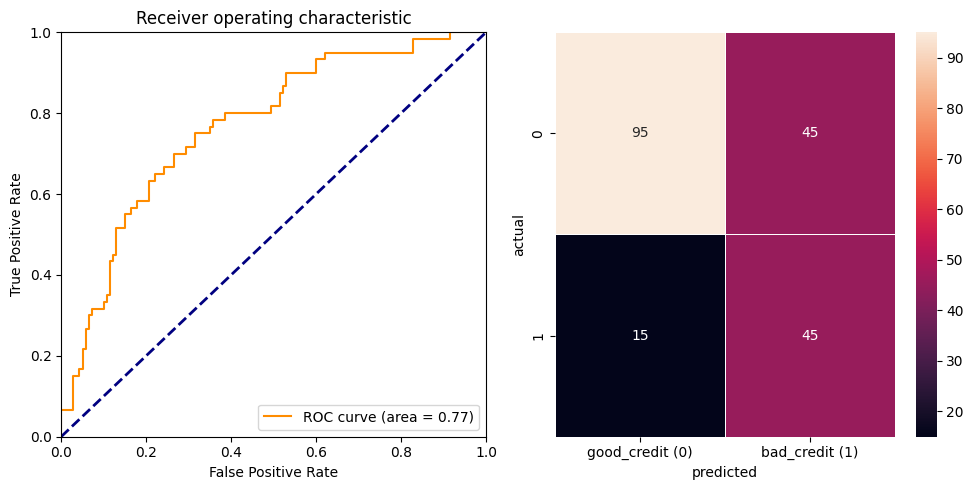

In [53]:
get_roc_curve(y_test,y_prob_nn[:,1])
get_confusion_matrix(y_test,nn_pred)

### Most Accurate Support Vector Machine Hypothesis

In [90]:
svm_final_metrics = {}
svm = SVC(C=1.5,degree=2,random_state=11,kernel="linear", gamma="scale",class_weight='balanced',probability=True).fit(X_train_validation_normalized, y_train_validation)
y_prob_svm = svm.predict_proba(X_test)
svm_pred = svm.predict(X_test)
svm_final_metrics["accuracy"] = accuracy_score(y_test, svm_pred)
svm_final_metrics["precision"] = precision_score(y_test, svm_pred)
svm_final_metrics["roc_auc"] = roc_auc_score(y_test, y_prob_svm[:,1])
svm_final_metrics["recall"] = recall_score(y_test, svm_pred)
svm_final_metrics["f1"] = f1_score(y_test, svm_pred)

In [35]:
svm_final_metrics = pd.DataFrame.from_dict(svm_final_metrics, orient='index', columns=['Metrics'])

svm_final_metrics.round(2)

Metrics
accuracy      0.69
precision     0.49
roc_auc       0.77
recall        0.70
f1            0.58

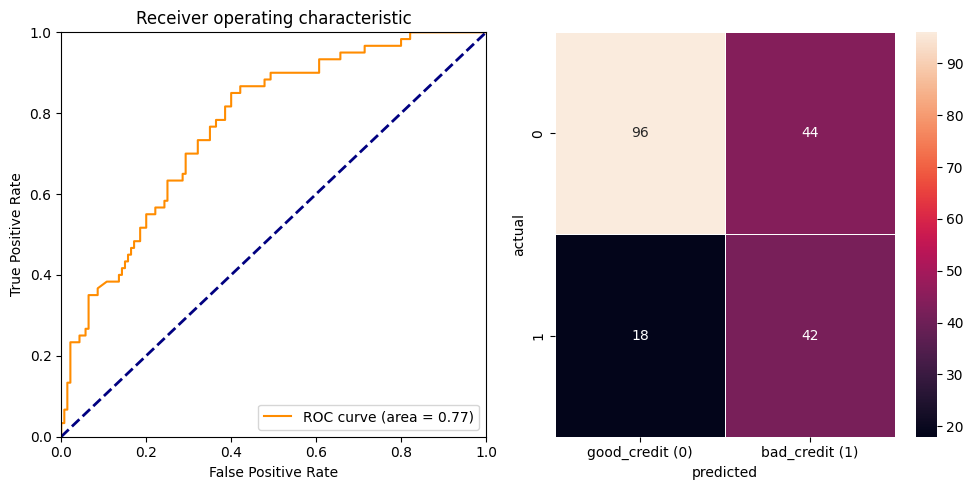

In [36]:
get_roc_curve(y_test,y_prob_svm[:,1])
get_confusion_matrix(y_test,svm_pred)

### Most Accurate Complement Naive Bayes Hypothesis

In [91]:
cnb_final_metrics = {}
cnb = ComplementNB(alpha=2.0).fit(X_train_validation_normalized,y_train_validation)
y_proba_cnb = cnb.predict_proba(X_test)
cnb_pred = cnb.predict(X_test)
cnb_final_metrics["accuracy"] = accuracy_score(y_test, cnb_pred)
cnb_final_metrics["precision"] = precision_score(y_test, cnb_pred)
cnb_final_metrics["roc_auc"] = roc_auc_score(y_test, y_proba_cnb[:,1])
cnb_final_metrics["recall"] = recall_score(y_test, cnb_pred)
cnb_final_metrics["f1"] = f1_score(y_test, cnb_pred)

In [38]:
cnb_final_metrics = pd.DataFrame.from_dict(cnb_final_metrics, orient='index', columns=['Metrics'])

cnb_final_metrics.round(2)

Metrics
accuracy      0.71
precision     0.51
roc_auc       0.79
recall        0.78
f1            0.62

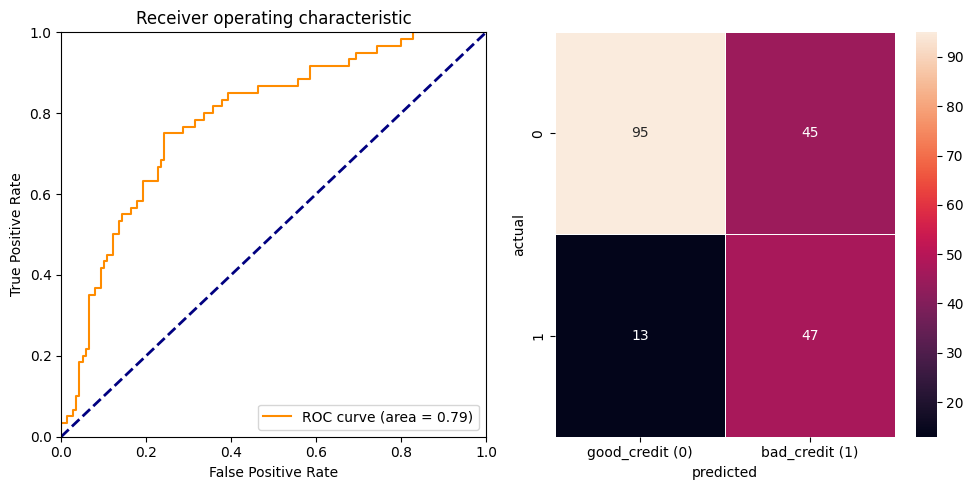

In [39]:
get_roc_curve(y_test,y_proba_cnb[:,1])
get_confusion_matrix(y_test,cnb_pred)

### 3.3: Recap

In [159]:
def plot_scores(f1_scores, accuracy_scores, y_test, y_probs):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    models = ['LogReg', 'RF', 'NN', 'SVM', 'CNB']
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
    ax1.bar(models, accuracy_scores, color=colors)
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Accuracy Scores Recap')
    ax2.bar(models, f1_scores, color=colors)
    ax2.set_ylabel('F1 Score')
    ax2.set_title('F1 Scores Recap')
    names = ['LogReg', 'RF', 'NN', 'SVM', 'CNB']
    for name, i in zip(names, range(len(y_probs))):
        fpr, tpr, _ = roc_curve(y_test, y_probs[i])
        roc_auc = auc(fpr, tpr)
        ax3.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    ax3.plot([0, 1], [0, 1], color='darkorange', lw=2, linestyle='--')
    ax3.set_xlim([0.0, 1.0])
    ax3.set_ylim([0.0, 1.0])
    ax3.set_xlabel('False Positive Rate')
    ax3.set_ylabel('True Positive Rate')
    ax3.legend(loc="lower right")
    ax3.set_title('ROC Curves Recap')

    plt.subplots_adjust(wspace=0.4)

    plt.show()


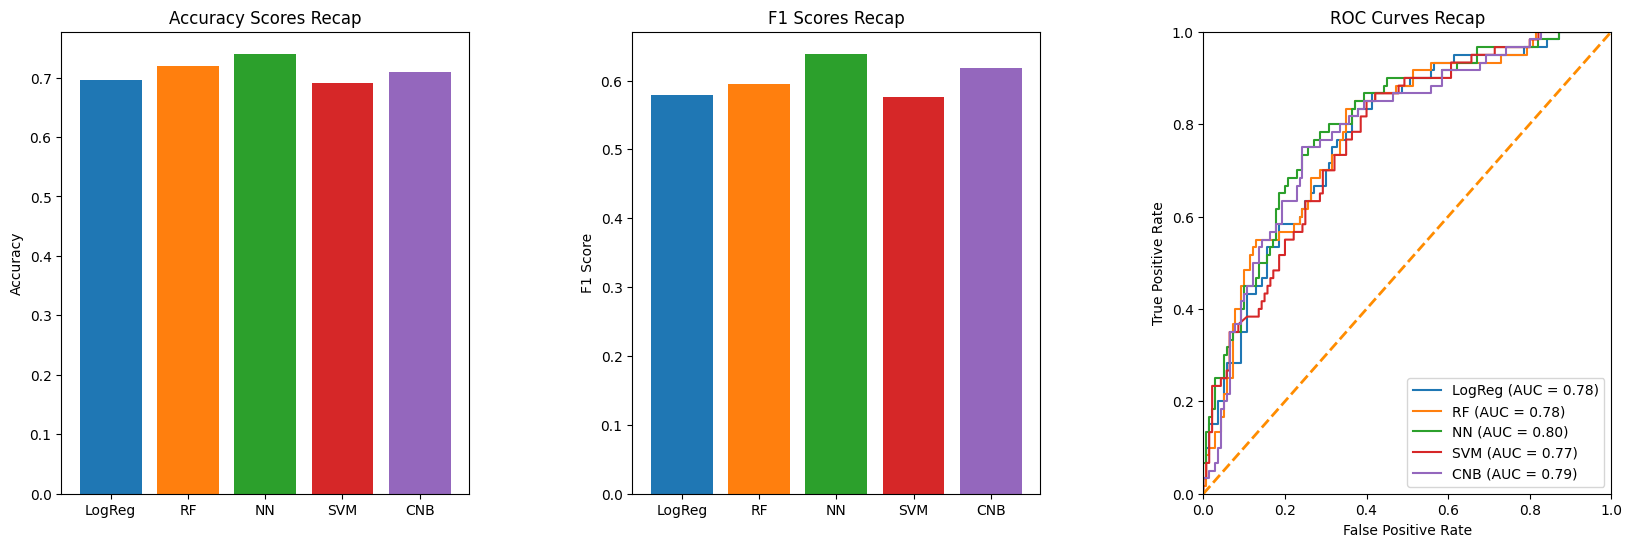

In [160]:
plot_scores([lr_final_metrics["f1"],rf_final_metrics["f1"],nn_final_metrics["f1"],svm_final_metrics["f1"], cnb_final_metrics["f1"]], [lr_final_metrics["accuracy"],rf_final_metrics["accuracy"],nn_final_metrics["accuracy"],svm_final_metrics["accuracy"],cnb_final_metrics["accuracy"]],y_test, y_probs=[y_prob_lr[:,1], y_prob_rf[:,1], y_prob_nn[:,1], y_prob_svm[:,1], y_proba_cnb[:,1]])


# 4. Adversarial Attacks

## 4.1: Random Noise



In [6]:

def generate_clipped_noise(test_data, euclidean_distance,scaling_factor):
    # Generate random noise from a Gaussian distribution with mean 0 and standard deviation 1
    noise = np.random.normal(0, 1,size=(test_data.shape))
    scaled_noise = noise * scaling_factor
    scaled_noise_norm = np.linalg.norm(scaled_noise)
    scaled_noise = scaled_noise * (euclidean_distance / scaled_noise_norm)
    noisy_test_data = test_data + scaled_noise
    return noisy_test_data

In [7]:
def robust_accuracy(classifier, X_test, y_test, euclidean_distance,scaling_factor):
    noise_data = generate_clipped_noise(X_test, euclidean_distance,scaling_factor)
    y_pred = classifier.predict(noise_data)
    # Measure accuracy on which we added noise
    robust_accuracy = accuracy_score(y_test, y_pred)
    robust_f1 = f1_score(y_test,y_pred)
    return robust_accuracy,robust_f1

In [8]:
euclidean_distances = [0.05,0.1,0.5,1,5,10,20,30,50,100,150,200]
test_data_norm = np.linalg.norm(X_test)

### Logistic Regression

In [72]:
logisticregression = LogisticRegression(penalty='l2',C=1,class_weight='balanced',max_iter=25,solver='liblinear').fit(X_train_validation_normalized, y_train_validation)
robust_accuracy_results_lr = []
robust_f1_results_lr = []
scalings = []
for euclidean_distance in euclidean_distances:
    scaling_factor = euclidean_distance / test_data_norm #scaling_noise_factor in respect to X_test, in order to have an idea of how weighted is the current euclidean_distance from X_test
    robust_acc, robust_f1 = robust_accuracy(logisticregression, X_test, y_test, euclidean_distance,scaling_factor)
    robust_accuracy_results_lr.append(robust_acc)
    robust_f1_results_lr.append(robust_f1)
    scalings.append(scaling_factor)

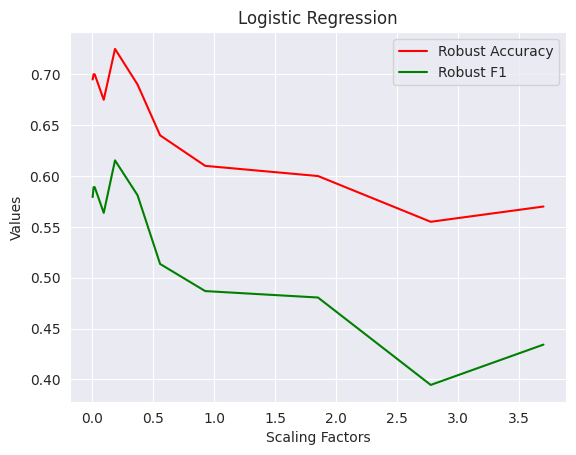

0.05      0.10      0.50      1.00      5.00      10.00   \
Robust_Accuracy  0.695000  0.695000  0.700000  0.700000  0.675000  0.725000   
Robust_F1        0.579310  0.579310  0.589041  0.589041  0.563758  0.615385   
Scaling_Factor   0.000926  0.001852  0.009261  0.018523  0.092614  0.185229   

                   20.00     30.00     50.00     100.00    150.00    200.00  
Robust_Accuracy  0.690000  0.640000  0.610000  0.600000  0.555000  0.570000  
Robust_F1        0.581081  0.513514  0.486842  0.480519  0.394558  0.434211  
Scaling_Factor   0.370458  0.555687  0.926144  1.852289  2.778433  3.704577

In [34]:
plt.plot(scalings, robust_accuracy_results_lr, color='red', label='Robust Accuracy')
plt.plot(scalings, robust_f1_results_lr, color='green', label='Robust F1')
plt.xlabel('Scaling Factors')
plt.ylabel('Values')
plt.title('Logistic Regression')
plt.legend()
plt.show()
robust_df = pd.DataFrame(np.vstack((robust_accuracy_results_lr, robust_f1_results_lr,scalings)),columns=euclidean_distances).rename(index={0: "Robust_Accuracy", 1: "Robust_F1",2:"Scaling_Factor"})
robust_df

### Random Forest

In [13]:
randomforest = RandomForestClassifier(max_depth=5,n_estimators=400,min_samples_split=5,max_features="sqrt",class_weight='balanced', random_state=24).fit(X_train_validation_normalized, y_train_validation)
robust_accuracy_results_rf = []
robust_f1_results_rf = []
scalings = []
for euclidean_distance in euclidean_distances:
    scaling_factor = euclidean_distance / test_data_norm #scaling_noise_factor in respect to X_test, in order to have an idea of how weighted is the current euclidean_distance from X_test
    robust_acc, robust_f1 = robust_accuracy(randomforest, X_test, y_test, euclidean_distance,scaling_factor)
    robust_accuracy_results_rf.append(robust_acc)
    robust_f1_results_rf.append(robust_f1)
    scalings.append(scaling_factor)

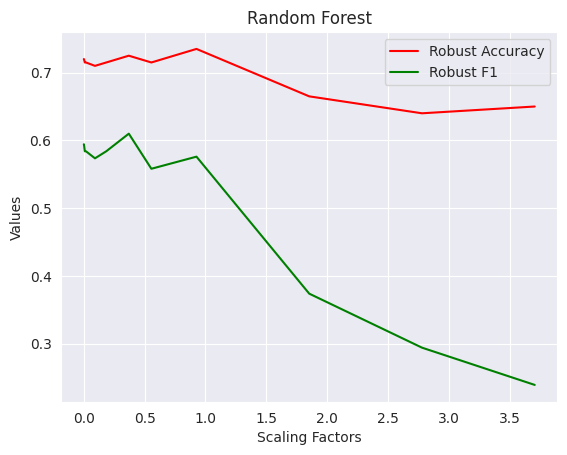

0.05      0.10      0.50      1.00      5.00      10.00   \
Robust_Accuracy  0.720000  0.720000  0.715000  0.715000  0.710000  0.715000   
Robust_F1        0.594203  0.594203  0.583942  0.583942  0.573529  0.583942   
Scaling_Factor   0.000926  0.001852  0.009261  0.018523  0.092614  0.185229   

                   20.00     30.00     50.00     100.00    150.00    200.00  
Robust_Accuracy  0.725000  0.715000  0.735000  0.665000  0.640000  0.650000  
Robust_F1        0.609929  0.558140  0.576000  0.373832  0.294118  0.239130  
Scaling_Factor   0.370458  0.555687  0.926144  1.852289  2.778433  3.704577

In [14]:
plt.plot(scalings, robust_accuracy_results_rf, color='red', label='Robust Accuracy')
plt.plot(scalings, robust_f1_results_rf, color='green', label='Robust F1')
plt.xlabel('Scaling Factors')
plt.ylabel('Values')
plt.title('Random Forest')
plt.legend()
plt.show()
robust_df = pd.DataFrame(np.vstack((robust_accuracy_results_rf, robust_f1_results_rf,scalings)),columns=euclidean_distances).rename(index={0: "Robust_Accuracy", 1: "Robust_F1",2:"Scaling_Factor"})
robust_df

### Neural Network

In [73]:
from sklearn.utils.class_weight import compute_class_weight
class_labels = np.unique(y_train_validation)
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=y_train_validation)
class_weight_dict = dict(zip(class_labels,class_weights))
neuralnetwork = KerasClassifier(model=build_model, verbose=0, random_state=18).fit(X_train_validation_normalized, y_train_validation, epochs=40, batch_size=64, class_weight=class_weight_dict)
robust_accuracy_results_nn = []
robust_f1_results_nn = []
scalings = []
for euclidean_distance in euclidean_distances:
    scaling_factor = euclidean_distance / test_data_norm
    robust_acc, robust_f1 = robust_accuracy(neuralnetwork, X_test, y_test, euclidean_distance, scaling_factor)
    robust_accuracy_results_nn.append(robust_acc)
    robust_f1_results_nn.append(robust_f1)
    scalings.append(scaling_factor)



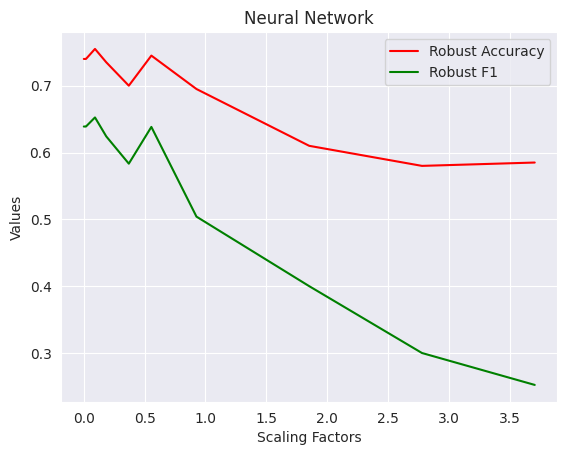

0.05      0.10      0.50      1.00      5.00      10.00   \
Robust_Accuracy  0.740000  0.740000  0.740000  0.740000  0.755000  0.735000   
Robust_F1        0.638889  0.638889  0.638889  0.638889  0.652482  0.624113   
Scaling_Factor   0.000926  0.001852  0.009261  0.018523  0.092614  0.185229   

                   20.00     30.00     50.00     100.00    150.00    200.00  
Robust_Accuracy  0.700000  0.745000  0.695000  0.610000  0.580000  0.585000  
Robust_F1        0.583333  0.638298  0.504065  0.400000  0.300000  0.252252  
Scaling_Factor   0.370458  0.555687  0.926144  1.852289  2.778433  3.704577

In [74]:
plt.plot(scalings, robust_accuracy_results_nn, color='red', label='Robust Accuracy')
plt.plot(scalings, robust_f1_results_nn, color='green', label='Robust F1')
plt.xlabel('Scaling Factors')
plt.ylabel('Values')
plt.title('Neural Network')
plt.legend()
plt.show()
robust_df = pd.DataFrame(np.vstack((robust_accuracy_results_nn, robust_f1_results_nn,scalings)),columns=euclidean_distances).rename(index={0: "Robust_Accuracy", 1: "Robust_F1",2:"Scaling_Factor"})
robust_df

### Support Vector Machine

In [23]:
svm = SVC(C=1.5,degree=2,random_state=13,kernel="linear",class_weight='balanced', gamma="scale").fit(X_train_validation_normalized, y_train_validation)
robust_accuracy_results_svm = []
robust_f1_results_svm = []
scalings = []
for euclidean_distance in euclidean_distances:
    scaling_factor = euclidean_distance / test_data_norm #scaling_noise_factor in respect to X_test, in order to have an idea of how weighted is the current euclidean_distance from X_test
    robust_acc, robust_f1 = robust_accuracy(randomforest, X_test, y_test, euclidean_distance,scaling_factor)
    robust_accuracy_results_svm.append(robust_acc)
    robust_f1_results_svm.append(robust_f1)
    scalings.append(scaling_factor)

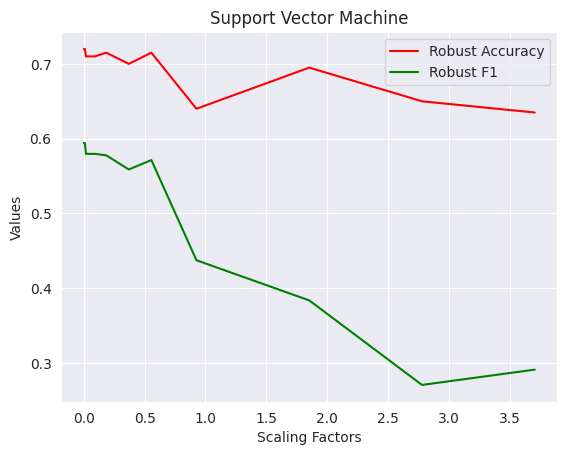

0.05      0.10      0.50      1.00      5.00      10.00   \
Robust_Accuracy  0.720000  0.720000  0.720000  0.710000  0.710000  0.715000   
Robust_F1        0.594203  0.594203  0.594203  0.579710  0.579710  0.577778   
Scaling_Factor   0.000926  0.001852  0.009261  0.018523  0.092614  0.185229   

                   20.00     30.00     50.00     100.00    150.00    200.00  
Robust_Accuracy  0.700000  0.715000  0.640000  0.695000  0.650000  0.635000  
Robust_F1        0.558824  0.571429  0.437500  0.383838  0.270833  0.291262  
Scaling_Factor   0.370458  0.555687  0.926144  1.852289  2.778433  3.704577

In [24]:
plt.plot(scalings, robust_accuracy_results_svm, color='red', label='Robust Accuracy')
plt.plot(scalings, robust_f1_results_svm, color='green', label='Robust F1')
plt.xlabel('Scaling Factors')
plt.ylabel('Values')
plt.title('Support Vector Machine')
plt.legend()
plt.show()
robust_df = pd.DataFrame(np.vstack((robust_accuracy_results_svm, robust_f1_results_svm,scalings)),columns=euclidean_distances).rename(index={0: "Robust_Accuracy", 1: "Robust_F1",2:"Scaling_Factor"})
robust_df

### Complement Naive Bayes

In [25]:
cnb = ComplementNB(alpha=2.0)
robust_accuracy_results_cnb = []
robust_f1_results_cnb = []
scalings = []
for euclidean_distance in euclidean_distances:
    scaling_factor = euclidean_distance / test_data_norm #scaling_noise_factor in respect to X_test, in order to have an idea of how weighted is the current euclidean_distance from X_test
    robust_acc, robust_f1 = robust_accuracy(randomforest, X_test, y_test, euclidean_distance,scaling_factor)
    robust_accuracy_results_cnb.append(robust_acc)
    robust_f1_results_cnb.append(robust_f1)
    scalings.append(scaling_factor)

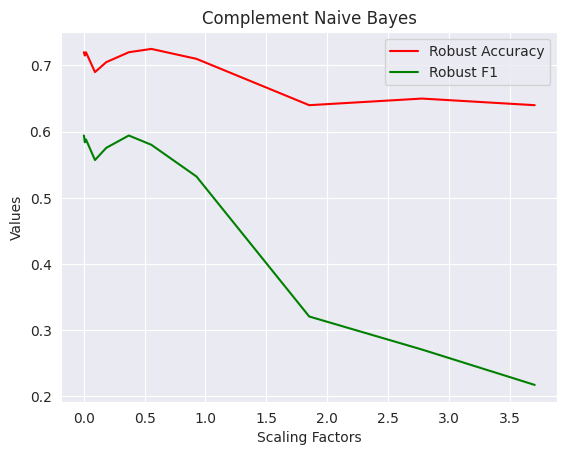

0.05      0.10      0.50      1.00      5.00      10.00   \
Robust_Accuracy  0.720000  0.720000  0.715000  0.720000  0.690000  0.705000   
Robust_F1        0.594203  0.594203  0.583942  0.588235  0.557143  0.575540   
Scaling_Factor   0.000926  0.001852  0.009261  0.018523  0.092614  0.185229   

                   20.00     30.00     50.00     100.00    150.00    200.00  
Robust_Accuracy  0.720000  0.725000  0.710000  0.640000  0.650000  0.640000  
Robust_F1        0.594203  0.580153  0.532258  0.320755  0.270833  0.217391  
Scaling_Factor   0.370458  0.555687  0.926144  1.852289  2.778433  3.704577

In [26]:
plt.plot(scalings, robust_accuracy_results_cnb, color='red', label='Robust Accuracy')
plt.plot(scalings, robust_f1_results_cnb, color='green', label='Robust F1')
plt.xlabel('Scaling Factors')
plt.ylabel('Values')
plt.title('Complement Naive Bayes')
plt.legend()
plt.show()
robust_df = pd.DataFrame(np.vstack((robust_accuracy_results_cnb, robust_f1_results_cnb,scalings)),columns=euclidean_distances).rename(index={0: "Robust_Accuracy", 1: "Robust_F1",2:"Scaling_Factor"})
robust_df

## Recap

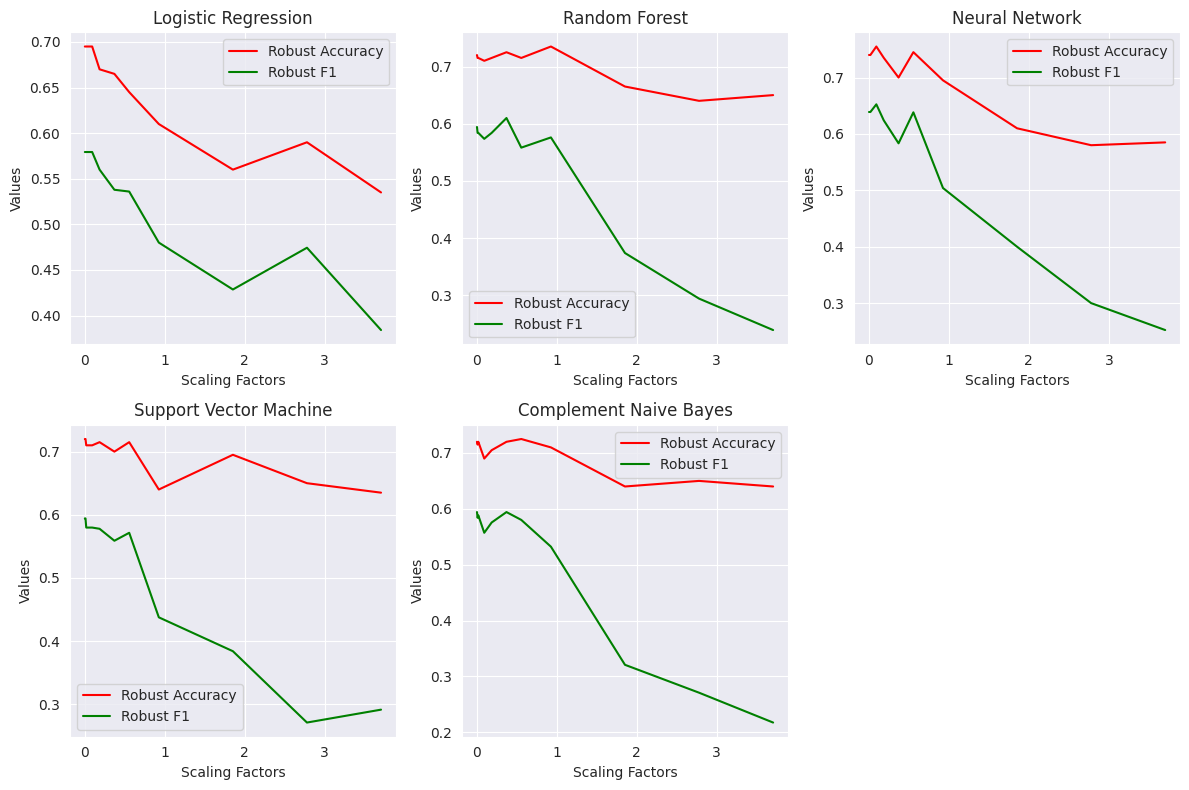

In [75]:
models = ['lr', 'rf', 'nn', 'svm', 'cnb']

# Assume you have data only for 'Robust Accuracy' for each model
robust_accuracy_results = {
    'lr': robust_accuracy_results_lr,
    'rf': robust_accuracy_results_rf,
    'nn': robust_accuracy_results_nn,
    'svm': robust_accuracy_results_svm,
    'cnb': robust_accuracy_results_cnb,
}
robust_f1_results = {
    'lr': robust_f1_results_lr,
    'rf': robust_f1_results_rf,
    'nn': robust_f1_results_nn,
    'svm': robust_f1_results_svm,
    'cnb': robust_f1_results_cnb,
}
# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Flatten the 2D array of axes for easier iteration
fig.delaxes(axes[-1, -1])

# Flatten the 2D array of axes for easier iteration
axes = axes.flatten()[:-1]

# List of titles for each subplot
titles = ['Logistic Regression', 'Random Forest', 'Neural Network', 'Support Vector Machine', 'Complement Naive Bayes']

# List of labels for each subplot
labels = ['Robust Accuracy', 'Robust F1']

# Iterate over axes and plot the available data
for i, ax in enumerate(axes):
    model = models[i]
    
    ax.plot(scalings, robust_accuracy_results[model], color='red', label='Robust Accuracy')
    ax.plot(scalings, robust_f1_results[model], color='green', label='Robust F1')
    ax.set_xlabel('Scaling Factors')
    ax.set_ylabel('Values')
    ax.set_title(titles[i])
    ax.legend()

# Adjust layout to prevent clipping of titles and labels
plt.tight_layout()

# Show the plot
plt.show()

## 4.2 Feature Specific Noise

In [56]:

def robust_accuracy_single_feature(classifier, X_test, column, y_test, euclidean_distance,scaling_factor):
    feature_data_norm = np.linalg.norm(X_test[column])
    scaling_factor_feature = euclidean_distance / feature_data_norm #for each single feature create noisy data with clipped distance from the initial feature values
    noise_feature = generate_clipped_noise(X_test[column], euclidean_distance,scaling_factor_feature)
    X_noisy_feature = X_test.copy()
    X_noisy_feature[column] = noise_feature
    y_pred = classifier.predict(X_noisy_feature)
    # Measure accuracy on which we added noise
    robust_accuracy = accuracy_score(y_test, y_pred)
    robust_f1 = f1_score(y_test, y_pred)

    return robust_accuracy,robust_f1

def robust_feature(model, X_test, y_test, column):
    robust_accuracy_results = []
    robust_f1_results = []
    scalings = []
    for euclidean_distance in euclidean_distances:
        scaling_factor = euclidean_distance / test_data_norm
        robust_acc, robust_f1 = robust_accuracy_single_feature(model, X_test, column, y_test, euclidean_distance,scaling_factor)
        robust_accuracy_results.append(robust_acc)
        robust_f1_results.append(robust_f1)
        scalings.append(scaling_factor)
    robust_df = pd.DataFrame(np.vstack((robust_accuracy_results, robust_f1_results,scalings)),columns=euclidean_distances).rename(
    index={0: "robust_accuracy", 1: "robust_f1",2:"Scaling_Factor"})
    return robust_df



In [57]:
def calculate_robustness(model,features, metric):
    robust_value = []
    for feature in features:
        df = robust_feature(model, X_test, y_test, feature)
        if metric=="Robust Accuracy":
            robust_value.append(np.array(df.iloc[0,:]))
        elif metric=="Robust F1":
            robust_value.append(np.array(df.iloc[1,:]))
        
    return np.array(robust_value)

def feature_values_plot(top5, low5 , metric, title,model):
    low_series = calculate_robustness(model,low5, metric)
    top_series = calculate_robustness(model,top5, metric)        

    plt.figure(figsize=(10, 6))  
    reds = plt.cm.Reds(np.linspace(0.2,1,5))
    blues = plt.cm.Blues(np.linspace(0.2,1,5))
    for i in range(len(low_series)):
        plt.plot(euclidean_distances, low_series[i], label=low5[i], color=blues[i])
        plt.plot(euclidean_distances, top_series[i], label=top5[i], color=reds[i])
        
    plt.xlabel("Euclidean Distance")
    plt.ylabel(metric)
    plt.title(title)
    plt.legend(loc='lower center',bbox_to_anchor=(0.5, -0.3), ncol=6, fancybox=True)
    plt.show()
    
    frame1 = pd.DataFrame(top_series, columns=euclidean_distances, index=top5)
    display(frame1)
    
    frame2 = pd.DataFrame(low_series, columns=euclidean_distances, index=low5)
    display(frame2)

### Logistic Regression

In [55]:
best_5_feat_lr = ["month_duration", "existing_account_A14", "installment_rate","credit_history_A34", "status_sex_A93"]
worst_5_feat_lr = ["job_A171", "purpose_A46", "foreign_A202", "housing_status_A153", "people_liability"]

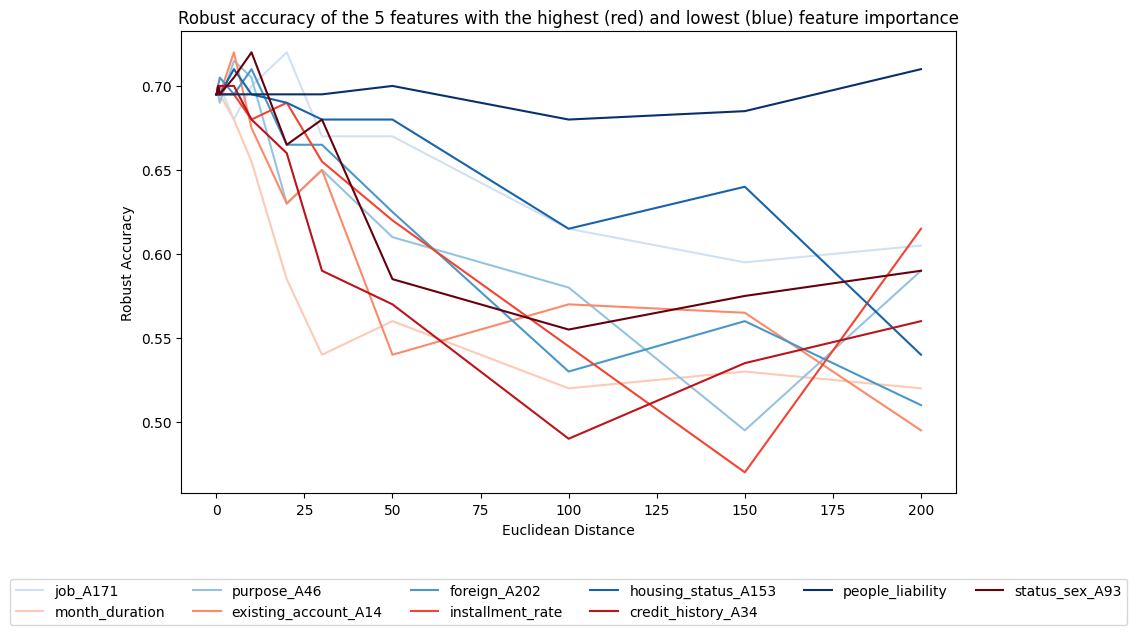

0.05    0.10    0.50    1.00    5.00    10.00   20.00   \
month_duration         0.695   0.695   0.695   0.695   0.680   0.655   0.585   
existing_account_A14   0.695   0.695   0.695   0.695   0.720   0.675   0.630   
installment_rate       0.695   0.695   0.700   0.695   0.695   0.680   0.690   
credit_history_A34     0.695   0.695   0.695   0.700   0.700   0.680   0.660   
status_sex_A93         0.695   0.695   0.700   0.695   0.705   0.720   0.665   

                      30.00   50.00   100.00  150.00  200.00  
month_duration         0.540   0.560   0.520   0.530   0.520  
existing_account_A14   0.650   0.540   0.570   0.565   0.495  
installment_rate       0.655   0.620   0.545   0.470   0.615  
credit_history_A34     0.590   0.570   0.490   0.535   0.560  
status_sex_A93         0.680   0.585   0.555   0.575   0.590

0.05    0.10    0.50    1.00    5.00    10.00   20.00   \
job_A171              0.695   0.695   0.695   0.700   0.680   0.700   0.720   
purpose_A46           0.695   0.695   0.695   0.690   0.715   0.705   0.630   
foreign_A202          0.695   0.695   0.700   0.705   0.695   0.710   0.665   
housing_status_A153   0.695   0.695   0.695   0.695   0.710   0.695   0.690   
people_liability      0.695   0.695   0.695   0.695   0.695   0.695   0.695   

                     30.00   50.00   100.00  150.00  200.00  
job_A171              0.670   0.670   0.615   0.595   0.605  
purpose_A46           0.650   0.610   0.580   0.495   0.590  
foreign_A202          0.665   0.625   0.530   0.560   0.510  
housing_status_A153   0.680   0.680   0.615   0.640   0.540  
people_liability      0.695   0.700   0.680   0.685   0.710

In [296]:
feature_values_plot(best_5_feat_lr, worst_5_feat_lr, "Robust Accuracy", 
                    "Robust accuracy of the 5 features with the highest (red) and lowest (blue) feature importance",logisticregression)

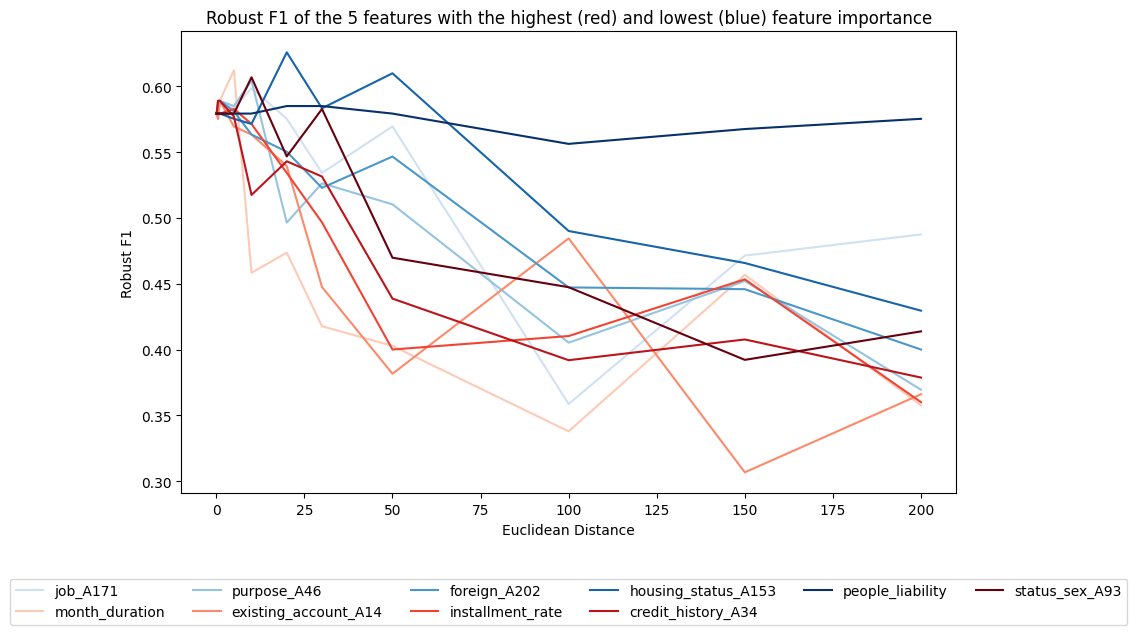

0.05     0.10      0.50      1.00      5.00    \
month_duration        0.57931  0.57931  0.579310  0.589041  0.612245   
existing_account_A14  0.57931  0.57931  0.575342  0.589041  0.569444   
installment_rate      0.57931  0.57931  0.579310  0.579310  0.582781   
credit_history_A34    0.57931  0.57931  0.589041  0.589041  0.577181   
status_sex_A93        0.57931  0.57931  0.579310  0.579310  0.579310   

                        10.00     20.00     30.00     50.00     100.00  \
month_duration        0.458333  0.473684  0.417722  0.402778  0.337838   
existing_account_A14  0.563380  0.539474  0.447552  0.381579  0.484472   
installment_rate      0.571429  0.534247  0.496644  0.400000  0.410256   
credit_history_A34    0.517483  0.543046  0.531469  0.438710  0.391892   
status_sex_A93        0.606897  0.546763  0.582781  0.469799  0.447368   

                        150.00    200.00  
month_duration        0.456790  0.357616  
existing_account_A14  0.306667  0.366013  
installment_rate      0.453333  0.360000  
credit_history_A34    0.407643  0.378698  
status_sex_A93        0.392157  0.413793

0.05     0.10      0.50      1.00      5.00      10.00   \
job_A171             0.57931  0.57931  0.579310  0.589041  0.583333  0.598639   
purpose_A46          0.57931  0.57931  0.575342  0.589041  0.585034  0.604317   
foreign_A202         0.57931  0.57931  0.589041  0.589041  0.581081  0.563380   
housing_status_A153  0.57931  0.57931  0.579310  0.579310  0.575342  0.571429   
people_liability     0.57931  0.57931  0.579310  0.579310  0.579310  0.579310   

                       20.00     30.00     50.00     100.00    150.00  \
job_A171             0.575342  0.534247  0.569536  0.358621  0.471338   
purpose_A46          0.496454  0.526316  0.510345  0.405229  0.452055   
foreign_A202         0.550336  0.522876  0.546667  0.447205  0.445860   
housing_status_A153  0.625850  0.583333  0.609929  0.490066  0.465753   
people_liability     0.585034  0.585034  0.579310  0.556291  0.567568   

                       200.00  
job_A171             0.487500  
purpose_A46          0.369427  
foreign_A202         0.400000  
housing_status_A153  0.429530  
people_liability     0.575342

In [297]:
feature_values_plot(best_5_feat_lr, worst_5_feat_lr, "Robust F1", 
                    "Robust F1 of the 5 features with the highest (red) and lowest (blue) feature importance",logisticregression)

### Random Forest

In [425]:
best_5_feat_rf = ["existing_account_A14","credit_amount","month_duration", "status_sex_A93", "age"]
worst_5_feat_rf = ["purpose_A48", "purpose_A410","property_A123", "existing_account_A12", "property_A121"]

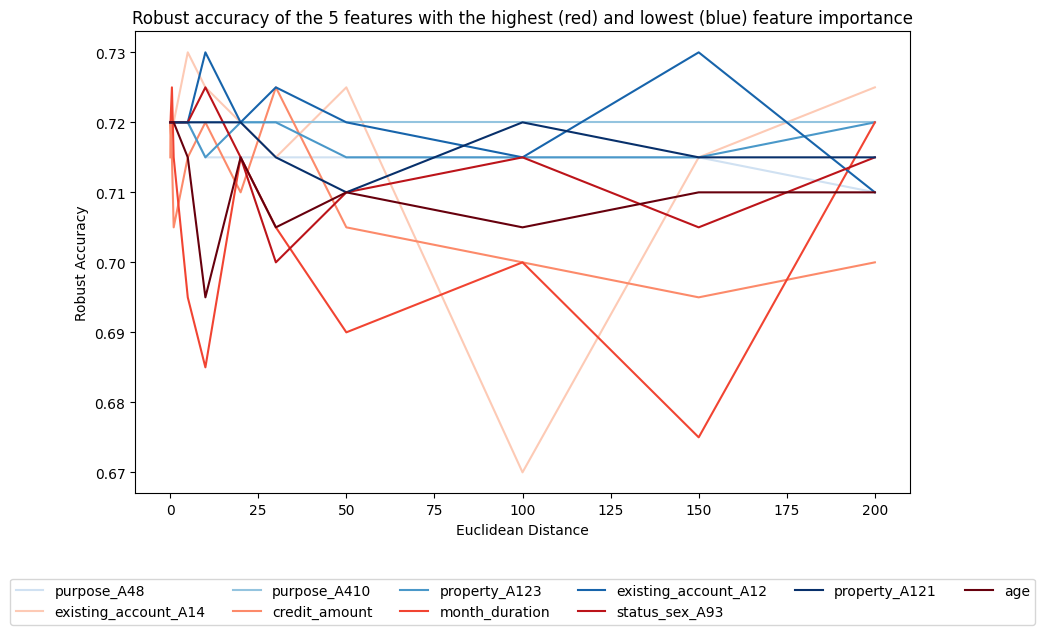

0.05    0.10    0.50    1.00    5.00    10.00   20.00   \
existing_account_A14   0.720    0.72   0.720   0.720   0.730   0.725   0.720   
credit_amount          0.715    0.72   0.715   0.705   0.715   0.720   0.710   
month_duration         0.720    0.72   0.725   0.715   0.695   0.685   0.715   
status_sex_A93         0.720    0.72   0.720   0.720   0.720   0.725   0.715   
age                    0.720    0.72   0.720   0.720   0.715   0.695   0.715   

                      30.00   50.00   100.00  150.00  200.00  
existing_account_A14   0.715   0.725   0.670   0.715   0.725  
credit_amount          0.725   0.705   0.700   0.695   0.700  
month_duration         0.705   0.690   0.700   0.675   0.720  
status_sex_A93         0.700   0.710   0.715   0.705   0.715  
age                    0.705   0.710   0.705   0.710   0.710

0.05    0.10    0.50    1.00    5.00    10.00   20.00   \
purpose_A48             0.72    0.72    0.72    0.72    0.72   0.715   0.715   
purpose_A410            0.72    0.72    0.72    0.72    0.72   0.720   0.720   
property_A123           0.72    0.72    0.72    0.72    0.72   0.715   0.720   
existing_account_A12    0.72    0.72    0.72    0.72    0.72   0.730   0.720   
property_A121           0.72    0.72    0.72    0.72    0.72   0.720   0.720   

                      30.00   50.00   100.00  150.00  200.00  
purpose_A48            0.715   0.715   0.715   0.715   0.710  
purpose_A410           0.720   0.720   0.720   0.720   0.720  
property_A123          0.720   0.715   0.715   0.715   0.720  
existing_account_A12   0.725   0.720   0.715   0.730   0.710  
property_A121          0.715   0.710   0.720   0.715   0.715

In [431]:
feature_values_plot(best_5_feat_rf, worst_5_feat_rf, "Robust Accuracy", 
                    "Robust accuracy of the 5 features with the highest (red) and lowest (blue) feature importance",randomforest)

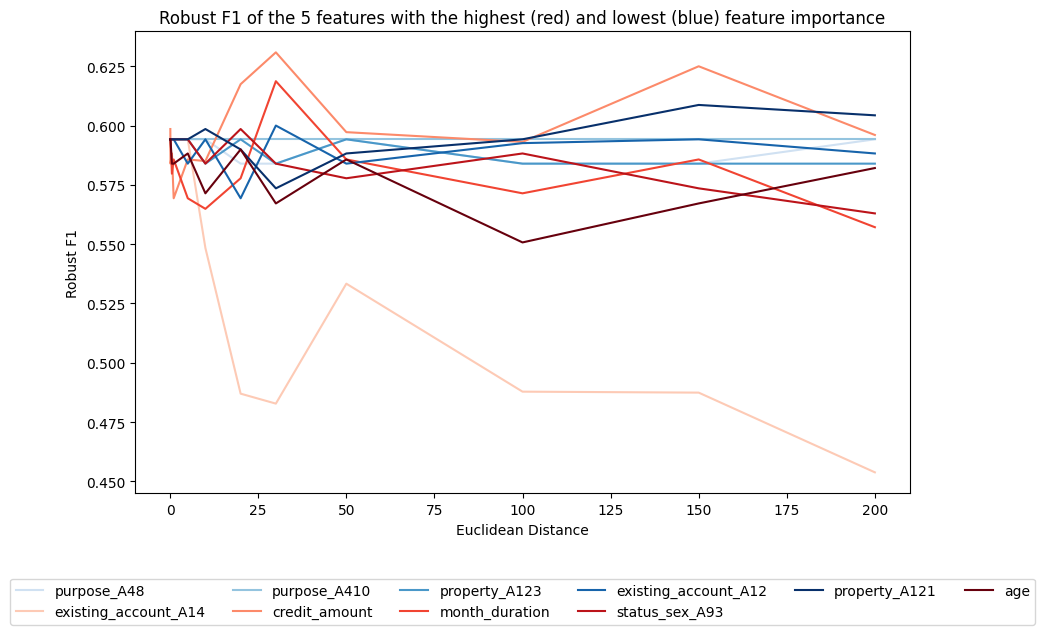

0.05      0.10      0.50      1.00      5.00    \
existing_account_A14  0.594203  0.594203  0.594203  0.594203  0.594203   
credit_amount         0.598540  0.583942  0.588235  0.569343  0.585714   
month_duration        0.594203  0.594203  0.579710  0.585714  0.569343   
status_sex_A93        0.594203  0.594203  0.594203  0.594203  0.594203   
age                   0.594203  0.594203  0.583942  0.583942  0.588235   

                        10.00     20.00     30.00     50.00     100.00  \
existing_account_A14  0.548387  0.486957  0.482759  0.533333  0.487805   
credit_amount         0.585034  0.617450  0.630872  0.597222  0.593103   
month_duration        0.564885  0.577778  0.618705  0.585714  0.571429   
status_sex_A93        0.583942  0.598540  0.583942  0.577778  0.588235   
age                   0.571429  0.589928  0.567164  0.585714  0.550725   

                        150.00    200.00  
existing_account_A14  0.487395  0.453782  
credit_amount         0.625000  0.596026  
month_duration        0.585714  0.557143  
status_sex_A93        0.573529  0.562963  
age                   0.567164  0.582090

0.05      0.10      0.50      1.00      5.00    \
purpose_A48           0.594203  0.594203  0.594203  0.594203  0.594203   
purpose_A410          0.594203  0.594203  0.594203  0.594203  0.594203   
property_A123         0.594203  0.594203  0.594203  0.594203  0.594203   
existing_account_A12  0.594203  0.594203  0.594203  0.594203  0.583942   
property_A121         0.594203  0.594203  0.594203  0.594203  0.594203   

                        10.00     20.00     30.00     50.00     100.00  \
purpose_A48           0.594203  0.583942  0.583942  0.594203  0.583942   
purpose_A410          0.594203  0.594203  0.594203  0.594203  0.594203   
property_A123         0.583942  0.594203  0.583942  0.594203  0.583942   
existing_account_A12  0.594203  0.569343  0.600000  0.583942  0.592593   
property_A121         0.598540  0.589928  0.573529  0.588235  0.594203   

                        150.00    200.00  
purpose_A48           0.583942  0.594203  
purpose_A410          0.594203  0.594203  
property_A123         0.583942  0.583942  
existing_account_A12  0.594203  0.588235  
property_A121         0.608696  0.604317

In [437]:
feature_values_plot(best_5_feat_rf, worst_5_feat_rf, "Robust F1", 
                    "Robust F1 of the 5 features with the highest (red) and lowest (blue) feature importance",randomforest)

### Neural Network

In [446]:
best_5_feat_nn = ["credit_history_A34","credit_amount","month_duration","employment_status_A75","property_A121"]
worst_5_feat_nn = ["property_A121","saving_bonds_A63","foreign_A202","installment_plans_A141","credit_history_A31"]

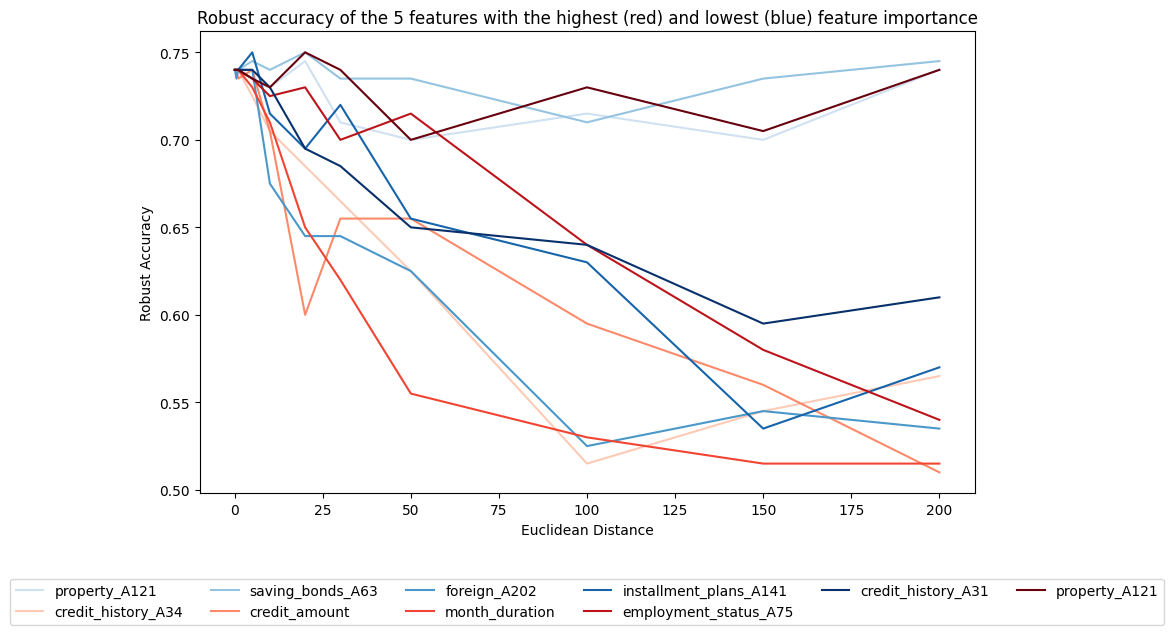

0.05    0.10    0.50    1.00    5.00    10.00   20.00   \
credit_history_A34       0.74    0.74    0.74   0.740   0.725   0.705   0.685   
credit_amount            0.74    0.74    0.74   0.735   0.740   0.705   0.600   
month_duration           0.74    0.74    0.74   0.740   0.730   0.710   0.650   
employment_status_A75    0.74    0.74    0.74   0.740   0.735   0.725   0.730   
property_A121            0.74    0.74    0.74   0.740   0.735   0.730   0.750   

                       30.00   50.00   100.00  150.00  200.00  
credit_history_A34      0.665   0.625   0.515   0.545   0.565  
credit_amount           0.655   0.655   0.595   0.560   0.510  
month_duration          0.620   0.555   0.530   0.515   0.515  
employment_status_A75   0.700   0.715   0.640   0.580   0.540  
property_A121           0.740   0.700   0.730   0.705   0.740

0.05    0.10    0.50    1.00    5.00    10.00   \
property_A121             0.74    0.74   0.740    0.74   0.735   0.730   
saving_bonds_A63          0.74    0.74   0.740    0.74   0.745   0.740   
foreign_A202              0.74    0.74   0.735    0.74   0.740   0.675   
installment_plans_A141    0.74    0.74   0.740    0.74   0.750   0.715   
credit_history_A31        0.74    0.74   0.740    0.74   0.740   0.730   

                        20.00   30.00   50.00   100.00  150.00  200.00  
property_A121            0.745   0.710   0.700   0.715   0.700   0.740  
saving_bonds_A63         0.750   0.735   0.735   0.710   0.735   0.745  
foreign_A202             0.645   0.645   0.625   0.525   0.545   0.535  
installment_plans_A141   0.695   0.720   0.655   0.630   0.535   0.570  
credit_history_A31       0.695   0.685   0.650   0.640   0.595   0.610

In [448]:
feature_values_plot(best_5_feat_nn, worst_5_feat_nn, "Robust Accuracy", 
                    "Robust accuracy of the 5 features with the highest (red) and lowest (blue) feature importance",neuralnetwork)

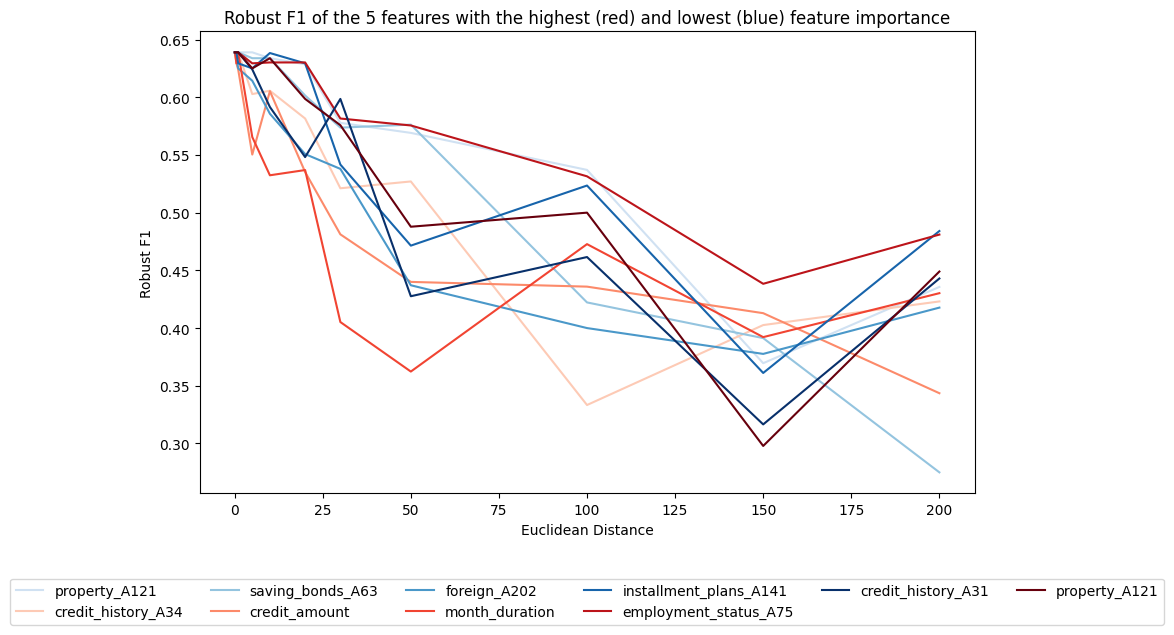

0.05      0.10      0.50      1.00      5.00    \
credit_history_A34     0.638889  0.638889  0.638889  0.638889  0.602740   
credit_amount          0.638889  0.638889  0.629371  0.624113  0.550336   
month_duration         0.638889  0.638889  0.629371  0.638889  0.565517   
employment_status_A75  0.638889  0.638889  0.638889  0.638889  0.629371   
property_A121          0.638889  0.638889  0.638889  0.638889  0.625000   

                         10.00     20.00     30.00     50.00     100.00  \
credit_history_A34     0.605634  0.581560  0.521127  0.527027  0.333333   
credit_amount          0.605263  0.535211  0.481203  0.440000  0.435897   
month_duration         0.532374  0.536913  0.405229  0.362319  0.472727   
employment_status_A75  0.630137  0.630137  0.581560  0.575540  0.531469   
property_A121          0.633803  0.598540  0.575758  0.487805  0.500000   

                         150.00    200.00  
credit_history_A34     0.402597  0.423077  
credit_amount          0.412903  0.343558  
month_duration         0.392157  0.430233  
employment_status_A75  0.438356  0.481013  
property_A121          0.297872  0.448980

0.05      0.10      0.50      1.00      5.00    \
property_A121           0.638889  0.638889  0.638889  0.638889  0.638889   
saving_bonds_A63        0.638889  0.638889  0.638889  0.638889  0.633803   
foreign_A202            0.638889  0.638889  0.634483  0.625000  0.614286   
installment_plans_A141  0.638889  0.638889  0.638889  0.629371  0.625000   
credit_history_A31      0.638889  0.638889  0.638889  0.638889  0.624113   

                          10.00     20.00     30.00     50.00     100.00  \
property_A121           0.633803  0.628571  0.577778  0.569106  0.537037   
saving_bonds_A63        0.633803  0.601504  0.573643  0.576271  0.422222   
foreign_A202            0.585714  0.550725  0.537931  0.437086  0.400000   
installment_plans_A141  0.638298  0.629371  0.541667  0.471429  0.523490   
credit_history_A31      0.591549  0.548148  0.598540  0.427586  0.461538   

                          150.00    200.00  
property_A121           0.369565  0.435644  
saving_bonds_A63        0.391304  0.275000  
foreign_A202            0.377622  0.417722  
installment_plans_A141  0.361111  0.484076  
credit_history_A31      0.316547  0.442953

In [449]:
feature_values_plot(best_5_feat_nn, worst_5_feat_nn, "Robust F1", 
                    "Robust F1 of the 5 features with the highest (red) and lowest (blue) feature importance",neuralnetwork)

### Support Vector Machine

In [423]:
best_5_feat_svm = ["month_duration", "saving_bonds_A61", "credit_amount","status_sex_A93","saving_bonds_A64"]
worst_5_feat_svm = ["debts_status_A101", "housing_status_A153", "purpose_A49", "people_liability","installment_plans_A143"]

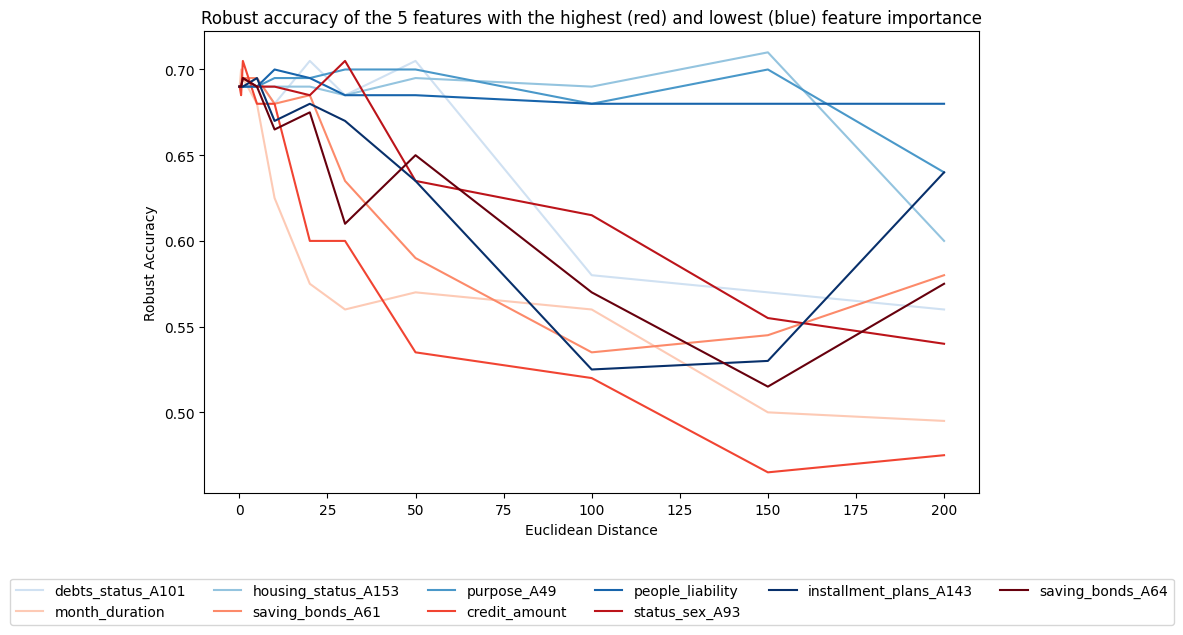

0.05    0.10    0.50    1.00    5.00    10.00   20.00   \
month_duration      0.69    0.69   0.700   0.695   0.680   0.625   0.575   
saving_bonds_A61    0.69    0.69   0.690   0.695   0.695   0.680   0.685   
credit_amount       0.69    0.69   0.685   0.705   0.680   0.680   0.600   
status_sex_A93      0.69    0.69   0.690   0.695   0.690   0.690   0.685   
saving_bonds_A64    0.69    0.69   0.690   0.695   0.690   0.665   0.675   

                  30.00   50.00   100.00  150.00  200.00  
month_duration     0.560   0.570   0.560   0.500   0.495  
saving_bonds_A61   0.635   0.590   0.535   0.545   0.580  
credit_amount      0.600   0.535   0.520   0.465   0.475  
status_sex_A93     0.705   0.635   0.615   0.555   0.540  
saving_bonds_A64   0.610   0.650   0.570   0.515   0.575

0.05    0.10    0.50    1.00    5.00    10.00   \
debts_status_A101         0.69    0.69    0.69    0.69   0.695   0.680   
housing_status_A153       0.69    0.69    0.69    0.69   0.690   0.690   
purpose_A49               0.69    0.69    0.69    0.69   0.690   0.695   
people_liability          0.69    0.69    0.69    0.69   0.690   0.700   
installment_plans_A143    0.69    0.69    0.69    0.69   0.695   0.670   

                        20.00   30.00   50.00   100.00  150.00  200.00  
debts_status_A101        0.705   0.685   0.705   0.580    0.57    0.56  
housing_status_A153      0.690   0.685   0.695   0.690    0.71    0.60  
purpose_A49              0.695   0.700   0.700   0.680    0.70    0.64  
people_liability         0.695   0.685   0.685   0.680    0.68    0.68  
installment_plans_A143   0.680   0.670   0.635   0.525    0.53    0.64

In [424]:
feature_values_plot(best_5_feat_svm, worst_5_feat_svm, "Robust Accuracy", 
                    "Robust accuracy of the 5 features with the highest (red) and lowest (blue) feature importance",svm)

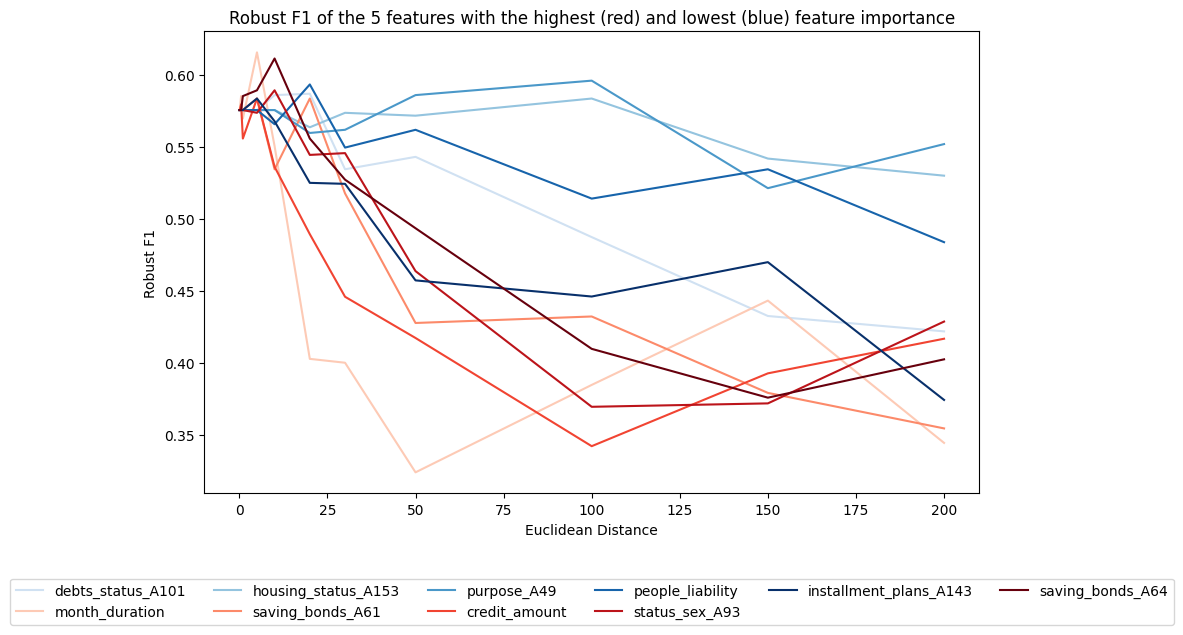

0.05      0.10      0.50      1.00      5.00      10.00   \
month_duration    0.575342  0.575342  0.585034  0.569444  0.615385  0.550336   
saving_bonds_A61  0.575342  0.575342  0.575342  0.575342  0.583333  0.534247   
credit_amount     0.575342  0.575342  0.579310  0.555556  0.583333  0.535948   
status_sex_A93    0.575342  0.575342  0.575342  0.575342  0.573427  0.589041   
saving_bonds_A64  0.575342  0.575342  0.575342  0.585034  0.589041  0.611111   

                    20.00     30.00     50.00     100.00    150.00    200.00  
month_duration    0.402685  0.400000  0.323944  0.384615  0.443114  0.344371  
saving_bonds_A61  0.583333  0.517483  0.427586  0.432099  0.379085  0.354430  
credit_amount     0.489209  0.445783  0.417178  0.342105  0.392638  0.416667  
status_sex_A93    0.544218  0.545455  0.463576  0.369427  0.371795  0.428571  
saving_bonds_A64  0.555556  0.527027  0.493333  0.409639  0.375758  0.402367

0.05      0.10      0.50      1.00      5.00    \
debts_status_A101       0.575342  0.575342  0.575342  0.575342  0.575342   
housing_status_A153     0.575342  0.575342  0.575342  0.575342  0.575342   
purpose_A49             0.575342  0.575342  0.575342  0.575342  0.575342   
people_liability        0.575342  0.575342  0.575342  0.575342  0.575342   
installment_plans_A143  0.575342  0.575342  0.575342  0.575342  0.583333   

                          10.00     20.00     30.00     50.00     100.00  \
debts_status_A101       0.585714  0.586667  0.534247  0.542857  0.487179   
housing_status_A153     0.575342  0.563380  0.573427  0.571429  0.583333   
purpose_A49             0.575342  0.559441  0.561644  0.585714  0.595745   
people_liability        0.565517  0.593103  0.549296  0.561644  0.513889   
installment_plans_A143  0.567568  0.524823  0.524138  0.457143  0.445946   

                          150.00    200.00  
debts_status_A101       0.432432  0.421769  
housing_status_A153     0.541667  0.529801  
purpose_A49             0.521127  0.551724  
people_liability        0.534247  0.483660  
installment_plans_A143  0.469799  0.374194

In [425]:
feature_values_plot(best_5_feat_svm, worst_5_feat_svm, "Robust F1", 
                    "Robust F1 of the 5 features with the highest (red) and lowest (blue) feature importance",svm)

### Complement Naive Bayes

In [477]:
best_5_feat_cnb = ["credit_history_A30", "saving_bonds_A64", "credit_history_A34","existing_account_A11","debts_status_A102"]
worst_5_feat_cnb = ["credit_amount", "housing_status_A153", "existing_account_A12", "purpose_A43","purpose_A40"]

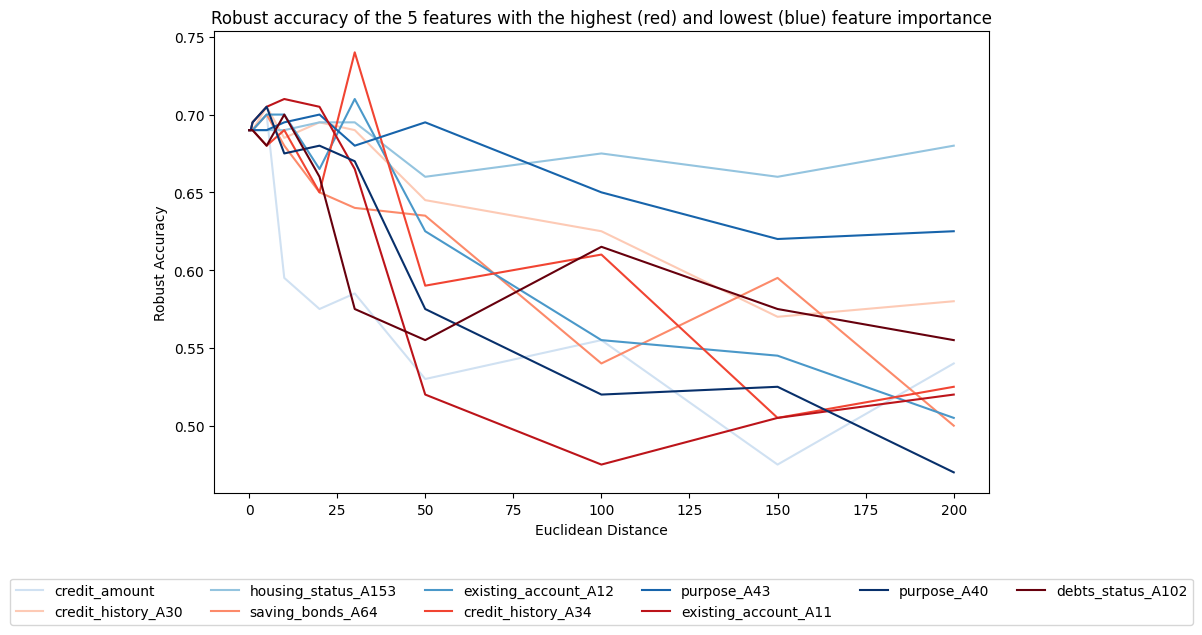

0.05    0.10    0.50    1.00    5.00    10.00   20.00   \
credit_history_A30      0.69    0.69    0.69   0.690   0.705   0.685   0.695   
saving_bonds_A64        0.69    0.69    0.69   0.690   0.700   0.680   0.650   
credit_history_A34      0.69    0.69    0.69   0.690   0.680   0.690   0.650   
existing_account_A11    0.69    0.69    0.69   0.695   0.705   0.710   0.705   
debts_status_A102       0.69    0.69    0.69   0.690   0.680   0.700   0.660   

                      30.00   50.00   100.00  150.00  200.00  
credit_history_A30     0.690   0.645   0.625   0.570   0.580  
saving_bonds_A64       0.640   0.635   0.540   0.595   0.500  
credit_history_A34     0.740   0.590   0.610   0.505   0.525  
existing_account_A11   0.665   0.520   0.475   0.505   0.520  
debts_status_A102      0.575   0.555   0.615   0.575   0.555

0.05    0.10    0.50    1.00    5.00    10.00   20.00   \
credit_amount           0.69    0.69    0.69   0.690   0.700   0.595   0.575   
housing_status_A153     0.69    0.69    0.69   0.690   0.690   0.690   0.695   
existing_account_A12    0.69    0.69    0.69   0.690   0.700   0.700   0.665   
purpose_A43             0.69    0.69    0.69   0.690   0.690   0.695   0.700   
purpose_A40             0.69    0.69    0.69   0.695   0.705   0.675   0.680   

                      30.00   50.00   100.00  150.00  200.00  
credit_amount          0.585   0.530   0.555   0.475   0.540  
housing_status_A153    0.695   0.660   0.675   0.660   0.680  
existing_account_A12   0.710   0.625   0.555   0.545   0.505  
purpose_A43            0.680   0.695   0.650   0.620   0.625  
purpose_A40            0.670   0.575   0.520   0.525   0.470

In [478]:
feature_values_plot(best_5_feat_cnb, worst_5_feat_cnb, "Robust Accuracy", 
                    "Robust accuracy of the 5 features with the highest (red) and lowest (blue) feature importance",svm)

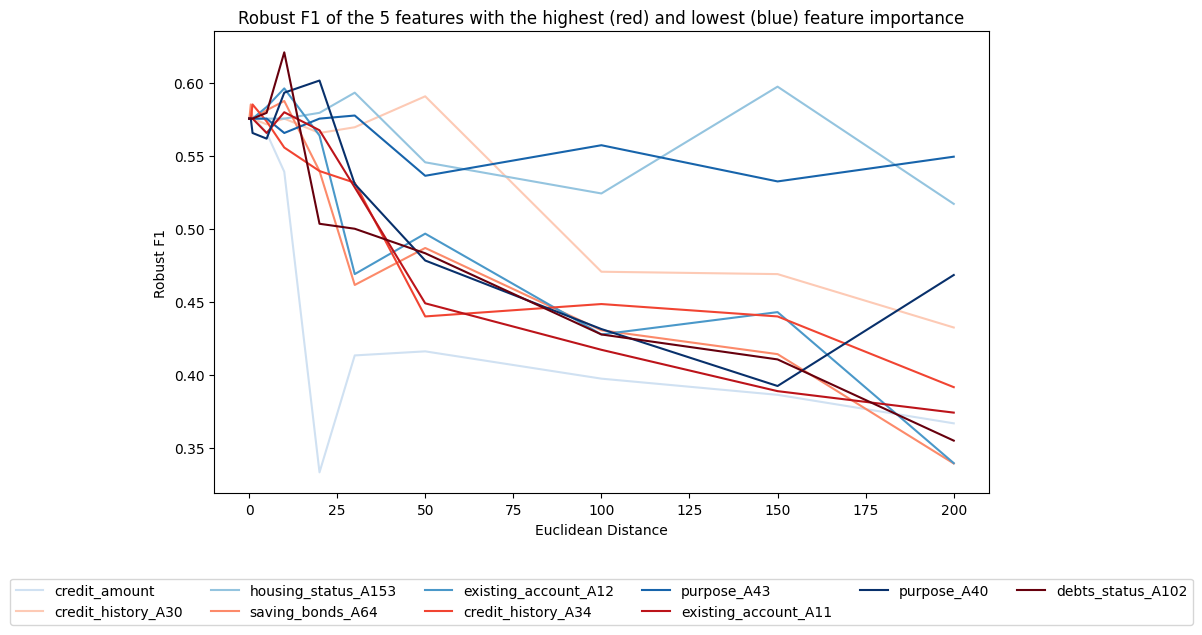

0.05      0.10      0.50      1.00      5.00    \
credit_history_A30    0.575342  0.575342  0.575342  0.575342  0.571429   
saving_bonds_A64      0.575342  0.575342  0.585034  0.575342  0.581081   
credit_history_A34    0.575342  0.575342  0.575342  0.585034  0.573427   
existing_account_A11  0.575342  0.575342  0.575342  0.575342  0.565517   
debts_status_A102     0.575342  0.575342  0.575342  0.575342  0.579310   

                        10.00     20.00     30.00     50.00     100.00  \
credit_history_A30    0.575342  0.565517  0.569444  0.590604  0.470588   
saving_bonds_A64      0.587413  0.539474  0.461538  0.486842  0.430556   
credit_history_A34    0.555556  0.539474  0.531469  0.440000  0.448485   
existing_account_A11  0.579710  0.567376  0.528302  0.448980  0.417178   
debts_status_A102     0.620690  0.503401  0.500000  0.483221  0.427673   

                        150.00    200.00  
credit_history_A30    0.468966  0.432432  
saving_bonds_A64      0.414201  0.339394  
credit_history_A34    0.440000  0.391608  
existing_account_A11  0.388889  0.374194  
debts_status_A102     0.410596  0.355030

0.05      0.10      0.50      1.00      5.00    \
credit_amount         0.575342  0.575342  0.579310  0.577181  0.565517   
housing_status_A153   0.575342  0.575342  0.575342  0.575342  0.575342   
existing_account_A12  0.575342  0.575342  0.575342  0.575342  0.583333   
purpose_A43           0.575342  0.575342  0.575342  0.575342  0.575342   
purpose_A40           0.575342  0.575342  0.575342  0.565517  0.561644   

                        10.00     20.00     30.00     50.00     100.00  \
credit_amount         0.539007  0.333333  0.413333  0.416107  0.397436   
housing_status_A153   0.575342  0.579310  0.593103  0.545455  0.524138   
existing_account_A12  0.596026  0.563758  0.468966  0.496644  0.427673   
purpose_A43           0.565517  0.575342  0.577465  0.536232  0.557143   
purpose_A40           0.593103  0.601399  0.530612  0.478261  0.431373   

                        150.00    200.00  
credit_amount         0.386364  0.366864  
housing_status_A153   0.597222  0.517007  
existing_account_A12  0.442953  0.339623  
purpose_A43           0.532374  0.549296  
purpose_A40           0.392405  0.468354

In [479]:
feature_values_plot(best_5_feat_cnb, worst_5_feat_cnb, "Robust F1", 
                    "Robust F1 of the 5 features with the highest (red) and lowest (blue) feature importance",svm)

## 4.3


In [9]:
onehot_y_train = pd.get_dummies(y_train_validation)
onehot_y_test = pd.get_dummies(y_test)
tf.compat.v1.disable_eager_execution() # needed for ART. Run this line only for 4.3 and 4.4 points, as the eager_execution is needed by tensorflow in points 3 when building the NN.
class_labels = np.unique(y_train_validation)
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=y_train_validation)
class_weight_dict = dict(zip(class_labels,class_weights))

In [10]:
def build_model_ART():
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(X_train_validation.shape[1],)))
    model.add(Dense(2, activation='sigmoid'))

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [11]:
def build_classifier():
    classifier = ARTKerasClassifier(model=build_model_ART())
    classifier.fit(X_train_validation_normalized, onehot_y_train, batch_size=64, nb_epochs=40, class_weight=class_weight_dict)
    return classifier

# Gradient Based attacks

## Solve inner maximization

The common approach to training a classifier is to optimize the parameters $ \theta $, so as to minimize the average loss over some training set which we write as the optimization problem (formula) which we typically solve by (stochastic) gradient descent. In other words, for some minibatch (a small subset of the training data) we compute the gradient of our loss with respect to the parameters $\theta$. Then we make a small adjustment to $ \theta $ (formula) using $\alpha$ as some step size, and we repeat this process  for different minibatches covering the entire training set, until the parameters converge. 

We have seen that in NN the gradient is computed efficiently with backpropagation. If we compute the gradient of the loss with respect to the input $ x_i$ the result will tell us how small changes to the data affect the loss function. With adversarial examples instead of adjusting the parameters to minimize the loss we try to adjust them to **maximixe** the loss. In other words our aim is to ensure that our adversarial example is close to our original input optimizing over the perturbation $ \delta $ to x.

A common perturbation set to use is the $L^{inf}$ ball (norm) (formula). We allow the perturbation to have magnitude between $[−\epsilon,\epsilon]$

## FGSM 
FGSM is a white box, non-targeted evasion attack. Non-targeted means that we are trying to maximize the loss for the true class label. 
With FGSM in order to maximize the loss we want to adjust the $\delta$ in the direction of the gradient i.e. take a step and then project back into the norm ball defined by $||\delta|| \leq \epsilon$. If we want to make increase the loss as much as possible we need to take the as lage a step possible. 
For large $\alpha$ the update becomes $\delta := \epsilon \cdot \mathrm{sign}(g)$. Epsilon controls the magnitude of the perturbations. FGSM calculates the gradient only once. This method is not designed to find the minimal perturbations, so it would result in larger perturbations and also requires manual adjustment of the parameter of $\epsilon$ to get desired results

In [12]:
def FGSM(classifier):
    fgm_range = np.arange(0.0, 2, 0.1)
    fgm_acc=[]
    for eps in fgm_range:
        attack_FGM = FastGradientMethod(estimator=classifier, eps=eps)
        Xtest_FGM = pd.DataFrame(attack_FGM.generate(x=np.array(X_test)),columns=X_test.columns)
        preds_FGM = classifier.predict(Xtest_FGM)
        accuracy_FGM = np.sum(np.argmax(preds_FGM, axis=1) == onehot_y_test.idxmax(axis=1)) / len(onehot_y_test)
        fgm_acc.append(accuracy_FGM)
    
    '''PLOT'''
    plt.figure(figsize=(10,5))
    plt.title("FSGM")
    plt.ylabel('Accuracy')
    plt.xlabel('Epsilon')
    plt.ylim((0,1))
    plt.plot(fgm_range, fgm_acc)
    
    plt.show()
    print("Accuracy on adversarial test examples with FGSM attack: {}%".format(accuracy_FGM * 100))
    print(f"Steps of accuracy {fgm_acc}")
    return Xtest_FGM, attack_FGM

FGSM is just a single projected gradient descent step under the $L^{inf}$ constraint. 

2024-01-29 16:11:06.557360: W tensorflow/c/c_api.cc:305] Operation '{name:'training_4/Adam/dense_5/kernel/v/Assign' id:1211 op device:{requested: '', assigned: ''} def:{{{node training_4/Adam/dense_5/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_4/Adam/dense_5/kernel/v, training_4/Adam/dense_5/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-01-29 16:11:07.147296: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_5/Sigmoid' id:904 op device:{reque

Accuracy on benign test examples: 72.5%

FGSM


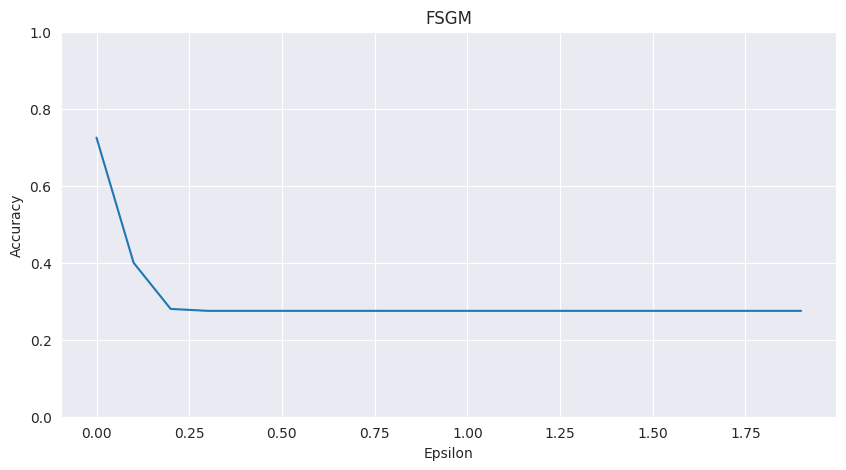

Accuracy on adversarial test examples with FGSM attack: 27.500000000000004%
Steps of accuracy [0.725, 0.4, 0.28, 0.275, 0.275, 0.275, 0.275, 0.275, 0.275, 0.275, 0.275, 0.275, 0.275, 0.275, 0.275, 0.275, 0.275, 0.275, 0.275, 0.275]


In [15]:
classifier = build_classifier()
predictions_benign = classifier.predict(X_test)
accuracy = np.sum(np.argmax(predictions_benign, axis=1) == onehot_y_test.idxmax(axis=1)) / len(onehot_y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))
print('\nFGSM')
Xtest_FGM, attack_FGM = FGSM(classifier)

## PGD $L^{inf}$

The basic approach of PGD is to re-iterate the updates that we have seen with FGSM. With PGD we have more choices such as the actual stepsize itself, and the number of iterations. PGD is also a white-box, non-targeted evasion attack. White-box, since we need to know the gradients of the model to create the adversarial examples. PGD calculates the gradient multiple times. PGD attempts to find the perturbation that maximises the loss of a model on a particular input while keeping the size of the perturbation smaller than $\epsilon$.

PGD performance is limited by the possibility of local optima within the objective. To partial overcome this problem, we don’t just run PGD once, but we run it multiple times from different random locations within the $L^{inf}$ ball.   

In [120]:
def PGD(classifier, target, y_target, norm, X_target=X_test, y_test_target=onehot_y_test):
    PGD_range = np.arange(0.0, 2, 0.1)
    PGD_acc = []
    for eps in PGD_range:
        if(norm == 2):
            attack_PGD = ProjectedGradientDescent(classifier, eps=eps, eps_step=0.1, max_iter=100, num_random_init=1, targeted=target, verbose=False, norm=norm)
        else:
            attack_PGD = ProjectedGradientDescent(classifier, eps=eps, eps_step=0.1, max_iter=100, num_random_init=1, targeted=target, verbose=False)
        
        if(y_target.all()):
            X_test_PGD = pd.DataFrame(attack_PGD.generate(x=np.array(X_target)),columns=X_test.columns)
        else:
            X_test_PGD = pd.DataFrame(attack_PGD.generate(x=np.array(X_target),y=np.array(y_target)),columns=X_test.columns)
            
        preds_PGD = classifier.predict(X_test_PGD)
        if target != True:
            accuracy_PGD = np.sum(np.argmax(preds_PGD, axis=1) == y_test_target.idxmax(axis=1)) / len(onehot_y_test)
        else:
            accuracy_PGD = np.sum(np.argmax(preds_PGD, axis=1) == np.argmax(y_test_target, axis=1)) / len(y_test_target)
        PGD_acc.append(accuracy_PGD)
    
    '''PLOT'''
    plt.figure(figsize=(10,5))
    if(y_target.all()): 
        if(norm == 2):
            plt.title("Untargeted PGD $L^{2}$") 
        else:
            plt.title("Untargeted PGD $L^{inf}$") 
    else: plt.title("Targeted PGD $L^{inf}$")
        
    plt.ylabel('Accuracy')
    plt.xlabel('Epsilon')
    plt.ylim((0,1))
    plt.plot(PGD_range, PGD_acc)
    
    plt.show()
    print("Accuracy on adversarial test examples with PGD attack: {}%".format(accuracy_PGD * 100))
    print(f"Steps of accuracy {PGD_acc}")
    return X_test_PGD, attack_PGD

2024-01-28 12:40:29.673752: W tensorflow/c/c_api.cc:305] Operation '{name:'training_20/Adam/dense_25/kernel/m/Assign' id:4773 op device:{requested: '', assigned: ''} def:{{{node training_20/Adam/dense_25/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_20/Adam/dense_25/kernel/m, training_20/Adam/dense_25/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-01-28 12:40:30.386928: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_25/Sigmoid' id:4488 op dev

Accuracy on benign test examples: 71.5%
PGD


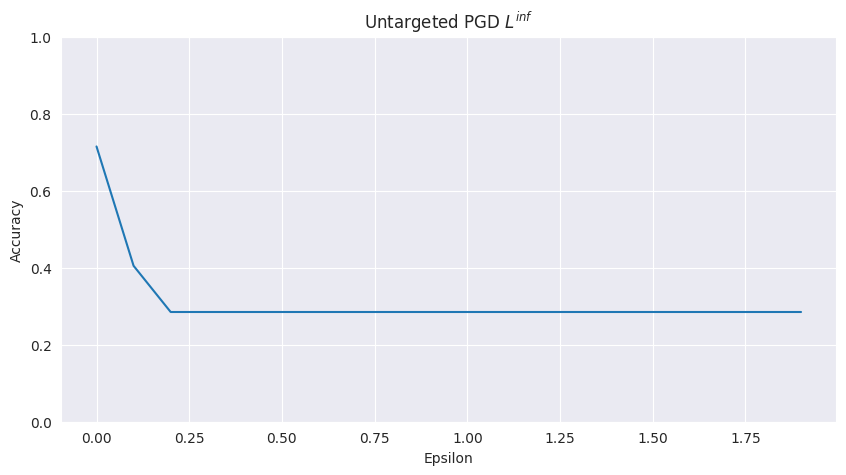

Accuracy on adversarial test examples with PGD attack: 28.499999999999996%
Steps of accuracy [0.715, 0.405, 0.285, 0.285, 0.285, 0.285, 0.285, 0.285, 0.285, 0.285, 0.285, 0.285, 0.285, 0.285, 0.285, 0.285, 0.285, 0.285, 0.285, 0.285]


In [42]:
classifier = build_classifier()
predictions_benign = classifier.predict(X_test)
accuracy = np.sum(np.argmax(predictions_benign, axis=1) == onehot_y_test.idxmax(axis=1)) / len(onehot_y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))
print('PGD')
X_test_PGD_uinf, attack_PGD_uinf = PGD(classifier, False, np.empty(0), np.inf)

## Targeted PGD $L^{inf}$

In this case ninstead of maximizing the loss of the true label, we maximize the loss of the loss of the true label and also minimize the loss for the alternative label.

2024-01-28 22:09:51.049967: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_8/bias/Assign' id:1210 op device:{requested: '', assigned: ''} def:{{{node dense_8/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_8/bias, dense_8/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


PGD
Accuracy on benign test examples: 53.333333333333336%


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-01-28 22:09:51.704146: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_9/Sigmoid' id:1240 op device:{requested: '', assigned: ''} def:{{{node dense_9/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_9/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


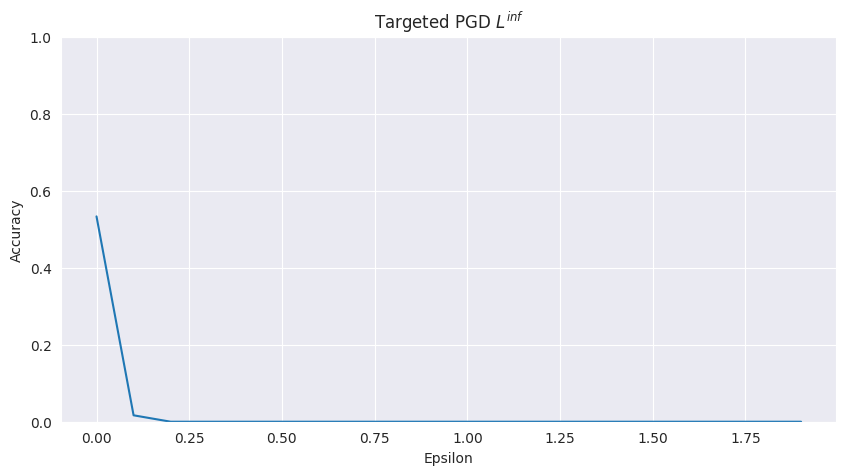

Accuracy on adversarial test examples with PGD attack: 0.0%
Steps of accuracy [0.5333333333333333, 0.016666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [123]:
y_train_new = onehot_y_train.reset_index(drop=True)                 # reset index
index_train = y_train_new[y_train_new[1] == True].index             # save indexes of all rows with label 1 = True from y_train 
X_train_targeted = X_train_validation_normalized.iloc[index_train].copy()  # Take only rows from X_train_validation which have Label 1 = True in y_train

y_train_targeted = y_train_new[y_train_new[1] == True].copy()       # copy y_train with label 1 = True
classifier_targeted = ARTKerasClassifier(model=build_model_ART())        
classifier_targeted.fit(X_train_validation_normalized, onehot_y_train, batch_size=64, nb_epochs=40) # fit with X_target and y_target (rows which have label 1 = True)
print('PGD')
y_test_new = onehot_y_test.reset_index(drop=True)                   # Same thing as above but swapping label 1 = True with Label 1 = False for y_target
index = y_test_new[y_test_new[1]==True].index
X_target = X_test.iloc[index]

y_target = y_test_new[y_test_new[1]==True].copy()
y_test_target = y_test_new[y_test_new[1]==True].copy()

y_target.iloc[:, 0] = 1
y_target.iloc[:, 1] = 0

predictions_benign = classifier_targeted.predict(X_target)
accuracy = np.sum(np.argmax(predictions_benign, axis=1) == y_test_target.idxmax(axis=1)) / len(y_test_target)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

X_test_PGD_tinf, attack_PGD_tinf = PGD(classifier_targeted, True, np.array(y_target), np.inf, X_target, np.array(y_test_target))

## PGD $L^{2}$

In this case the $\epsilon$ we need to consider for $L^2$ norm perturbations is larger than what we need for $L^{inf}$ perturbations, because the volume of the $L^2$ ball is proportional to $\sqrt{n}$ times the volume of the $L^{inf}$ ball.

It's important to note that this means that $L^{inf}$ attacks lead to small noise (not good for adversarial training defence) comparing to $L^2$ attack.

2024-01-28 01:05:46.730637: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_51/kernel/Assign' id:9937 op device:{requested: '', assigned: ''} def:{{{node dense_51/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_51/kernel, dense_51/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-01-28 01:05:48.954937: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_51/Sigmoid' id:9948 op device:{requested: '', assigned: ''} def:{{{node dense_51/Si

Accuracy on benign test examples: 72.0%
PGD


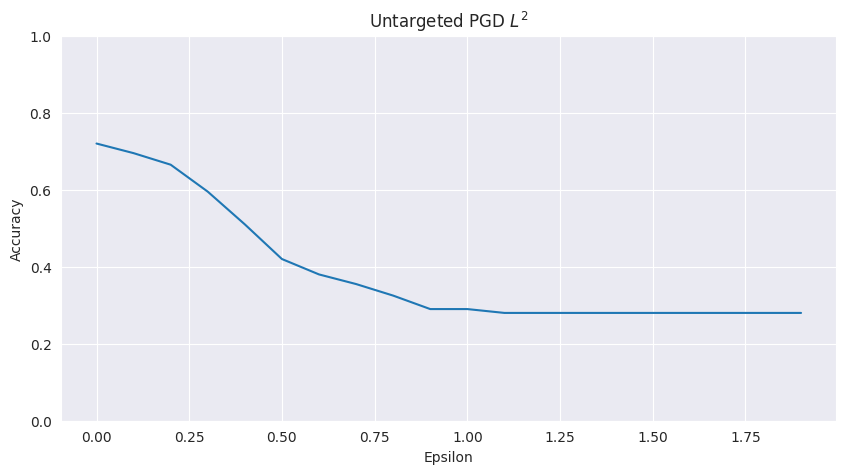

Accuracy on adversarial test examples with PGD attack: 28.000000000000004%
Steps of accuracy [0.72, 0.695, 0.665, 0.595, 0.51, 0.42, 0.38, 0.355, 0.325, 0.29, 0.29, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28, 0.28]


In [55]:
classifier = build_classifier()
predictions_benign = classifier.predict(X_test)
accuracy = np.sum(np.argmax(predictions_benign, axis=1) == onehot_y_test.idxmax(axis=1)) / len(onehot_y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))
print('PGD')
X_test_PGD_u2, attack_PGD_u2 = PGD(classifier, False, np.empty(0), 2)

## DeepFool 

DeepFool is a white-box attack. The goal of the DeepFool attack is to generate a minimal perturbation to an input data point that causes the classifier to misclassify it. The attack is iterative and works by computing the gradient of the classifier's decision boundary with respect to the input features. DeepFool calculates the minimal perturbation needed to move the input point across the decision boundary and iteratively adjusts the input in the direction that is orthogonal to the decision boundary. The perturbation is then calculated by considering the linear approximation of the decision boundary. It aims to minimize the distance between the original input and the perturbed input, while ensuring misclassification. 

DeepFool algorithm computes the perturbation by having the output prediction of the classifier decision function divided by the L2 norm of the computed gradient of the loss function.  (formula)

In [58]:
classifier=build_classifier()
predictions_benign = classifier.predict(X_test)
accuracy = np.sum(np.argmax(predictions_benign, axis=1) == onehot_y_test.idxmax(axis=1)) / len(onehot_y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

attack_DF = DeepFool(classifier=classifier)
Xtest_DF = pd.DataFrame(attack_DF.generate(x=np.array(X_test)),columns=X_test.columns)
preds_DF = classifier.predict(Xtest_DF)
accuracy_DF = np.sum(np.argmax(preds_DF, axis=1) == onehot_y_test.idxmax(axis=1)) / len(onehot_y_test)
print("Accuracy on adversarial test examples with DF attack: {}%".format(accuracy_DF * 100))

2024-01-28 13:05:00.378287: W tensorflow/c/c_api.cc:305] Operation '{name:'training_36/Adam/learning_rate/Assign' id:7678 op device:{requested: '', assigned: ''} def:{{{node training_36/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_36/Adam/learning_rate, training_36/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-01-28 13:05:01.200978: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_37/Sigmoid' id:7410 op device:{req

Accuracy on benign test examples: 75.0%


DeepFool: 100%|██████████| 200/200 [00:00<00:00, 270.07it/s]

Accuracy on adversarial test examples with DF attack: 25.0%


# Decision Based Attack

A decision based attack is a black-box attack which generates adversarial samples via iterative optimizations using repeated queries. This is a powerful black-box attack because only requires final class prediction. They try not to rely on any classifier specific information (like gradients), except final decisions. 

## HopSkipJump 
HSJ is an optimization-based attack that iteratively refines the perturbation to move the input across the decision boundary while minimizing the perturbation size

In [45]:
classifier=build_classifier()
predictions_benign = classifier.predict(X_test)
accuracy = np.sum(np.argmax(predictions_benign, axis=1) == onehot_y_test.idxmax(axis=1)) / len(onehot_y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

attack_HSJ = HopSkipJump(classifier=classifier)
Xtest_HSJ = pd.DataFrame(attack_HSJ.generate(np.array(X_test)),columns=X_test.columns)
preds_HSJ = classifier.predict(Xtest_HSJ)
accuracy_HSJ = np.sum(np.argmax(preds_HSJ, axis=1) == onehot_y_test.idxmax(axis=1)) / len(onehot_y_test)
print("Accuracy on adversarial test examples with HSJ attack: {}%".format(accuracy_HSJ * 100))

2024-01-28 12:47:57.360011: W tensorflow/c/c_api.cc:305] Operation '{name:'training_24/Adam/dense_29/bias/v/Assign' id:5653 op device:{requested: '', assigned: ''} def:{{{node training_24/Adam/dense_29/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_24/Adam/dense_29/bias/v, training_24/Adam/dense_29/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-01-28 12:47:58.091054: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_29/Sigmoid' id:5341 op device:{req

Accuracy on benign test examples: 71.5%


HopSkipJump: 100%|██████████| 200/200 [04:34<00:00,  1.37s/it]

Accuracy on adversarial test examples with HSJ attack: 28.499999999999996%


## 4.4 Adversarial Training with ART AdversarialTrainer

The basic idea is to simply create and then incorporate adversarial examples into the training process.

## Gradient-based

### Adversarial Training FGSM

In [16]:
def adversarialTrainingFGM(classifier, attack, X_test, X_test_attack, X_train, y_train, eps):
    # Create adversarial trainer and perform adversarial training
    adv_trainer = AdversarialTrainer(classifier, attacks=attack, ratio=0.5)
    adv_trainer.fit(X_train_validation_normalized.values, onehot_y_train.values, batch_size=64, nb_epochs=40, class_weight=class_weight_dict)
    
    # Evaluate the adversarially trained model on clean test set
    predictions_clean = adv_trainer.predict(X_test)
    accuracy_clean = np.sum(np.argmax(predictions_clean, axis=1) == onehot_y_test.idxmax(axis=1)) / len(onehot_y_test)
    print("Accuracy on clean test examples with adversarially trained model: {}%".format(accuracy_clean * 100))
    
    # Evaluate the adversarially trained model on original adversarial samples
    preds_ATTACK_original = adv_trainer.predict(X_test_attack)
    accuracy_original = np.sum(np.argmax(preds_ATTACK_original, axis=1) == onehot_y_test.idxmax(axis=1)) / len(onehot_y_test)
    print("Accuracy on original adversarial examples with adversarially trained model: {}%".format(accuracy_original * 100))
    
    # Evaluate the adversarially trained model on fresh adversarial samples produced on the adversarially trained model
    attack_FGM = FastGradientMethod(estimator=adv_trainer.get_classifier(), eps=eps)
    X_test_ATTACK_new = attack_FGM.generate(x=np.array(X_test))       
    preds_ATTACK_new = adv_trainer.predict(X_test_ATTACK_new)
    accuracy_new = np.sum(np.argmax(preds_ATTACK_new, axis=1) == onehot_y_test.idxmax(axis=1)) / len(onehot_y_test)
    print("Accuracy on new adversarial examples with adversarially trained model: {}%".format(accuracy_new * 100))
    return attack_FGM, adv_trainer.get_classifier()

In [20]:
print("Retrieving Accuracy on benign test examples: {}%".format(accuracy * 100))
classifier_FGM = ARTKerasClassifier(model=build_model_ART())
Xtest_FGM_copy = Xtest_FGM.copy()
for i in range(3):
    print("Iteration: ", i)
    attack_FGM, classifier_FGM = adversarialTrainingFGM(classifier_FGM, attack_FGM, X_test, Xtest_FGM_copy, X_train_validation_normalized, onehot_y_train, 0.4*(i+1))

Retrieving Accuracy on benign test examples: 72.5%
Iteration:  0


Adversarial training epochs: 100%|██████████| 40/40 [00:01<00:00, 21.05it/s]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-01-29 16:13:57.560933: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_13/Sigmoid' id:2611 op device:{requested: '', assigned: ''} def:{{{node dense_13/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_13/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Accuracy on clean test examples with adversarially trained model: 57.49999999999999%
Accuracy on original adversarial examples with adversarially trained model: 69.0%
Accuracy on new adversarial examples with adversarially trained model: 42.5%
Iteration:  1


Adversarial training epochs: 100%|██████████| 40/40 [00:01<00:00, 20.78it/s]


Accuracy on clean test examples with adversarially trained model: 65.0%
Accuracy on original adversarial examples with adversarially trained model: 69.0%
Accuracy on new adversarial examples with adversarially trained model: 56.49999999999999%
Iteration:  2


Adversarial training epochs: 100%|██████████| 40/40 [00:01<00:00, 20.06it/s]

Accuracy on clean test examples with adversarially trained model: 54.50000000000001%
Accuracy on original adversarial examples with adversarially trained model: 69.5%
Accuracy on new adversarial examples with adversarially trained model: 62.5%


### Adversarial Training PGD $L^{inf}$

In [39]:
def adversarialTrainingPDG_inf(classifier, attack, X_test, X_test_attack, X_train, y_train, eps):
    #Create adversarial trainer and perform adversarial training
    adv_trainer = AdversarialTrainer(classifier, attacks=attack, ratio=0.5)
    adv_trainer.fit(X_train_validation_normalized.values, onehot_y_train.values,batch_size=64, nb_epochs=40, class_weight=class_weight_dict)
    
    # Evaluate the adversarially trained model on clean test set
    predictions_clean = adv_trainer.predict(X_test)
    accuracy = np.sum(np.argmax(predictions_clean, axis=1) == onehot_y_test.idxmax(axis=1)) / len(onehot_y_test)
    print("Accuracy on clean test examples with adverarially trained model: {}%".format(accuracy * 100))
    
    # Evaluate the adversarially trained model on original adversarial samples
    preds_ATTACK_original = adv_trainer.predict(X_test_attack)
    accuracy = np.sum(np.argmax(preds_ATTACK_original, axis=1) == onehot_y_test.idxmax(axis=1)) / len(onehot_y_test)
    print("Accuracy on original adversarial examples with adverarially trained model: {}%".format(accuracy * 100))
    
    # Evaluate the adversarially trained model on fresh adversarial samples produced on the adversarially trained model
    attack_PGD = ProjectedGradientDescent(estimator=adv_trainer.get_classifier(), eps=eps, eps_step=0.1, max_iter=100, num_random_init=1, targeted=False, verbose=False)
    X_test_ATTACK_new = attack_PGD.generate(x=np.array(X_test))       #PGD method already defined before with best eps computed
    preds_ATTACK_new = adv_trainer.predict(X_test_ATTACK_new)
    accuracy = np.sum(np.argmax(preds_ATTACK_new, axis=1) == onehot_y_test.idxmax(axis=1)) / len(onehot_y_test)
    print("Accuracy on new adversarial examples with adversarially trained model: {}%".format(accuracy * 100))
    return attack_PGD, adv_trainer.get_classifier()

In [43]:
print("Retrieving Accuracy on benign test examples: {}%".format(accuracy * 100))
classifier_PDG_inf = ARTKerasClassifier(model=build_model_ART())
X_test_PGD_uinf_copy = X_test_PGD_uinf.copy()
for i in range(3):
    print("Iteration: ",i)
    attack_PGD_uinf, classifier_PGD_inf =adversarialTrainingPDG_inf(classifier_PDG_inf, attack_PGD_uinf, X_test, X_test_PGD_uinf, X_train_validation_normalized, onehot_y_train, 0.3*(i+1))

Retrieving Accuracy on benign test examples: 71.5%
Iteration:  0


Adversarial training epochs: 100%|██████████| 40/40 [00:01<00:00, 21.67it/s]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-01-28 12:41:04.841146: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_27/Sigmoid' id:4914 op device:{requested: '', assigned: ''} def:{{{node dense_27/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_27/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Accuracy on clean test examples with adverarially trained model: 69.0%
Accuracy on original adversarial examples with adverarially trained model: 71.5%
Accuracy on new adversarial examples with adversarially trained model: 31.0%
Iteration:  1


Adversarial training epochs: 100%|██████████| 40/40 [01:04<00:00,  1.60s/it]


Accuracy on clean test examples with adverarially trained model: 63.5%
Accuracy on original adversarial examples with adverarially trained model: 71.5%
Accuracy on new adversarial examples with adversarially trained model: 42.5%
Iteration:  2


Adversarial training epochs: 100%|██████████| 40/40 [01:05<00:00,  1.63s/it]


Accuracy on clean test examples with adverarially trained model: 76.0%
Accuracy on original adversarial examples with adverarially trained model: 31.0%
Accuracy on new adversarial examples with adversarially trained model: 57.49999999999999%


### Adversarial Training PGD $L^{2}$

In [57]:
def adversarialTrainingPDG_L2(classifier, attack, X_test, X_test_attack, X_train, y_train, eps):
    #Create adversarial trainer and perform adversarial training
    adv_trainer = AdversarialTrainer(classifier, attacks=attack, ratio=0.5)
    adv_trainer.fit(X_train.values, y_train.values, batch_size=64, nb_epochs=40, class_weight=class_weight_dict)
    
    # Evaluate the adversarially trained model on clean test set
    predictions_clean = adv_trainer.predict(X_test)
    accuracy = np.sum(np.argmax(predictions_clean, axis=1) == onehot_y_test.idxmax(axis=1)) / len(onehot_y_test)
    print("Accuracy on clean test examples with adversarially trained model: {}%".format(accuracy * 100))
    
    # Evaluate the adversarially trained model on original adversarial samples
    preds_ATTACK_original = adv_trainer.predict(X_test_attack)
    accuracy = np.sum(np.argmax(preds_ATTACK_original, axis=1) == onehot_y_test.idxmax(axis=1)) / len(onehot_y_test)
    print("Accuracy on original adversarial examples with adversarially trained model: {}%".format(accuracy * 100))
    
    # Evaluate the adversarially trained model on fresh adversarial samples produced on the adversarially trained model
    attack_PGD = ProjectedGradientDescent(estimator = adv_trainer.get_classifier(), eps=eps, eps_step=0.1, max_iter=100, num_random_init=1, targeted=False, verbose=False, norm = 2)
    X_test_ATTACK_new = attack_PGD.generate(x=np.array(X_test))       #PGD method already defined before with best eps computed
    preds_ATTACK_new = adv_trainer.predict(X_test_ATTACK_new)
    accuracy = np.sum(np.argmax(preds_ATTACK_new, axis=1) == onehot_y_test.idxmax(axis=1)) / len(onehot_y_test)
    print("Accuracy on new adversarial examples with adversarially trained model: {}%".format(accuracy * 100))
    return attack_PGD, adv_trainer.get_classifier()


In [58]:
print("Retrieving Accuracy on benign test examples: {}%".format(accuracy * 100))
classifier_PGD_u2 = ARTKerasClassifier(model=build_model_ART())
X_test_PGD_u2_copy = X_test_PGD_u2.copy()
for i in range(3):
    print("Iteration: ", i)
    attack_PGD_u2,classifier_PGD_u2 = adversarialTrainingPDG_L2(classifier_PGD_u2, attack_PGD_u2, X_test, X_test_PGD_u2_copy, X_train_validation_normalized, onehot_y_train, 1.20*(i+1))

Retrieving Accuracy on benign test examples: 72.0%
Iteration:  0


Adversarial training epochs: 100%|██████████| 40/40 [00:02<00:00, 13.89it/s]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-01-28 01:07:52.882387: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_53/Sigmoid' id:10374 op device:{requested: '', assigned: ''} def:{{{node dense_53/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_53/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Accuracy on clean test examples with adversarially trained model: 62.0%
Accuracy on original adversarial examples with adversarially trained model: 72.0%
Accuracy on new adversarial examples with adversarially trained model: 38.0%
Iteration:  1


Adversarial training epochs: 100%|██████████| 40/40 [01:21<00:00,  2.04s/it]


Accuracy on clean test examples with adversarially trained model: 57.49999999999999%
Accuracy on original adversarial examples with adversarially trained model: 61.0%
Accuracy on new adversarial examples with adversarially trained model: 45.5%
Iteration:  2


Adversarial training epochs: 100%|██████████| 40/40 [01:17<00:00,  1.93s/it]


Accuracy on clean test examples with adversarially trained model: 70.5%
Accuracy on original adversarial examples with adversarially trained model: 71.5%
Accuracy on new adversarial examples with adversarially trained model: 62.5%


### Adversarial Training PGD $L^{inf}$ Targeted

In [124]:
def adversarialTrainingManual(classifier, X_test, X_test_attack, X_train, y_train, targets, y_test, eps):
    new_X_train_validation = pd.DataFrame(np.vstack((X_train, X_test_attack)))
    new_onehot_y_train = pd.DataFrame(np.vstack((y_train, targets)))
    classifier.fit(new_X_train_validation, new_onehot_y_train, batch_size=64, nb_epochs=40, class_weight=class_weight_dict)
    
    #Evaluate the adversarially trained model on clean test set
    predictions_benign = classifier.predict(X_test)
    accuracy = np.sum(np.argmax(predictions_benign, axis=1) == np.argmax(targets, axis=1)) / len(targets)
    print("Accuracy on clean test examples with adversarially trained model: {}%".format(accuracy * 100))

    # Evaluate the adversarially trained model on original adversarial samples
    preds_ATTACK_original = classifier.predict(X_test_attack)
    accuracy = np.sum(np.argmax(preds_ATTACK_original, axis=1) == np.argmax(targets, axis=1)) / len(targets)
    print("Accuracy on original adversarial examples with adversarially trained model: {}%".format(accuracy * 100))
    
    # Evaluate the adversarially trained model on fresh adversarial samples produced on the adversarially trained model
    attack_PGD = ProjectedGradientDescent(estimator = classifier, eps=eps, eps_step=0.1, max_iter=100, num_random_init=1, targeted=True, verbose=False, norm = np.inf)
    X_test_ATTACK_new = attack_PGD.generate(x=np.array(X_test), y=np.array(targets)) #PGD method already defined before with best eps computed
    preds_ATTACK_new = classifier.predict(X_test_ATTACK_new)
    accuracy = np.sum(np.argmax(preds_ATTACK_new, axis=1) == np.argmax(targets, axis=1)) / len(targets)
    print("Accuracy on new adversarial examples with adverarially trained model: {}%".format(accuracy * 100))
    return classifier, X_test_ATTACK_new

In [125]:
print("Retrieving Accuracy on benign test examples: {}%".format(accuracy * 100))
classifier_PGD_tinf = ARTKerasClassifier(model=build_model_ART())
X_test_PGD_tinf_copy = X_test_PGD_tinf.copy()
classifier_PGD_tinf, X_test_PGD_tinf_copy = adversarialTrainingManual(classifier_PGD_tinf, X_target, X_test_PGD_tinf_copy, X_train_validation_normalized, onehot_y_train, y_test_target, onehot_y_test, 0.01)

Retrieving Accuracy on benign test examples: 53.333333333333336%


2024-01-28 22:10:12.483436: W tensorflow/c/c_api.cc:305] Operation '{name:'training_8/Adam/decay/Assign' id:1899 op device:{requested: '', assigned: ''} def:{{{node training_8/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_8/Adam/decay, training_8/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-01-28 22:10:13.244579: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_11/Sigmoid' id:1636 op device:{requested: '', assigned: ''} def:{{{nod

Accuracy on clean test examples with adversarially trained model: 71.66666666666667%
Accuracy on original adversarial examples with adversarially trained model: 100.0%
Accuracy on new adversarial examples with adverarially trained model: 76.66666666666667%


### Adversarial Training DeepFool

In [59]:
def adversarialTrainingDF(classifier, attack, X_test, X_test_attack, X_train, y_train):
    #Create adversarial trainer and perform adversarial training
    adv_trainer = AdversarialTrainer(classifier, attacks=attack, ratio=0.5)
    adv_trainer.fit(X_train.values, y_train.values,batch_size=64, nb_epochs=40, class_weight=class_weight_dict)
    
    # Evaluate the adversarially trained model on clean test set
    predictions_clean = adv_trainer.predict(X_test)
    accuracy = np.sum(np.argmax(predictions_clean, axis=1) == onehot_y_test.idxmax(axis=1)) / len(onehot_y_test)
    print("Accuracy on clean test examples with adverarially trained model: {}%".format(accuracy * 100))
    
    # Evaluate the adversarially trained model on original adversarial samples
    preds_ATTACK_original = adv_trainer.predict(X_test_attack)
    accuracy = np.sum(np.argmax(preds_ATTACK_original, axis=1) == onehot_y_test.idxmax(axis=1)) / len(onehot_y_test)
    print("Accuracy on original adversarial examples with adverarially trained model: {}%".format(accuracy * 100))
    
    # Evaluate the adversarially trained model on fresh adversarial samples produced on the adversarially trained model
    attack_DF = DeepFool(classifier=adv_trainer.get_classifier())
    X_test_ATTACK_new = attack_DF.generate(x=np.array(X_test))       #PGD method already defined before with best eps computed
    preds_ATTACK_new = adv_trainer.predict(X_test_ATTACK_new)
    accuracy = np.sum(np.argmax(preds_ATTACK_new, axis=1) == onehot_y_test.idxmax(axis=1)) / len(onehot_y_test)
    print("Accuracy on new adversarial examples with adversarially trained model: {}%".format(accuracy * 100))
    return attack_DF, adv_trainer.get_classifier()

In [61]:
print("Retrieving Accuracy on benign test examples: {}%".format(accuracy * 100))
classifier_DF = ARTKerasClassifier(model=build_model_ART())
Xtest_DF_copy = Xtest_DF.copy()
for i in range(3):
    print("Iteration: ", i)
    attack_DF, classifier_DF = adversarialTrainingDF(classifier_DF, attack_DF, X_test, Xtest_DF_copy, X_train_validation_normalized, onehot_y_train)

Retrieving Accuracy on benign test examples: 75.0%
Iteration:  0


Adversarial training epochs: 100%|██████████| 40/40 [00:02<00:00, 19.69it/s]
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-01-28 13:06:42.084602: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_41/Sigmoid' id:8042 op device:{requested: '', assigned: ''} def:{{{node dense_41/Sigmoid}} = Sigmoid[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_41/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Accuracy on clean test examples with adverarially trained model: 67.5%
Accuracy on original adversarial examples with adverarially trained model: 72.0%


DeepFool: 100%|██████████| 200/200 [00:01<00:00, 143.39it/s]


Accuracy on new adversarial examples with adversarially trained model: 33.5%
Iteration:  1


Adversarial training epochs: 100%|██████████| 40/40 [02:10<00:00,  3.26s/it]


Accuracy on clean test examples with adverarially trained model: 74.5%
Accuracy on original adversarial examples with adverarially trained model: 59.0%


DeepFool: 100%|██████████| 200/200 [00:00<00:00, 242.07it/s]


Accuracy on new adversarial examples with adversarially trained model: 26.0%
Iteration:  2


Adversarial training epochs: 100%|██████████| 40/40 [01:55<00:00,  2.89s/it]


Accuracy on clean test examples with adverarially trained model: 71.0%
Accuracy on original adversarial examples with adverarially trained model: 60.0%


DeepFool: 100%|██████████| 200/200 [00:01<00:00, 160.83it/s]

Accuracy on new adversarial examples with adversarially trained model: 30.5%


## Gradient Obfuscation detection - Security Curve for PGD $L^{\inf}$ Untargeted


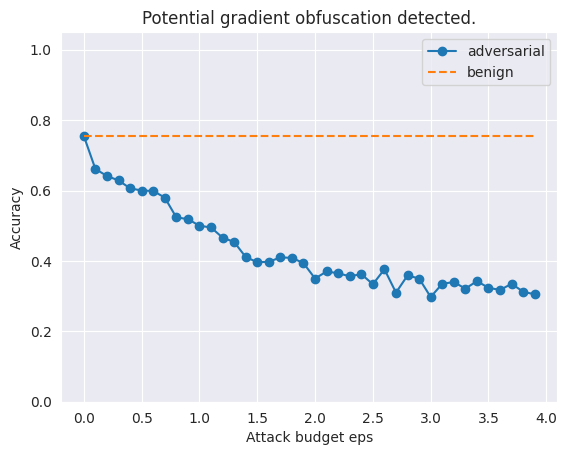

In [44]:
PGD_range = np.arange(0.0, 4, 0.1)
curve = SecurityCurve(eps=PGD_range)
kwargs_pgd = {"norm": "inf",
              "eps_step": 0.1,
              "max_iter": 100,
              "targeted": False,
              "num_random_init": 1,
              "batch_size": 64,
              "random_eps": False,
              "verbose": False,
             }
curve.evaluate(classifier_PGD_inf, X_train_validation_normalized.values, onehot_y_train.values, **kwargs_pgd)
curve.plot()

## Input Sanitization

A common best-practice in CyberSecurity is the **Input Sanitization** paradigm. The idea is simple: Input sanitization, also known as data sanitization, refers to the process of cleaning or “sanitizing” user inputs to ensure safety. It doesn’t affect input devices, but instead involves removing or modifying data that could potentially lead to system vulnerabilities or errors by checking if the input data respects some properties that the benign data follows.

Regarding our Project we can note specific properties regarding the data objects:
- Since we perform the MinMaxScaler() all features will be mapped between [0,1]. Therefore, whatever attack generates a data object with any feature greater than 1 or less than 0 might lead to either an attack or a mistake in data recording / data normalization.
- Additionally, the one_hot_encoded features, e.g. the non-numerical starting attributes, those features with "_A" in the final part of the feature name, after being normalized with the MinMaxScaler() either they assume the value 0 or 1. 

Therefore, we will check if the adversarial X_tests generated respect these properties, by applying Input Sanitizing.
For instance, here by showing the differences between the benign X_test and the Xtest_DF adversarial generated by the DeepFool attack it is straightforward to note how Input Sanitizing can be used to perform a *first-line of defense*.

In [21]:
X_test

month_duration  credit_amount  installment_rate  resident_since  \
0          0.029412       0.044467          1.000000        0.000000   
1          0.647059       0.296752          0.333333        0.666667   
2          0.117647       0.102288          0.333333        0.666667   
3          0.382353       0.167887          0.333333        1.000000   
4          0.647059       0.757503          0.333333        0.333333   
..              ...            ...               ...             ...   
195        0.470588       0.256369          1.000000        0.333333   
196        0.029412       0.080897          0.000000        0.333333   
197        0.294118       0.099825          1.000000        0.333333   
198        0.294118       0.093797          1.000000        1.000000   
199        0.205882       0.444416          1.000000        1.000000   

          age  credit_number  people_liability  credit_history_A30  \
0    0.312500            0.0               0.0                 1.0   
1    0.208333            0.0               0.0                 0.0   
2    0.604167            0.0               1.0                 0.0   
3    0.229167            0.0               0.0                 0.0   
4    0.583333            0.0               0.0                 1.0   
..        ...            ...               ...                 ...   
195  0.229167            0.0               0.0                 0.0   
196  0.020833            0.0               0.0                 0.0   
197  0.270833            0.5               0.0                 0.0   
198  0.458333            0.5               0.0                 0.0   
199  0.416667            0.5               0.0                 0.0   

     credit_history_A31  credit_history_A32  ...  telephone_A192  job_A171  \
0                   0.0                 0.0  ...             0.0       0.0   
1                   0.0                 0.0  ...             1.0       0.0   
2                   0.0                 0.0  ...             0.0       0.0   
3                   0.0                 1.0  ...             0.0       0.0   
4                   0.0                 0.0  ...             1.0       0.0   
..                  ...                 ...  ...             ...       ...   
195                 0.0                 1.0  ...             0.0       0.0   
196                 0.0                 1.0  ...             0.0       0.0   
197                 0.0                 0.0  ...             1.0       0.0   
198                 0.0                 0.0  ...             1.0       0.0   
199                 0.0                 0.0  ...             1.0       0.0   

     job_A172  job_A173  job_A174  employment_status_A71  \
0         0.0       1.0       0.0                    0.0   
1         0.0       0.0       1.0                    0.0   
2         1.0       0.0       0.0                    0.0   
3         1.0       0.0       0.0                    0.0   
4         0.0       0.0       1.0                    0.0   
..        ...       ...       ...                    ...   
195       0.0       1.0       0.0                    0.0   
196       0.0       1.0       0.0                    0.0   
197       0.0       1.0       0.0                    0.0   
198       0.0       1.0       0.0                    0.0   
199       0.0       0.0       1.0                    1.0   

     employment_status_A72  employment_status_A73  employment_status_A74  \
0                      0.0                    1.0                    0.0   
1                      0.0                    1.0                    0.0   
2                      0.0                    0.0                    1.0   
3                      1.0                    0.0                    0.0   
4                      0.0                    1.0                    0.0   
..                     ...                    ...                    ...   
195                    0.0                    0.0                    0.0   
196                    0.0       

In [49]:
Xtest_DF

month_duration  credit_amount  installment_rate  resident_since  \
0         -0.010210       0.004797          0.979612        0.001512   
1          0.509846       0.199554          0.286377        0.672375   
2          0.742297       0.698866          0.494682        0.619025   
3          0.227547       0.048663          0.274657        0.986722   
4          0.411581       0.542674          0.154517        0.389854   
..              ...            ...               ...             ...   
195        0.514774       0.296145          1.019096        0.335437   
196        0.083330       0.125881          0.011683        0.327775   
197        0.365668       0.159959          1.009840        0.328107   
198        0.201579      -0.006069          0.951049        1.018582   
199        0.141399       0.377867          0.975957        1.011334   

          age  credit_number  people_liability  credit_history_A30  \
0    0.326756      -0.014017         -0.002980            0.971696   
1    0.248702      -0.049193          0.037879           -0.055621   
2    0.338208       0.058680          1.057478            0.360072   
3    0.275941      -0.022651         -0.009159           -0.076048   
4    0.662213      -0.110653         -0.008759            0.872122   
..        ...            ...               ...                 ...   
195  0.208440       0.008376          0.004274            0.028153   
196  0.009255       0.011738         -0.002117            0.033284   
197  0.248039       0.517112         -0.013382            0.031754   
198  0.484136       0.479331          0.014923           -0.052997   
199  0.437385       0.479213         -0.000775           -0.035432   

     credit_history_A31  credit_history_A32  ...  telephone_A192  job_A171  \
0             -0.014838           -0.002838  ...        0.009171  0.009011   
1             -0.037594           -0.009758  ...        1.001166 -0.002697   
2              0.193900           -0.087528  ...       -0.203261 -0.180601   
3             -0.039735            1.013576  ...        0.053354 -0.002644   
4             -0.085792           -0.029238  ...        0.991574  0.007690   
..                  ...                 ...  ...             ...       ...   
195            0.016848            0.998376  ...       -0.008078 -0.014857   
196            0.021813            1.002980  ...       -0.012032 -0.019476   
197            0.018996           -0.000884  ...        0.997708 -0.001811   
198           -0.030832           -0.003147  ...        1.015047  0.018251   
199           -0.022513           -0.006013  ...        1.010340  0.011759   

     job_A172  job_A173  job_A174  employment_status_A71  \
0    0.001548  1.004217  0.001299              -0.003345   
1    0.015965  0.018166  0.993527              -0.008701   
2    0.864204 -0.126040 -0.048981               0.008889   
3    1.037365 -0.017298  0.011609              -0.019667   
4   -0.025668  0.052639  1.032547              -0.018302   
..        ...       ...       ...                    ...   
195 -0.005917  0.995769  0.000254               0.001482   
196 -0.017903  0.996753  0.010797               0.010599   
197 -0.011233  0.994993  0.013337               0.002766   
198  0.015683  1.025550 -0.025493              -0.002678   
199  0.005437  0.004727  0.993138               0.998822   

     employment_status_A72  employment_status_A73  employment_status_A74  \
0                -0.003369               0.982463               0.017046   
1                -0.015777               0.971845               0.028234   
2                -0.052778               0.027217               0.710608   
3                 1.008876              -0.004868              -0.000610   
4                 0.007617               0.853462               0.056275   
..                     ...                    ...                    ...   
195               0.000657               0.010368              -0.012717   
196               0.000524       

Note how all features in X_test benign are in the range [0,1], while this property is not respected in the adversarial test-set. Additionally, the one-hot-encoded features in X_test assume value 0 or 1, whereas in the adversarial test-set they assume different values.

In [56]:
def sanitize_input_all_cols(df):
    for feature in X_test.columns:
        if (df[feature] < 0).any() or (df[feature] > 1).any():
            print("At least one column with name '{}' has a value smaller than 0 or greater than 1. Anomaly in input detected!".format(feature))
            return
    print("All columns respect the [0,1] property")
def sanitize_input_one_hot_encoded(df):
    features_list_one_hot = ['credit_history_A30', 'credit_history_A31', 'credit_history_A32', 'credit_history_A33', 'credit_history_A34', 'purpose_A40', 'purpose_A41', 'purpose_A410', 'purpose_A42', 'purpose_A43', 'purpose_A44', 'purpose_A45', 'purpose_A46', 'purpose_A48', 'purpose_A49', 'status_sex_A91', 'status_sex_A92', 'status_sex_A93', 'status_sex_A94', 'debts_status_A101', 'debts_status_A102', 'debts_status_A103', 'property_A121', 'property_A122', 'property_A123', 'property_A124', 'installment_plans_A141', 'installment_plans_A142', 'installment_plans_A143', 'housing_status_A151', 'housing_status_A152', 'housing_status_A153', 'foreign_A201', 'foreign_A202', 'existing_account_A11', 'existing_account_A12', 'existing_account_A13', 'existing_account_A14', 'saving_bonds_A61', 'saving_bonds_A62', 'saving_bonds_A63', 'saving_bonds_A64', 'saving_bonds_A65', 'telephone_A191', 'telephone_A192', 'job_A171', 'job_A172', 'job_A173', 'job_A174', 'employment_status_A71', 'employment_status_A72', 'employment_status_A73', 'employment_status_A74', 'employment_status_A75']
    for feature in features_list_one_hot:
        if (df[feature] != 0).any() or (df[feature] != 1).any():
            print("At least one column with name '{}' has a value different than 0 or 1. Anomaly in one-hot-encoded input features detected!".format(feature))
            return
    print("All one_hot_econded columns in the dataframe have values of 0 or 1.")

### Input Sanitization on Deep-Fool Attack

In [57]:
sanitize_input_all_cols(Xtest_DF)
sanitize_input_one_hot_encoded(Xtest_DF)

At least one column with name 'month_duration' has a value smaller than 0 or greater than 1. Anomaly in input detected!
At least one column with name 'credit_history_A30' has a value different than 0 or 1. Anomaly in one-hot-encoded input features detected!


### Input Sanitization on FGSM Attack

In [58]:
sanitize_input_all_cols(Xtest_FGM)
sanitize_input_one_hot_encoded(Xtest_FGM)

At least one column with name 'month_duration' has a value smaller than 0 or greater than 1. Anomaly in input detected!
At least one column with name 'credit_history_A30' has a value different than 0 or 1. Anomaly in one-hot-encoded input features detected!


### Input Sanitization on PGD Attack

In [59]:
sanitize_input_all_cols(X_test_PGD_uinf)
sanitize_input_one_hot_encoded(X_test_PGD_uinf)

At least one column with name 'month_duration' has a value smaller than 0 or greater than 1. Anomaly in input detected!
At least one column with name 'credit_history_A30' has a value different than 0 or 1. Anomaly in one-hot-encoded input features detected!


### Input Sanitization on HSJ Attack

We can note how the Decision-Based HopSkipJump Attack still preserves the first property since all the feature values are in the [0,1] range. Therefore, if we wouldn't note also the second property on the one-hot-encoded features the HSJ Attack would have made it through the Input Sanitization first-line of defense.

In [54]:
X_test

month_duration  credit_amount  installment_rate  resident_since  \
0          0.029412       0.044467          1.000000        0.000000   
1          0.647059       0.296752          0.333333        0.666667   
2          0.117647       0.102288          0.333333        0.666667   
3          0.382353       0.167887          0.333333        1.000000   
4          0.647059       0.757503          0.333333        0.333333   
..              ...            ...               ...             ...   
195        0.470588       0.256369          1.000000        0.333333   
196        0.029412       0.080897          0.000000        0.333333   
197        0.294118       0.099825          1.000000        0.333333   
198        0.294118       0.093797          1.000000        1.000000   
199        0.205882       0.444416          1.000000        1.000000   

          age  credit_number  people_liability  credit_history_A30  \
0    0.312500            0.0               0.0                 1.0   
1    0.208333            0.0               0.0                 0.0   
2    0.604167            0.0               1.0                 0.0   
3    0.229167            0.0               0.0                 0.0   
4    0.583333            0.0               0.0                 1.0   
..        ...            ...               ...                 ...   
195  0.229167            0.0               0.0                 0.0   
196  0.020833            0.0               0.0                 0.0   
197  0.270833            0.5               0.0                 0.0   
198  0.458333            0.5               0.0                 0.0   
199  0.416667            0.5               0.0                 0.0   

     credit_history_A31  credit_history_A32  ...  telephone_A192  job_A171  \
0                   0.0                 0.0  ...             0.0       0.0   
1                   0.0                 0.0  ...             1.0       0.0   
2                   0.0                 0.0  ...             0.0       0.0   
3                   0.0                 1.0  ...             0.0       0.0   
4                   0.0                 0.0  ...             1.0       0.0   
..                  ...                 ...  ...             ...       ...   
195                 0.0                 1.0  ...             0.0       0.0   
196                 0.0                 1.0  ...             0.0       0.0   
197                 0.0                 0.0  ...             1.0       0.0   
198                 0.0                 0.0  ...             1.0       0.0   
199                 0.0                 0.0  ...             1.0       0.0   

     job_A172  job_A173  job_A174  employment_status_A71  \
0         0.0       1.0       0.0                    0.0   
1         0.0       0.0       1.0                    0.0   
2         1.0       0.0       0.0                    0.0   
3         1.0       0.0       0.0                    0.0   
4         0.0       0.0       1.0                    0.0   
..        ...       ...       ...                    ...   
195       0.0       1.0       0.0                    0.0   
196       0.0       1.0       0.0                    0.0   
197       0.0       1.0       0.0                    0.0   
198       0.0       1.0       0.0                    0.0   
199       0.0       0.0       1.0                    1.0   

     employment_status_A72  employment_status_A73  employment_status_A74  \
0                      0.0                    1.0                    0.0   
1                      0.0                    1.0                    0.0   
2                      0.0                    0.0                    1.0   
3                      1.0                    0.0                    0.0   
4                      0.0                    1.0                    0.0   
..                     ...                    ...                    ...   
195                    0.0                    0.0                    0.0   
196                    0.0       

In [53]:
Xtest_HSJ

month_duration  credit_amount  installment_rate  resident_since  \
0          0.000000       0.000000          0.938321        0.002319   
1          0.527882       0.157422          0.278431        0.686332   
2          0.572964       0.434640          0.554319        0.546406   
3          0.232848       0.002813          0.287784        0.995735   
4          0.429342       0.547554          0.211024        0.347826   
..              ...            ...               ...             ...   
195        0.598574       0.381778          1.000000        0.324287   
196        0.088074       0.163669          0.027763        0.330802   
197        0.425653       0.199874          1.000000        0.317816   
198        0.154530       0.000000          0.898949        0.981999   
199        0.103020       0.348205          0.979623        0.997608   

          age  credit_number  people_liability  credit_history_A30  \
0    0.357795       0.000000          0.006728            0.938686   
1    0.258954       0.000000          0.024188            0.000000   
2    0.411751       0.139094          0.987136            0.309462   
3    0.298304       0.000000          0.030119            0.000000   
4    0.655598       0.000000          0.023432            0.797241   
..        ...            ...               ...                 ...   
195  0.185429       0.078993          0.002554            0.080446   
196  0.000000       0.045973          0.000000            0.035362   
197  0.223137       0.556624          0.000000            0.067902   
198  0.513213       0.402194          0.000196            0.000000   
199  0.472195       0.485548          0.008022            0.000000   

     credit_history_A31  credit_history_A32  ...  telephone_A192  job_A171  \
0              0.000000            0.001786  ...        0.018842  0.037913   
1              0.000077            0.003971  ...        1.000000  0.009552   
2              0.200460            0.000000  ...        0.000000  0.000000   
3              0.000000            1.000000  ...        0.016641  0.020048   
4              0.000000            0.000000  ...        0.976588  0.063657   
..                  ...                 ...  ...             ...       ...   
195            0.042270            1.000000  ...        0.020442  0.000000   
196            0.009925            0.998638  ...        0.000000  0.000000   
197            0.063577            0.004999  ...        0.988354  0.000185   
198            0.000000            0.000000  ...        0.966983  0.048791   
199            0.000000            0.003787  ...        0.994493  0.042936   

     job_A172  job_A173  job_A174  employment_status_A71  \
0    0.000240  1.000000  0.000000               0.000889   
1    0.024147  0.000934  0.997097               0.000000   
2    0.992801  0.027515  0.091772               0.034530   
3    1.000000  0.000000  0.011156               0.000000   
4    0.000000  0.005568  0.943047               0.000000   
..        ...       ...       ...                    ...   
195  0.008200  0.989251  0.022333               0.018321   
196  0.000000  1.000000  0.003233               0.040552   
197  0.000000  1.000000  0.011301               0.012195   
198  0.000130  0.999984  0.001585               0.000000   
199  0.000000  0.000000  0.981853               0.990676   

     employment_status_A72  employment_status_A73  employment_status_A74  \
0                 0.004493               0.978494               0.035484   
1                 0.005656               0.980879               0.077872   
2                 0.005833               0.127902               0.846926   
3                 1.000000               0.000000               0.087896   
4                 0.008816               0.967159               0.129599   
..                     ...                    ...                    ...   
195               0.010451               0.026668               0.000000   
196               0.000376       

In [60]:
sanitize_input_all_cols(Xtest_HSJ)
sanitize_input_one_hot_encoded(Xtest_HSJ)

All columns respect the [0,1] property
At least one column with name 'credit_history_A30' has a value different than 0 or 1. Anomaly in one-hot-encoded input features detected!
